### Newsbot to write a daily AI news summary using langgraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary
- Used to generate a daily newsletter at skynetandchill.com 


In [1]:
# to selectively re-import as needed
import sys
# del sys.modules['ainb_llm']
# del sys.modules['ainb_const']
# del sys.modules['ainb_utilities']
# del sys.modules['ainb_webscrape']


In [2]:
from datetime import datetime, timedelta
import os
import shutil
import yaml
import sqlite3
import json
from collections import Counter
import uuid
from typing import TypedDict, Annotated
import subprocess
import requests
import re

import operator
import pickle

import langchain
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_core.prompts import (ChatPromptTemplate, MessagesPlaceholder, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver

from langchain_core.output_parsers import SimpleJsonOutputParser, JsonOutputParser, StrOutputParser

from langgraph.graph import StateGraph, START, END

from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

import numpy as np
import pandas as pd
import umap

import sklearn
from sklearn.cluster import DBSCAN

import bs4
from urllib.parse import urljoin, urlparse

import multiprocessing
import asyncio
import aiohttp

from IPython.display import HTML, Image, Markdown, display
import markdown

import pyperclip
import shlex

import openai
from openai import OpenAI

import trafilatura   # web scrape uses this to get clean news stories w/o a lot of js and boilerplate

import pdb

import dotenv
VERBOSE=1
from ainb_const import (DOWNLOAD_DIR, PAGES_DIR,
                        MODEL, LOWCOST_MODEL, HIGHCOST_MODEL, CANONICAL_TOPICS,
                        SOURCECONFIG, FILTER_PROMPT, TOPIC_PROMPT,
                        SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT, FINAL_SUMMARY_PROMPT, 
                        TOP_CATEGORIES_PROMPT, TOPIC_REWRITE_PROMPT, REWRITE_PROMPT,
                        MAX_INPUT_TOKENS, MAX_OUTPUT_TOKENS, MAX_RETRIES, TEMPERATURE, SQLITE_DB,
                        HOSTNAME_SKIPLIST, SITE_NAME_SKIPLIST, TOPSOURCES
                       )
from ainb_utilities import (log, delete_files, filter_unseen_urls_db, insert_article,
                            nearest_neighbor_sort, agglomerative_cluster_sort, traveling_salesman_sort_scipy,
                            unicode_to_ascii, send_gmail)
from ainb_webscrape import (get_driver, quit_drivers, launch_drivers, get_file, get_url, parse_file,
                            get_og_tags, get_path_from_url, trimmed_href, process_source_queue_factory,
                            process_url_queue_factory, get_google_news_redirects)
from ainb_llm import (paginate_df, process_pages, fetch_pages, fetch_openai, fetch_all_summaries,
                      fetch_openai_summary, count_tokens, trunc_tokens, 
                      categorize_headline, categorize_df, clean_topics,
                      get_site_name, fetch_missing_site_names)


import asyncio
# need this to run async in jupyter since it already has an asyncio event loop running
import nest_asyncio
nest_asyncio.apply()


In [3]:
print(f"Python            {sys.version}")
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")


Python            3.11.10 | packaged by conda-forge | (main, Sep 10 2024, 10:57:35) [Clang 17.0.6 ]
LangChain         0.3.3
OpenAI            1.52.0
trafilatura       1.12.2
numpy             1.26.4
pandas            2.2.3
sklearn           1.5.2
umap              0.5.6


# Test LLM calling

In [ ]:
# a basic LLM call with langchain
model = ChatOpenAI(model=MODEL)

model.invoke([
    SystemMessage(content="Translate the following from English into Italian"),
    HumanMessage(content='Listen to me. You are beautiful. You are perfect and I love you.'),
])


In [ ]:
# use a langchain template
system_template = "Translate the following into {language}:"
prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template), ("user", "{text}")]
)
parser = StrOutputParser()
chain = prompt_template | model | parser
chain.invoke({"language": "italian", "text": "hi"})


In [ ]:
# time multiple templates (single-threaded)
prompt_inputs = [
    {"language": "French", "adjective1": "flawless", "adjective2": "beautiful"},
    {"language": "German", "adjective1": "immaculate", "adjective2": "exquisite"},
    {"language": "Spanish", "adjective1": "perfect", "adjective2": "gorgeous"},
    {"language": "Italian", "adjective1": "amazing", "adjective2": "magnificent"},
    {"language": "Hungarian", "adjective1": "ravishing", "adjective2": "stunning"},
]

system_template = 'Translate the following into {language}:'
user_template = 'Listen to me. You are {adjective1}. You are {adjective2} and I love you.'

prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template),
     ("user", user_template)]
)

parser = StrOutputParser()

chain = prompt_template | model | parser

start_time = datetime.now()
for tpl in prompt_inputs:
    response = ""
    # stream tokens as they are generated
    for r in chain.stream(tpl):
        print(r, end="")
        response += r
end_time = datetime.now()

difference = end_time - start_time
total_seconds = difference.total_seconds()
print(f"\n\nElapsed seconds: {total_seconds:.6f}")


In [ ]:
# same but send all at once using asyncio

async def async_langchain(chain, input_dict):
    response = await chain.ainvoke(input_dict)
    return response


prompt_templates = [
    {"language": "French", "adjective1": "flawless", "adjective2": "beautiful"},
    {"language": "German", "adjective1": "immaculate", "adjective2": "exquisite"},
    {"language": "Spanish", "adjective1": "perfect", "adjective2": "gorgeous"},
    {"language": "Italian", "adjective1": "amazing", "adjective2": "magnificent"},
    {"language": "Hungarian", "adjective1": "ravishing", "adjective2": "stunning"},
]

start_time = datetime.now()
tasks = []
for d in prompt_templates:
    task = asyncio.create_task(async_langchain(chain, d))
    tasks.append(task)
responses = await asyncio.gather(*tasks)
end_time = datetime.now()


difference = end_time - start_time
total_seconds = difference.total_seconds()
print(f"\n\nElapsed seconds: {total_seconds:.6f}")
print("\n".join(responses))


In [ ]:
# test o1-preview, note temperature, system prompt not supported
# client = OpenAI()
# response = client.chat.completions.create(
#     model="o1-preview",
#     messages=[
#         {
#             "role": "user",
#             "content": "Write a Python script that takes a matrix represented as a string with format '[1,2],[3,4],[5,6]' and prints the transpose in the same format."
#         }
#     ]
# )
# print(response.choices[0].message.content)


# Functions for state graph
- Each takes a state dict and returns updated state dict
- We will use these later to construct a LangGraph agent workflow

In [4]:
DEBUG = False
N_BROWSERS = 4
MAX_EDITS = 2
before_date = None
# before_date = '2024-10-19 15:00:00'
do_download = False


In [5]:
# class to maintain state within graph
# import pydantic

class AgentState(TypedDict):
    AIdf: list[dict]                    #  the current working set of headlines (pandas dataframe not supported)
    before_date: str                    #  ignore stories before this date for deduplication (force reprocess since)
    do_download: bool                   #  if False use existing files, else download from sources
    sources: dict                       #  sources to scrap
    sources_reverse: dict[str, str]     #  map file names to sources
    bullets: list[str]                  #  bullet points for summary email
    summary: str                        #  final summary
    cluster_topics: list[str]           #  list of cluster topics
    topics_str: str                     #  edited topics
    n_edits: int                        #  count edit iterations so we don't keep editing forever
    edit_complete: bool                 #  edit will update if no more edits to make
    # message thread with OpenAI
    # messages: Annotated[list[AnyMessage], operator.add]


In [6]:
test_state = AgentState(
    {'AIdf': None,
    'before_date': before_date,
    'do_download': do_download,
    'sources': None,
    'sources_reverse': None,
    'bullets': '',
    'summary': '',
    'cluster_topics': [],
    'topics_str': '',
    'n_edits': 0,
    'edit_complete': False,
#     'messages': None
    }
)


In [7]:
# Initialize reading configurations from YAML file

def fn_initialize(state: AgentState) -> AgentState:
    """
    Initializes the agent state by loading source configurations from SOURCECONFIG (sources.yaml) .

    Args:
        state (AgentState): The current state of the agent.
        verbose (bool, optional): Whether to print verbose output. Defaults to False.

    Returns:
        AgentState: The updated state of the agent.

    Raises:
        yaml.YAMLError: If there is an error while loading the YAML file.

    """

    #  load sources to scrape from sources.yaml
    with open(SOURCECONFIG, "r") as stream:
        try:
            state['sources'] = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)

    log(f"Initialized {len(state['sources'])} items in sources from {SOURCECONFIG}")

    # make a reverse dict to map file titles to source names
    state['sources_reverse'] = {}
    for k, v in state['sources'].items():
        log(f"{k} -> {v['url']} -> {v['title']}.html")
        v['sourcename'] = k
        # map filename (title) to source name
        state['sources_reverse'][v['title']] = k

    log(f"Initialized {len(state['sources_reverse'])} items in sources_reverse")

    return state


if DEBUG:
    test_state = fn_initialize(test_state)


In [8]:
# scrape sources with selenium and save local files in DOWNLOAD_DIR (htmldata)
def fn_download_sources(state: AgentState) -> AgentState:
    """
    Scrapes sources and saves HTML files.
    If state["do_download"] is True, deletes all files in DOWNLOAD_DIR (htmldata) and scrapes fresh copies.
    If state["do_download"] is False, uses existing files in DOWNLOAD_DIR.
    Uses state["sources"] for config info on sources to scrape
    For each source, saves the current filename to state["sources"][sourcename]['latest']

    Args:
        state (AgentState): The current state of the agent.
        do_delete (bool, optional): Whether to delete files in DOWNLOAD_DIR. Defaults to True.

    Returns:
        AgentState: The updated state of the agent.
    """

    if state.get("do_download"):
        # empty download directories
        delete_files(DOWNLOAD_DIR)
        delete_files(PAGES_DIR)

        # save each file specified from sources
        log(f"Saving HTML files using {N_BROWSERS} browsers")

        # Create a queue for multiprocessing and populate it
        queue = multiprocessing.Queue()
        for item in state.get("sources").values():
            queue.put(item)

        # Function to take the queue and pop entries off and process until none are left
        # lets you create an array of functions with different args
        callable = process_source_queue_factory(queue)

        saved_pages = launch_drivers(N_BROWSERS, callable)
        for sourcename, file in saved_pages:
            log(f"Downloaded {sourcename} to {file}")
            state['sources'][sourcename]['latest'] = file
        log(f"Saved {len(saved_pages)} HTML files")

    else:   # use existing files
        log(f"Web fetch disabled, using existing files in {DOWNLOAD_DIR}")
        # Get the current date
        datestr = datetime.now().strftime("%m_%d_%Y")
        files = [os.path.join(DOWNLOAD_DIR, file)
                 for file in os.listdir(DOWNLOAD_DIR)]
        # filter files with today's date ending in .html
        files = [
            file for file in files if datestr in file and file.endswith(".html")]
        log(f"Found {len(files)} previously downloaded files")
        for file in files:
            log(file)

        saved_pages = []
        for file in files:
            filename = os.path.basename(file)
            # locate date like '01_14_2024' in filename
            position = filename.find(" (" + datestr)
            basename = filename[:position]
            # match to source name
            sourcename = state.get("sources_reverse", {}).get(basename)
            if sourcename is None:
                log(f"Skipping {basename}, no sourcename metadata")
                continue
            state["sources"][sourcename]['latest'] = file

    return state

if DEBUG:
    test_state = fn_download_sources(test_state)


In [9]:
def fn_extract_urls(state: AgentState) -> AgentState:
    """
    Extracts news URLs from the latest HTML files matching the patterns defined in the state['sources'] configuration info.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent with the extracted URLs stored in state['AIdf'].
    """
    # Parse news URLs and titles from downloaded HTML files
    log("Parsing html files")
    all_urls = []
    for sourcename, sourcedict in state['sources'].items():
        filename = sourcedict.get('latest')
        if not filename:
            log(f"no filename found for {sourcename}")
            continue

        log(sourcename + ' -> ' + filename)
        links = parse_file(state['sources'][sourcename])
        log(f"{len(links)} links found")
        all_urls.extend(links)

    log(f"Saved {len(all_urls)} links")

    # make a pandas dataframe of all the links found
    AIdf = (
        pd.DataFrame(all_urls)
        .groupby("url")
        .first()
        .reset_index()
        .sort_values("src")[["src", "title", "url"]]
        .reset_index(drop=True)
        .reset_index(drop=False)
        .rename(columns={"index": "id"})
    )
    state['AIdf'] = AIdf.to_dict(orient='records')

    return state


if DEBUG:
    test_state = fn_extract_urls(test_state)

    # s/b 17 but if some like bloomberg" or wsj are missing, maybe got a robot block
    # if so, download missing ones manually and then re-run fn_extract_urls
    print(len(pd.DataFrame(test_state["AIdf"]).groupby('src').count()))
    display(pd.DataFrame(test_state["AIdf"]).groupby('src').count()[['id']])


In [10]:
# get AI news via newscatcher
# https://docs.newscatcherapi.com/api-docs/endpoints/search-news

newscatcher_sources = ['247wallst.com',
 '9to5mac.com',
 'androidauthority.com',
 'androidcentral.com',
 'androidheadlines.com',
 'appleinsider.com',
 'benzinga.com',
 'cnet.com',
 'cnn.com',
 'digitaltrends.com',
 'engadget.com',
 'fastcompany.com',
 'finextra.com',
 'fintechnews.sg',
 'fonearena.com',
 'ft.com',
 'gadgets360.com',
 'geekwire.com',
 'gizchina.com',
 'gizmochina.com',
 'gizmodo.com',
 'gsmarena.com',
 'hackernoon.com',
 'howtogeek.com',
 'ibtimes.co.uk',
 'itwire.com',
 'lifehacker.com',
 'macrumors.com',
 'mashable.com',
#  'medium.com',
 'mobileworldlive.com',
 'msn.com',
 'nypost.com',
 'phonearena.com',
 'phys.org',
 'popsci.com',
 'scmp.com',
 'sify.com',
 'siliconangle.com',
 'siliconera.com',
 'siliconrepublic.com',
 'slashdot.org',
 'slashgear.com',
 'statnews.com',
 'tech.co',
 'techcrunch.com',
 'techdirt.com',
 'technode.com',
 'technologyreview.com',
 'techopedia.com',
 'techradar.com',
 'techraptor.net',
 'techtimes.com',
 'techxplore.com',
 'telecomtalk.info',
 'thecut.com',
 'thedrum.com',
 'thehill.com',
 'theregister.com',
 'theverge.com',
 'thurrott.com',
 'tipranks.com',
 'tweaktown.com',
 'videocardz.com',
 'washingtonpost.com',
 'wccftech.com',
 'wired.com',
 'xda-developers.com',
 'yahoo.com',
 'zdnet.com']

def fn_extract_newscatcher(state: AgentState) -> AgentState:
    
    q = 'Artificial Intelligence'
    page_size = 100
    log(f"Fetching top {page_size} stories matching {q} from Newscatcher")
    base_url = "https://api.newscatcherapi.com/v2/search"
    time_24h_ago = datetime.now() - timedelta(hours=24)

    # Put API key in headers 
    headers = {'x-api-key': os.getenv('NEWSCATCHER_API_KEY')}

    # Define search parameters
    params = {
        'q': q,
        'lang': 'en',
        'sources': ','.join(newscatcher_sources),
        'from': time_24h_ago.strftime('%Y-%m-%d %H:%M:%S'),
        'to': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'page_size': page_size, # by default should be most highly relevant to the search
        'page': 1
        }

    # Make API call with headers and params
    response = requests.get(base_url, headers=headers, params=params)

    # Encode received results
    results = json.loads(response.text.encode())
    if response.status_code != 200:
        print('ERROR: API call failed.')
        print(results)
        
    # merge into existing df
    newscatcher_df = pd.DataFrame(results['articles'])[['title', 'link']]
    newscatcher_df['src']='Newscatcher'
    newscatcher_df = newscatcher_df.rename(columns={'link': 'url'})
#     display(newscatcher_df.head())
    AIdf = pd.DataFrame(state['AIdf'])
#     display(AIdf.head())
    
    max_id = AIdf['id'].max()
    # add id column to newscatcher_df
    newscatcher_df['id'] = range(max_id + 1, max_id + 1 + len(newscatcher_df))
    AIdf = pd.concat([AIdf, newscatcher_df], ignore_index=True)
    state['AIdf'] = AIdf.to_dict(orient='records')
    return state
    

if DEBUG:
    test_state = fn_extract_newscatcher(test_state)
    print(len(pd.DataFrame(test_state["AIdf"]).groupby('src').count()))
    display(pd.DataFrame(test_state["AIdf"]).groupby('src').count()[['id']])
    

In [11]:
# some debugging stuff
# zdf = pd.DataFrame(test_state["AIdf"])
# zdf.loc[zdf["src"]=='Techmeme']

# connection = sqlite3.connect('articles.db')
# xdf = pd.read_sql_query("SELECT * FROM news_articles", connection)
# connection.close()

# zdf.loc[zdf["title"].str.startswith("NHTSA")] 
# xdf.loc[xdf["title"].str.startswith("NHTSA")] 

# pd.set_option('display.max_rows', 300)  # Ensure up to 300 rows are shown

# xdf.loc[xdf['isAI']> 0].groupby('actual_src') \
#     .count() \
#     .reset_index()[['actual_src', 'id']] \
#     .sort_values('id', ascending=False) \
#     .head(300)


In [12]:
# sqlite schema to store previously processed 
# CREATE TABLE news_articles (
#     id INTEGER PRIMARY KEY,
#     src TEXT,
#     title TEXT,
#     url TEXT UNIQUE,
#     isAI BOOLEAN,
#     article_date DATE
# , timestamp DATETIME, actual_url TEXT, actual_src TEXT);
#
# CREATE TABLE sites (
#     id INTEGER PRIMARY KEY AUTOINCREMENT,
#     hostname TEXT UNIQUE NOT NULL,
#     site_name TEXT NOT NULL
# );



In [13]:
# filter and clean URLs for new AI stories

def fn_filter_urls(state: AgentState) -> AgentState:
    """
    Filters the URLs in state["AIdf"] to include only those that have not been previously seen,
    and are related to AI according to the response from a ChatGPT prompt.

    Args:
        state (AgentState): The current state of the agent.
        before_date (str, optional): The date before which the URLs should be filtered. Defaults to "".

    Returns:


        AgentState: The updated state of the agent with the filtered URLs stored in state["AIdf"].

    """
    # filter to URL not previously seen
    AIdf = pd.DataFrame(state['AIdf'])

    AIdf = filter_unseen_urls_db(AIdf, before_date=state.get("before_date"))

    if len(AIdf) == 0:
        log("No new URLs, returning")
        return state

    # dedupe identical headlines
    # filter similar titles differing by type of quote or something
    AIdf['title'] = AIdf['title'].apply(unicode_to_ascii)
    AIdf['title_clean'] = AIdf['title'].map(lambda s: "".join(s.split()))
    AIdf = AIdf.sort_values("src") \
        .groupby("title_clean") \
        .first() \
        .reset_index(drop=True) \
        .drop(columns=['id']) \
        .reset_index() \
        .rename(columns={'index': 'id'})
    log(f"Found {len(AIdf)} unique new headlines")

    # structured response format
    json_schema = {
        "name": "json_schema",
        "strict": True,
        "schema": {
            "type": "object",
            "properties": {
                "isai_array": {
                    "type": "array",
                    "items": {
                        "type": "object",
                                "properties": {
                                    "id": {
                                        "type": "number"
                                    },
                                    "isAI": {
                                        "type": "boolean"
                                    }
                                },
                        "required": ["id", "isAI"],
                        "additionalProperties": False
                    }
                }
            },
            "required": ["isai_array"],
            "additionalProperties": False
        }
    }

    # filter AI-related headlines using a prompt
    pages = paginate_df(AIdf)
    enriched_urls = asyncio.run(fetch_pages(pages, prompt=FILTER_PROMPT, json_schema=json_schema))
    filter_df = pd.DataFrame(enriched_urls)
    
    try:  # for idempotency
        AIdf = AIdf.drop(columns=['isAI'])
    except:
        pass

    # merge returned df with isAI column into original df on id column
    AIdf = pd.merge(AIdf, filter_df, on="id", how="outer")
    log(AIdf.columns)
    # set hostname based on actualurl
    AIdf['actual_url'] = AIdf['url']    # ideally resolve redirects but Google News blocks
    AIdf['hostname']=AIdf['actual_url'].apply(lambda url: urlparse(url).netloc)

    # update SQLite database with all seen URLs (we are doing this using url and ignoring redirects)
    log(f"Inserting {len(AIdf)} URLs into {SQLITE_DB}")
    conn = sqlite3.connect(SQLITE_DB)
    cursor = conn.cursor()
    for row in AIdf.itertuples():
        insert_article(conn, cursor, row.src, row.hostname, row.title,
                       row.url, row.actual_url, row.isAI, datetime.now().date())

    # keep headlines that are related to AI
    AIdf = AIdf.loc[AIdf["isAI"]==1] \
        .reset_index(drop=True)  \
        .reset_index()  \
        .drop(columns=["id"])  \
        .rename(columns={'index': 'id'})

    log(f"Found {len(AIdf)} AI headlines")

    # update actual URLs for Google News redirects
    # I think Google changed something so this no longer works, instead of a 301 redirct
    # get a javascript page that redirects. Also tomorrow we might see different URLs for same stories
    # AIdf = get_google_news_redirects(AIdf)

    conn = sqlite3.connect('articles.db')
    query = "select * from sites"
    sites_df = pd.read_sql_query(query, conn)
    sites_dict = {row.hostname:row.site_name for row in sites_df.itertuples()}
    conn.close()

    # get clean site_name
    AIdf['site_name'] = AIdf['hostname'].apply(lambda hostname: sites_dict.get(hostname, hostname))

    # if any missing clean site names, populate them using OpenAI
    missing_site_names =  len(AIdf.loc[AIdf['site_name']==""])
    if missing_site_names:
        log(f"Asking OpenAI for {missing_site_names} missing site names")
        responses = asyncio.run(fetch_missing_site_names(AIdf))
        # update site_dict from responses
        new_urls = []
        for r in responses:
            if r['url'].startswith('https://'):
                r['url'] = r['url'][8:]
            new_urls.append(r['url'])
            sites_dict[r['url']] = r['site_name']
            log(f"Looked up {r['url']} -> {r['site_name']}")
        # update sites table with new names
        for url in new_urls:
            sqlstr = "INSERT OR IGNORE INTO sites (hostname, site_name) VALUES (?, ?);"
            log(f"Updated {url} -> {sites_dict[url]}")
            conn.execute(sqlstr, (url, sites_dict[url]))
            conn.commit()
        # reapply to AIdf with updated sites
        AIdf['site_name'] = AIdf['hostname'].apply(lambda hostname: sites_dict.get(hostname, hostname))
    else:
        log("No missing site names")
  
    # drop banned slop sites

    AIdf = AIdf.loc[~AIdf["hostname"].str.lower().isin(HOSTNAME_SKIPLIST)]
    AIdf = AIdf.loc[~AIdf["site_name"].str.lower().isin(SITE_NAME_SKIPLIST)]
    
    state["AIdf"] = AIdf.to_dict(orient='records')
    return state


if DEBUG:
    test_state = fn_filter_urls(test_state)
    display(pd.DataFrame(test_state["AIdf"]).groupby('src').count()[['id']])
    display(list(pd.DataFrame(test_state["AIdf"]).columns))



In [14]:
# for row in pd.DataFrame(test_state["AIdf"]).itertuples():
#     display(Markdown(f"[{row.id}. {row.title} - {row.src}]({row.url})"))


In [15]:
# Function for topic extraction
# TODO: could send more prompts to gpt-4o-mini and not hit rate limits
def clean_topics(row, lcategories):
    """
    Cleans the extracted_topics and assigned_topics by removing certain common topics and combining them into a single list.

    Args:
        row (pandas.Series): The row containing the extracted_topics and assigned_topics.
        lcategories (set): The set of lowercase categories.

    Returns:
        list: The cleaned and combined list of topics.
    """
    extracted_topics = [x.title() for x in row.extracted_topics if x.lower() not in {"technology", "ai", "artificial intelligence"}]
    assigned_topics = [x.title() for x in row.assigned_topics if x.lower() in lcategories]
    combined = sorted(list(set(extracted_topics + assigned_topics)))
    combined = [s.replace("Ai", "AI") for s in combined]
    combined = [s.replace("Genai", "Gen AI") for s in combined]
    combined = [s.replace("Openai", "OpenAI") for s in combined]

    return combined


async def do_cat(AIdf, categories):
    """
    Sends a prompt to ChatGPT to select topics for the title for each row in AIdf
    which match the topics in categories.

    Args:
        AIdf (pandas.DataFrame): The DataFrame containing the headlines.
        categories (list): The list of topics to match with the headlines.

    Returns:
        dict: A dictionary where the keys are the row IDs and the values are lists
        of selected topics for each headline.

    """

    catdict = {}
    async with aiohttp.ClientSession() as session:
        for i, row in enumerate(AIdf.itertuples()):
            tasks = []
            log(f"Categorizing headline {row.id+1} of {len(AIdf)}")
            h = row.title
            log(h)
            for c in categories:
                task = asyncio.create_task(categorize_headline(h, c, session))
                tasks.append(task)
            responses = await asyncio.gather(*tasks)
            catdict[row.id] = [item for sublist in responses for item in sublist]
            log(str(catdict[row.id]))

    return catdict


def fn_topic_analysis(state: AgentState) -> AgentState:

    """
    Extracts and selects topics for each headline in the state['AIdf'] dataframe, scrubs them, and stores them back in the dataframe.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent with the extracted and selected topics stored in state['AIdf'].
    """
    AIdf = pd.DataFrame(state['AIdf'])
    pages = paginate_df(AIdf)
    # apply topic extraction prompt to AI headlines
    log("start free-form topic extraction")
    json_schema = {
        "name": "extracted_topics",
        "strict": True,
        "schema": {
            "type": "object",
            "properties": {
                "extracted_topics": {
                    "type": "array",
                    "items": {
                        "type": "object",
                        "properties": {
                            "id": {
                                "type": "number",
                            },
                            "topics": {
                                "type": "array",
                                "items": {
                                    "type": "string",
                                },
                            },
                        },
                        "required": ["id", "topics"],
                        "additionalProperties": False,
                    }
                }
            },
            "required": ["extracted_topics"],
            "additionalProperties": False,
        }
    }
    response = asyncio.run(fetch_pages(pages, prompt=TOPIC_PROMPT, json_schema=json_schema))
    topic_df = pd.DataFrame(response)

    topic_df = topic_df.rename(columns={'topics': 'extracted_topics'})
    log(f"{len(topic_df)} free-form topics extracted")
    all_topics = [item.lower() for row in topic_df.itertuples() for item in row.extracted_topics]
    item_counts = Counter(all_topics)
    filtered_topics = [item for item in item_counts if item_counts[item] >= 2 and item not in {'technology', 'ai', 'artificial intelligence'}]

    categories = sorted(CANONICAL_TOPICS)
    # use categories that are canonical or show up twice in freeform
    lcategories = set([c.lower() for c in categories] + [c.lower() for c in filtered_topics])
    # new topics
    log([c for c in filtered_topics if c not in categories])

    catdict = asyncio.run(categorize_headline(AIdf, categories=categories))
    topic_df['assigned_topics'] = topic_df['id'].apply(lambda id: catdict.get(id, ""))

#     pdb.set_trace()

    topic_df["topics"] = topic_df.apply(lambda t: clean_topics(t, lcategories), axis=1)
    topic_df["topic_str"] = topic_df.apply(lambda row: ", ".join(row.topics), axis=1)

    try: # for idempotency
        AIdf = AIdf.drop(columns=['topic_str', 'title_topic_str'])
    except:
        pass

    AIdf = pd.merge(AIdf, topic_df[["id", "topic_str"]], on="id", how="outer")
    AIdf['title_topic_str'] = AIdf.apply(lambda row: f'{row.title} (Topics: {row.topic_str})', axis=1)

    state["AIdf"] = AIdf.to_dict(orient='records')
    return state

if DEBUG:
    test_state = fn_topic_analysis(test_state)


In [16]:
async def write_topic_name(topic_list_str, max_retries=3, model=LOWCOST_MODEL):
    """
    Generates a name for a cluster based on a list of headline topics.

    Parameters:
    session (aiohttp.ClientSession): The client session for making async HTTP requests.
    topic_list_str (str): A string containing the list of headline topics.
    max_retries (int, optional): The maximum number of retries in case of an error. Defaults to 3.
    model (str, optional): The model to use for generating the topic name. Defaults to LOWCOST_MODEL.

    Returns:
    dict: A dictionary containing the generated topic name.

    Example Usage:
    title_topic_str_list = "Headline 1 (Topic: Topic 1)\n\nHeadline 2 (Topic: Topic 2)"
    result = await write_topic_name(session, title_topic_str_list)
    print(result)

    Output:
    {"topic_title": "Generated Topic Name"}
    ```
    """
    TOPIC_WRITER_PROMPT = f"""
You are a topic writing assistant. I will provide a list of headlines with extracted topics in parentheses.
Your task is to propose a name for a topic that very simply, clearly and accurately captures all the provided
headlines in less than 7 words. You will output a JSON object with the key "topic_title".

Example Input:
In the latest issue of Caixins weekly magazine: CATL Bets on 'Skateboard Chassis' and Battery Swaps to Dispell Market Concerns (powered by AI) (Topics: Battery Swaps, Catl, China, Market Concerns, Skateboard Chassis)

AI, cheap EVs, future Chevy  the week (Topics: Chevy, Evs)

Electric Vehicles and AI: Driving the Consumer & World Forward (Topics: Consumer, Electric Vehicles, Technology)

Example Output:
{{"topic_title": "Electric Vehicles"}}

Task
Propose the name for the overall topic based on the following provided headlines and individual topics:

{topic_list_str}
"""

    for i in range(max_retries):
        try:
            messages=[
                      {"role": "user", "content": TOPIC_WRITER_PROMPT
                      }]

            payload = {"model":  model,
                       "response_format": {"type": "json_object"},
                       "messages": messages,
                       "temperature": 0
                       }
#             print(topic_list_str)

            async with aiohttp.ClientSession() as session:
                response = asyncio.run(fetch_openai(session, payload))
            response_dict = json.loads(response["choices"][0]["message"]["content"])
            log(response_dict)
            
            return response_dict
        except Exception as exc:
            log(f"Error: {exc}")

    return {}


def fn_topic_clusters(state: AgentState) -> AgentState:
    """
    Fetches embeddings for the headlines, creates clusters of similar articles using DBSCAN, and sorts
    using the clusters and a traveling salesman shortest traversal in embedding space.

    Parameters:
    state (AgentState): The state of the agent.

    Returns:
    AgentState: The updated state of the agent.

    """
    AIdf = pd.DataFrame(state['AIdf'])

    log(f"Fetching embeddings for {len(AIdf)} headlines")
    embedding_model = 'text-embedding-3-large'
    client = OpenAI()
    response = client.embeddings.create(input=AIdf['title_topic_str'].tolist(),
                                        model=embedding_model)
    embedding_df = pd.DataFrame([e.model_dump()['embedding'] for e in response.data])

    # greedy traveling salesman sort
    log(f"Sort with nearest_neighbor_sort sort")
    sorted_indices = nearest_neighbor_sort(embedding_df)
    AIdf['sort_order'] = sorted_indices

    # do dimensionality reduction on embedding_df and cluster analysis
    log(f"Load umap dimensionality reduction model")
    with open("reducer.pkl", 'rb') as file:
        # Load the model from the file
        reducer = pickle.load(file)
    log(f"Perform dimensionality reduction")
    reduced_data = reducer.transform(embedding_df)
    log(f"Cluster with DBSCAN")
    dbscan = DBSCAN(eps=0.4, min_samples=3)  # Adjust eps and min_samples as needed
    AIdf['cluster'] = dbscan.fit_predict(reduced_data)
    AIdf.loc[AIdf['cluster'] == -1, 'cluster'] = 999

    # sort first by clusters found by DBSCAN, then by semantic ordering
    AIdf = AIdf.sort_values(['cluster', 'sort_order']) \
        .reset_index(drop=True) \
        .reset_index() \
        .drop(columns=["id"]) \
        .rename(columns={'index': 'id'})

    # show clusters
    state["cluster_topics"] = []
    with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
        for i in range(30):
            try:
                tmpdf = AIdf.loc[AIdf['cluster']==i][["id", "title_topic_str"]]
                if len(tmpdf) ==0:
                    break
                display(tmpdf)
                title_topic_str_list = ("\n\n".join(tmpdf['title_topic_str'].to_list()))
                cluster_topic = asyncio.run(write_topic_name(title_topic_str_list))
                cluster_topic = cluster_topic['topic_title']
                state["cluster_topics"].append(cluster_topic)
                log(f"I dub this cluster: {cluster_topic}")
            except Exception as exc:
                log(exc)
    AIdf["cluster_name"] = AIdf['cluster'].apply(lambda i: state["cluster_topics"][i] 
                                                 if i < len(state["cluster_topics"]) 
                                                 else "")
    state["AIdf"] = AIdf.to_dict(orient='records')
    print(state["cluster_topics"])
    return state

# TODO: could add a quality rating for stories based on site reputation, length, complexity of story
# could then add the quality rating to the summaries and tell the prompt to favor high-quality stories
# could put summaries into vector store and retrieve stories by topic. but then you will have to deal
# with duplicates across categories, ask the prompt to dedupe

# def fn_topic_clusters(state: AgentState) -> AgentState:
#     "call async afn_topic_clusters on state"
#     state = asyncio.run(afn_topic_clusters(state))
#     return state


if DEBUG:
    test_state = fn_topic_clusters(test_state)


In [17]:
# scrape individual pages
def fn_download_pages(state: AgentState) -> AgentState:
    """
    Uses several Selenium browser sessions to download all the pages referenced in the
    state["AIdf"] DataFrame and store their pathnames.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent with the downloaded pages' pathnames stored in the `state["AIdf"]` DataFrame.
    """
    log("Queuing URLs for scraping")
    AIdf = pd.DataFrame(state['AIdf'])
    queue = multiprocessing.Queue()

    count = 0
    for row in AIdf.itertuples():
#         if row.cluster < 999:
        queue.put((row.id, row.url, row.title))
        count +=1
    # scrape urls in queue asynchronously
    num_browsers = 4

    callable = process_url_queue_factory(queue)

    log(f"fetching {count} pages using {num_browsers} browsers")
    saved_pages = launch_drivers(num_browsers, callable)

    pages_df = pd.DataFrame(saved_pages)
    if len(pages_df):
        pages_df.columns = ['id', 'url', 'title', 'path']

        try: # for idempotency
            AIdf = AIdf.drop(columns=['path'])
        except:
            pass        
        AIdf = pd.merge(AIdf, pages_df[["id", "path"]], on='id', how="inner")
    state["AIdf"] = AIdf.to_dict(orient='records')
    return state


if DEBUG:
    test_state = fn_download_pages(test_state)



In [18]:
# summarize individual pages

def fn_summarize_pages(state: AgentState) -> AgentState:
    """
    Reads all the articles, summarizes each one using a ChatGPT prompt, and sends an email with the summaries.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent.

    """
    log("Starting summarize")
    AIdf = pd.DataFrame(state['AIdf'])
    responses = asyncio.run(fetch_all_summaries(AIdf))
    log(f"Received {len(responses)} summaries")
    response_dict = {}
    for i, response in responses:
        try:
            response_str = response["choices"][0]["message"]["content"]
            response_dict[i] = response_str
        except Exception as exc:
            print(exc)

    markdown_str = ''
    bullets = []

    for i, row in enumerate(AIdf.itertuples()):
        try:
            topics = []
            if row.cluster_name:
                topics.append(row.cluster_name)
            if row.topic_str:
                topics.append(row.topic_str)
            topic_str = ", ".join(topics)

            mdstr = f"[{i+1}. {row.title} - {row.site_name}]({row.actual_url})  \n\n {topic_str}  \n\n{response_dict[row.id]} \n\n"
            bullets.append(f"[{row.title} - {row.site_name}]({row.actual_url})\n\nTopics: {row.topic_str} \n\n{response_dict[row.id]}\n\n")
            display(Markdown(mdstr.replace("$","\\\\$")))
            markdown_str += mdstr
        except Exception as exc:
            print("Error:", exc)

    state['bullets'] = bullets
    # Convert Markdown to HTML
    html_str = markdown.markdown(markdown_str, extensions=['extra'])
    # save bullets
    with open('bullets.md', 'w') as f:
        f.write(markdown_str)
    # send email
    log("Sending bullet points email")
    subject = f'AI news bullets {datetime.now().strftime("%H:%M:%S")}'
    send_gmail(subject, html_str)

    return state


if DEBUG:
    test_state = fn_summarize_pages(test_state)



In [19]:
topic_schema = {
                "name": "topic_schema",
                "strict": True,
                "schema": {
                    "type": "object",
                    "properties": {
                        "topics": {
                            "type": "array",
                            "items": {
                                "type": "string",
                            }
                        }
                    },
                    "additionalProperties": False,
                    "required": ["topics"],
                }
            }



def topic_rewrite(client, 
                  model, 
                  prompt_template,
                  topics_str,
                  json_schema
                 ):
    client = OpenAI()
    response = client.chat.completions.create(
        model=model,
        response_format={
            "type": "json_schema",
            "json_schema": json_schema
        },
        messages=[{
            "role": "user",
            "content": prompt_template.format(topics_str=topics_str)
        }])
    response_str = response.choices[0].message.content
#     print(response_str)
    return response_str


def fn_propose_cats(state: AgentState) -> AgentState:
    # ask chatgpt for top categories
    log(f"Proposing categories using {MODEL}")

    model = ChatOpenAI(
        model=MODEL,
        temperature=0.3,
        model_kwargs={"response_format": {"type": "json_object"}}
    )

    chain = ChatPromptTemplate.from_template("{p}") | model | SimpleJsonOutputParser()
    response = chain.invoke({ "p": TOP_CATEGORIES_PROMPT + "\n\n".join(state.get("bullets", []))})
    suggested_categories = []
    for k, v in response.items():
        suggested_categories.extend(v)
    state["cluster_topics"] = list(set(state["cluster_topics"] + suggested_categories))
    state["cluster_topics"].sort()
    topics_str = "\n".join(state["cluster_topics"])
    log(f"Original topics:\n{topics_str}")
    # rewrite
    response_str = topic_rewrite(OpenAI(), 'gpt-4o', TOPIC_REWRITE_PROMPT, topics_str, topic_schema)
#     print(response_str)
    state["topics_str"] = "\n".join(sorted(json.loads(response_str)['topics']))
    log(f"Updated topics:\n{state['topics_str']}")
    return state


if DEBUG:
    test_state = fn_propose_cats(test_state)
    print("edit the following proposed topic list and update state['cluster_topics']:")
    print('"' + '",\n"'.join(test_state["cluster_topics"]) + '"')


In [20]:
def fn_compose_summary(state: AgentState) -> AgentState:
    log(f"Composing summary using {HIGHCOST_MODEL}")

    cat_str = state['topics_str']
    bullet_str = "\n~~~\n".join(state.get("bullets", []))
    client = OpenAI()
    response = client.chat.completions.create(
        model=HIGHCOST_MODEL,
        messages=[
            {
                "role": "user",
                "content": FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
            }
        ]
    )
#     print(response)
    
#     model = ChatOpenAI(
#         model=HIGHCOST_MODEL,
#         temperature=0.3,
#         model_kwargs={"response_format": {"type": "json_object"}}
#     )

#     chain = ChatPromptTemplate.from_template(FINAL_SUMMARY_PROMPT) | model | SimpleJsonOutputParser()
#     response = chain.invoke({ "cat_str": cat_str, "bullet_str": bullet_str})
#     print(response)
    state["summary"] = response.choices[0].message.content

    return state


if DEBUG:
    test_state = fn_compose_summary(test_state)
    display(Markdown(test_state["summary"].replace("$","\\\\$")))


In [21]:
#post manually to o1-preview and grab response b/c I don't have API yet
# cat_str = "\n".join(test_state['cluster_topics'])
# bullet_str = "\n~~~\n".join(test_state["bullets"])
# final_summary_prompt = FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
# count_tokens(final_summary_prompt)
# # copy to clipboard to paste in o1-preview
# subprocess.run("pbcopy", universal_newlines=True, input=final_summary_prompt)
# print(final_summary_prompt)


In [22]:
# test_state["summary"] = """
# """

# display(Markdown(test_state["summary"].replace("$","\\\\$")))


In [23]:
def fn_rewrite_summary(state: AgentState) -> AgentState:

#     model = ChatOpenAI(
#         model=HIGHCOST_MODEL,
#         temperature=0.3,
#         model_kwargs={"response_format": {"type": "json_object"}}
#     )

#     chain = ChatPromptTemplate.from_template(REWRITE_PROMPT) | model | SimpleJsonOutputParser()
#     response = chain.invoke({ "summary": state["summary"]})
    log(f"Rewriting summary using {HIGHCOST_MODEL}")

    client = OpenAI()
    response = client.chat.completions.create(
        model=HIGHCOST_MODEL,
        messages=[
            {
                "role": "user",
                "content": REWRITE_PROMPT.format(summary=state["summary"])
            }
        ]
    )
    response_str = response.choices[0].message.content
    state["n_edits"] += 1    
    if response_str.strip().lower().startswith('ok'):
        log("No edits made, edit complete")
        state["edit_complete"] = True
    else:
        state["summary"] = response_str
    return state


if DEBUG:
    test_state = fn_rewrite_summary(test_state)
    display(Markdown(test_state["summary"].replace("$","\\\\$")))


In [24]:
# rewrite_prompt = (REWRITE_PROMPT.format(summary=test_state["summary"]))
# subprocess.run("pbcopy", universal_newlines=True, input=rewrite_prompt)
# print(rewrite_prompt)


In [25]:

# test_state["summary"] = """
# """

# if DEBUG:
#     display(Markdown(test_state["summary"].replace("$","\\\\$")))


In [26]:
def fn_is_revision_complete(state: AgentState) -> str:
    """update edit_complete if MAX_EDITS exceeded"
    return "complete" if edit_complete else "incomplete"
    """

    if state["n_edits"] >= MAX_EDITS:
        log("Max edits reached")
        state["edit_complete"] = True


    return "complete" if state["edit_complete"] else "incomplete"


if DEBUG:
    test_state["edit_complete"] = fn_is_revision_complete(test_state)
    display(test_state["edit_complete"])


In [27]:
def fn_send_mail(state: AgentState) -> AgentState:

    log("Sending summary email")
    # Convert Markdown to HTML
    html_str = markdown.markdown(state['summary'], extensions=['extra'])
    # extract subject, match a top-level Markdown heading (starts with "# ")
    match = re.search(r"^# (.+)$", state["summary"], re.MULTILINE)
    
    # If a match is found, return the first captured group (the heading text)
    if match:
        subject = match.group(1).strip()
    else:
        subject = f'AI news summary {datetime.now().strftime("%H:%M:%S")}'
    log(f"Email subject {subject}")
    log(f"Email length {len(html_str)}")
        
    # send email
    send_gmail(subject, html_str)
    return state

if DEBUG:
    fn_send_mail(test_statestate)

# Define LangGraph agent state graph

In [28]:
class Agent:

    def __init__(self, state):
        
        self.state = state
        
        graph_builder = StateGraph(AgentState)
        graph_builder.add_node("initialize", self.initialize)
        graph_builder.add_node("download_sources", self.download_sources)
        graph_builder.add_node("extract_web_urls", self.extract_web_urls)
        graph_builder.add_node("extract_newscatcher_urls", self.extract_newscatcher_urls)
        graph_builder.add_node("filter_urls", self.filter_urls)
        graph_builder.add_node("topic_analysis", self.topic_analysis)
        graph_builder.add_node("topic_clusters", self.topic_clusters)
        graph_builder.add_node("download_pages", self.download_pages)
        graph_builder.add_node("summarize_pages", self.summarize_pages)
        graph_builder.add_node("propose_topics", self.propose_topics)
        graph_builder.add_node("compose_summary", self.compose_summary)
        graph_builder.add_node("rewrite_summary", self.rewrite_summary)
        graph_builder.add_node("send_mail", self.send_mail)

        graph_builder.add_edge(START, "initialize")
        graph_builder.add_edge("initialize", "download_sources")
        graph_builder.add_edge("download_sources", "extract_web_urls")
        graph_builder.add_edge("extract_web_urls", "extract_newscatcher_urls")
        graph_builder.add_edge("extract_newscatcher_urls", "filter_urls")
        graph_builder.add_edge("filter_urls", "topic_analysis")
        graph_builder.add_edge("topic_analysis", "topic_clusters")
        graph_builder.add_edge("topic_clusters", "download_pages")
        graph_builder.add_edge("download_pages", "summarize_pages")
        graph_builder.add_edge("summarize_pages", "propose_topics")
        graph_builder.add_edge("propose_topics", "compose_summary")
        graph_builder.add_edge("compose_summary", "rewrite_summary")
        graph_builder.add_conditional_edges("rewrite_summary",
                                            self.is_revision_complete,
                                            {"incomplete": "rewrite_summary",
                                             "complete": "send_mail",
                                            })
        graph_builder.add_edge("send_mail", END)

        # human in the loop should check web pages downloaded ok, and edit proposed categories 
#         self.conn = sqlite3.connect('lg_checkpointer.db')
#         self.checkpointer = SqliteSaver(conn=self.conn)
        self.checkpointer = MemorySaver()
        graph = graph_builder.compile(checkpointer=self.checkpointer,
                                      interrupt_before=["filter_urls", "compose_summary",])
        self.graph = graph


    def initialize(self, state: AgentState) -> AgentState:
        self.state = fn_initialize(state)
        return self.state

    def download_sources(self, state: AgentState) -> AgentState:
        self.state = fn_download_sources(state)
        return self.state

    def extract_web_urls(self, state: AgentState) -> AgentState:
        self.state = fn_extract_urls(state)
        return self.state

    def extract_newscatcher_urls(self, state: AgentState) -> AgentState:
        self.state = fn_extract_newscatcher(state)
        return self.state

    def filter_urls(self, state: AgentState) -> AgentState:
        self.state = fn_filter_urls(state)
        return self.state

    def topic_analysis(self, state: AgentState) -> AgentState:
        self.state = fn_topic_analysis(state)
        return self.state

    def topic_clusters(self, state: AgentState) -> AgentState:
        self.state = fn_topic_clusters(state)
        return self.state

    def download_pages(self, state: AgentState) -> AgentState:
        self.state = fn_download_pages(state)
        return self.state

    def summarize_pages(self, state: AgentState) -> AgentState:
        self.state = fn_summarize_pages(state)
        return self.state

    def propose_topics(self, state: AgentState) -> AgentState:
        self.state = fn_propose_cats(state)
        return self.state

    def compose_summary(self, state: AgentState) -> AgentState:
        self.state = fn_compose_summary(state)
        return self.state

    def rewrite_summary(self, state: AgentState) -> AgentState:
        self.state = fn_rewrite_summary(state)
        return self.state

    def is_revision_complete(self, state: AgentState) -> str:
        return fn_is_revision_complete(state)

    def send_mail(self, state: AgentState) -> AgentState:
        self.state = fn_send_mail(state)
        return self.state
    
    def run(self, state, config):
        # The config is the **second positional argument** to stream() or invoke()!
        events = self.graph.stream(state, config, stream_mode="values"
        )
        
        for event in events:
            try:
                if event.get('summary'):
                    display(Markdown(event.get('summary').replace("$","\\\\$")))
                elif event.get('bullets'):
                    display(Markdown("\n\n".join(event.get('bullets')).replace("$","\\\\$")))
                elif event.get('cluster_topics'):
                    display(Markdown("\n\n".join(event.get('cluster_topics'))))
                elif event.get('AIdf'):
                    display(pd.DataFrame(event.get('AIdf')).groupby("src").count()[['id']])
                elif event.get('sources'):
                    print([k for k in event.get('sources').keys()])
            except Exception as exc: 
                print(exc)
                
        return self.state

 

# Instantiate agent and show flowchart

In [ ]:
do_download = False
before_date = None
before_date = '2024-11-10 018:00:00'
# use everything since this date even if already seen
# like if you want to rerun it for any reason after sqlite updated

# initial state
state = AgentState(
    {'AIdf': None,
    'before_date': before_date,
    'do_download': do_download,
    'sources': None,
    'sources_reverse': None,
    'bullets': '',
    'summary': '',
    'cluster_topics': [],
    'topics_str': '',
    'n_edits': 0,
    'edit_complete': False,
#     'messages': None
    }
)
# Configuration with thread ID for checkpointing
# Generate a random UUID
thread_id = uuid.uuid4().hex
config = {"configurable": {"thread_id": thread_id}}

log(f"Initializing with before_date={state.get('before_date')}, do_download={do_download}, thread_id={thread_id}")
lg_agent = Agent(state)
display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


# Run each step individually

In [ ]:
# download and extract, human in the loop checks all sources downloaded OK
state = lg_agent.initialize(state)
state = lg_agent.download_sources(state)
state = lg_agent.extract_web_urls(state)
state = lg_agent.extract_newscatcher_urls(state)
# s/b 18 check all downloaded, if any got hit by a bot block then download manually
print(len(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']]))
pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']]


In [ ]:
state = lg_agent.filter_urls(state)
pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']]


In [ ]:
# do topic analysis, identify good topics
state = lg_agent.topic_analysis(state)
state = lg_agent.topic_clusters(state)

# download and summarize pages
state = lg_agent.download_pages(state)

In [ ]:
state = lg_agent.summarize_pages(state)
# free-form extract topics from summarize, combine with clusters, propose clean topics
state = lg_agent.propose_topics(state)
print(state["topics_str"])
# compose using o1-preview and rewrite summary 3 times
state = lg_agent.compose_summary(state)
display(Markdown(state["summary"].replace("$","\\\\$")))
for _ in range(MAX_EDITS):
    if lg_agent.is_revision_complete(state)=='complete':
        break
    state = lg_agent.rewrite_summary(state)
    display(Markdown(state["summary"].replace("$","\\\\$")))
state = lg_agent.send_mail(state)

In [ ]:
# Edit topics in the state graph
# topics_str = state["topics_str"]
# ct2 = [s.replace('"', '\\"') for s in topics_str]
# Copy to clipboard
# os.system(shlex.quote(f"echo {topics_str} | pbcopy"))

# pyperclip.copy(topics_str)

# print(pyperclip.paste())

# Instantiate agent and run workflow graph end to end

2024-11-11 09:59:58,957 - AInewsbot - INFO - Initializing with before_date=2024-11-11 08:00:00, do_download=False, thread_id=4fc54e10b70a45ecaa872d4ce169e607


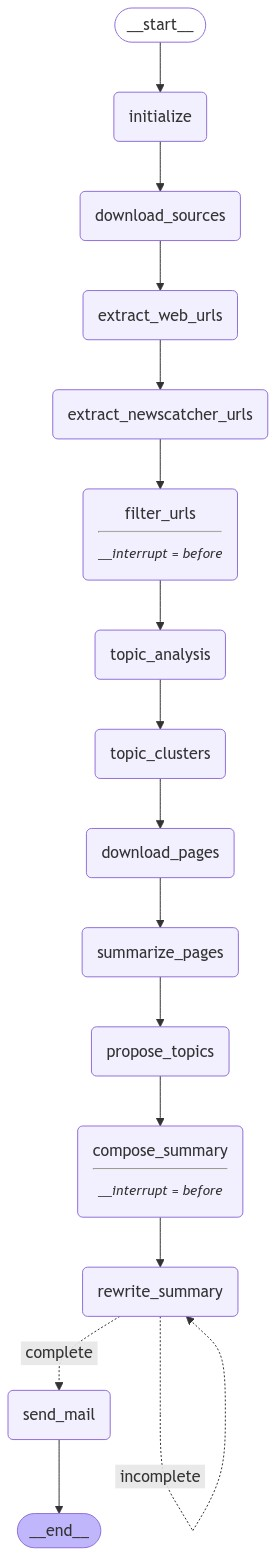

In [42]:
do_download = False
# before_date = ''
before_date="2024-11-11 08:00:00"

# initial state# initial state
state = AgentState(
    {'AIdf': None,
    'before_date': before_date,
    'do_download': do_download,
    'sources': None,
    'sources_reverse': None,
    'bullets': '',
    'summary': '',
    'cluster_topics': [],
    'topics_str': '',
    'n_edits': 0,
    'edit_complete': False,
#     'messages': None
    }
)
# Configuration with thread ID for checkpointing
# Generate a random UUID
thread_id = uuid.uuid4().hex
config = {"configurable": {"thread_id": thread_id}}

log(f"Initializing with before_date={state.get('before_date')}, do_download={do_download}, thread_id={thread_id}")
lg_agent = Agent(state)
display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


In [43]:
config


{'configurable': {'thread_id': '4fc54e10b70a45ecaa872d4ce169e607'}}

In [44]:
state


{'AIdf': None,
 'before_date': '2024-11-11 08:00:00',
 'do_download': False,
 'sources': None,
 'sources_reverse': None,
 'bullets': '',
 'summary': '',
 'cluster_topics': [],
 'topics_str': '',
 'n_edits': 0,
 'edit_complete': False}

In [45]:
state = lg_agent.run(state, config)


2024-11-11 10:00:04,172 - AInewsbot - INFO - Initialized 17 items in sources from sources.yaml
2024-11-11 10:00:04,173 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ -> Ars Technica.html
2024-11-11 10:00:04,174 - AInewsbot - INFO - Bloomberg Tech -> https://www.bloomberg.com/ai -> Bloomberg Technology.html
2024-11-11 10:00:04,174 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business Insider Tech.html
2024-11-11 10:00:04,174 - AInewsbot - INFO - FT Tech -> https://www.ft.com/technology -> FT Technology.html
2024-11-11 10:00:04,175 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly AI.html
2024-11-11 10:00:04,175 - AInewsbot - INFO - 

['Ars Technica', 'Bloomberg Tech', 'Business Insider', 'FT Tech', 'Feedly AI', 'Google News', 'Hacker News', 'Hacker News 2', 'HackerNoon', 'NYT Tech', 'Reddit', 'Techmeme', 'The Register', 'The Verge', 'VentureBeat', 'WSJ Tech', 'WaPo Tech']
['Ars Technica', 'Bloomberg Tech', 'Business Insider', 'FT Tech', 'Feedly AI', 'Google News', 'Hacker News', 'Hacker News 2', 'HackerNoon', 'NYT Tech', 'Reddit', 'Techmeme', 'The Register', 'The Verge', 'VentureBeat', 'WSJ Tech', 'WaPo Tech']


2024-11-11 10:00:04,395 - AInewsbot - INFO - parse_file - found 162 raw links
2024-11-11 10:00:04,396 - AInewsbot - INFO - parse_file - found 64 filtered links
2024-11-11 10:00:04,397 - AInewsbot - INFO - 64 links found
2024-11-11 10:00:04,397 - AInewsbot - INFO - Hacker News -> htmldata/Hacker News Page 1 (11_11_2024 08_24_15 AM).html
2024-11-11 10:00:04,408 - AInewsbot - INFO - parse_file - found 258 raw links
2024-11-11 10:00:04,411 - AInewsbot - INFO - parse_file - found 26 filtered links
2024-11-11 10:00:04,412 - AInewsbot - INFO - 26 links found
2024-11-11 10:00:04,412 - AInewsbot - INFO - Hacker News 2 -> htmldata/Hacker News Page 2 (11_11_2024 08_24_25 AM).html
2024-11-11 10:00:04,423 - AInewsbot - INFO - parse_file - found 261 raw links
2024-11-11 10:00:04,426 - AInewsbot - INFO - parse_file - found 24 filtered links
2024-11-11 10:00:04,427 - AInewsbot - INFO - 24 links found
2024-11-11 10:00:04,427 - AInewsbot - INFO - HackerNoon -> htmldata/HackerNoon (11_11_2024 08_24_27 AM

,id
src,
Ars Technica,26
Bloomberg Tech,12
Business Insider,50
FT Tech,63
Feedly AI,32
Google News,64
Hacker News,26
Hacker News 2,24
HackerNoon,95


2024-11-11 10:00:04,858 - AInewsbot - INFO - Fetching top 100 stories matching Artificial Intelligence from Newscatcher


,id
src,
Ars Technica,26
Bloomberg Tech,12
Business Insider,50
FT Tech,63
Feedly AI,32
Google News,64
Hacker News,26
Hacker News 2,24
HackerNoon,95


In [47]:
# it stopped here because we compiled with interrupt_before=["filter_urls", "compose_summary",]
last_state = lg_agent.graph.get_state(config)
print(len(last_state.values["AIdf"]))
print(last_state.values.get("before_date", ''))
last_state.values.keys()



975


dict_keys(['AIdf', 'before_date', 'do_download', 'sources', 'sources_reverse', 'bullets', 'summary', 'cluster_topics', 'topics_str', 'n_edits', 'edit_complete'])

In [48]:
pd.DataFrame(last_state.values['AIdf']).groupby('src').count()

,id,title,url
src,,,
Ars Technica,26,26,26
Bloomberg Tech,12,12,12
Business Insider,50,50,50
FT Tech,63,63,63
Feedly AI,32,32,32
Google News,64,64,64
Hacker News,26,26,26
Hacker News 2,24,24,24
HackerNoon,95,95,95


In [49]:
# if something got a robot block, download manually and rerun from beginning
# if all OK, then proceed
# state=None proceeds from last state
last_state = lg_agent.graph.get_state(config)
state = lg_agent.run(None, config)


,id
src,
Ars Technica,26
Bloomberg Tech,12
Business Insider,50
FT Tech,63
Feedly AI,32
Google News,64
Hacker News,26
Hacker News 2,24
HackerNoon,95


2024-11-11 10:01:23,505 - AInewsbot - INFO - Querying SQLite with where_clause: WHERE timestamp < '2024-11-11 08:00:00'
2024-11-11 10:01:24,301 - AInewsbot - INFO - URLs in orig_df: 975
2024-11-11 10:01:24,303 - AInewsbot - INFO - Existing URLs in DB: 178668
2024-11-11 10:01:24,341 - AInewsbot - INFO - New URLs in df filtered by URL: 232
2024-11-11 10:01:24,435 - AInewsbot - INFO - Existing src+title: 13
2024-11-11 10:01:24,436 - AInewsbot - INFO - New URLs in df filtered by src+title: 219
2024-11-11 10:01:24,446 - AInewsbot - INFO - Found 212 unique new headlines
2024-11-11 10:01:24,451 - AInewsbot - INFO - Applying prompt to 5 pages using gpt-4o-mini
2024-11-11 10:01:24,451 - AInewsbot - INFO - sent 50 items 
2024-11-11 10:01:24,452 - AInewsbot - INFO - sent 50 items 
2024-11-11 10:01:24,452 - AInewsbot - INFO - sent 50 items 
2024-11-11 10:01:24,452 - AInewsbot - INFO - sent 50 items 
2024-11-11 10:01:24,452 - AInewsbot - INFO - sent 12 items 
2024-11-11 10:01:25,698 - AInewsbot - I

,id
src,
Ars Technica,1
Business Insider,1
Feedly AI,22
Google News,22
Hacker News 2,1
Newscatcher,22
Techmeme,1


2024-11-11 10:01:29,041 - AInewsbot - INFO - start free-form topic extraction
2024-11-11 10:01:29,042 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-11 10:01:29,043 - AInewsbot - INFO - sent 50 items 
2024-11-11 10:01:29,043 - AInewsbot - INFO - sent 20 items 
2024-11-11 10:01:32,194 - AInewsbot - INFO - got dict with 20 items 
2024-11-11 10:01:36,143 - AInewsbot - INFO - got dict with 50 items 
2024-11-11 10:01:36,147 - AInewsbot - INFO - Processed 70 responses.
2024-11-11 10:01:36,150 - AInewsbot - INFO - 70 free-form topics extracted
2024-11-11 10:01:36,154 - AInewsbot - INFO - ['x', 'microsoft', 'google', 'competition', 'africa', 'apple', 'chatgpt', 'ios 18.2', '2024', 'testing', 'stock market', 'palantir', 'investment', 'transformation', 'bytedance', 'video generator', 'ai app', 'china', 'ai chatbot', 'ai chips', 'moore threads', 'ipo', '2025', 'gemini', 'iphone', 'google maps', 'translators', 'language', 'nhs', 'doctors', 'openai', 'xai', 'talent acquis

2024-11-11 10:02:29,085 - AInewsbot - INFO - sent 50 items 
2024-11-11 10:02:29,087 - AInewsbot - INFO - sent 20 items 
2024-11-11 10:02:30,825 - AInewsbot - INFO - got dict with 20 items 
2024-11-11 10:02:32,726 - AInewsbot - INFO - got dict with 50 items 
2024-11-11 10:02:32,728 - AInewsbot - INFO - Processed 70 responses.
2024-11-11 10:02:32,729 - AInewsbot - INFO - Computer Vision, topic 16 of 100
2024-11-11 10:02:32,731 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-11 10:02:32,732 - AInewsbot - INFO - sent 50 items 
2024-11-11 10:02:32,734 - AInewsbot - INFO - sent 20 items 
2024-11-11 10:02:35,006 - AInewsbot - INFO - got dict with 20 items 
2024-11-11 10:02:36,355 - AInewsbot - INFO - got dict with 50 items 
2024-11-11 10:02:36,357 - AInewsbot - INFO - Processed 70 responses.
2024-11-11 10:02:36,357 - AInewsbot - INFO - Consciousness, topic 17 of 100
2024-11-11 10:02:36,358 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-11 1

2024-11-11 10:03:33,094 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-11 10:03:33,095 - AInewsbot - INFO - sent 50 items 
2024-11-11 10:03:33,097 - AInewsbot - INFO - sent 20 items 
2024-11-11 10:03:34,612 - AInewsbot - INFO - got dict with 20 items 
2024-11-11 10:03:36,499 - AInewsbot - INFO - got dict with 50 items 
2024-11-11 10:03:36,503 - AInewsbot - INFO - Processed 70 responses.
2024-11-11 10:03:36,504 - AInewsbot - INFO - Finance, topic 33 of 100
2024-11-11 10:03:36,506 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-11 10:03:36,508 - AInewsbot - INFO - sent 50 items 
2024-11-11 10:03:36,510 - AInewsbot - INFO - sent 20 items 
2024-11-11 10:03:38,468 - AInewsbot - INFO - got dict with 20 items 
2024-11-11 10:03:39,757 - AInewsbot - INFO - got dict with 50 items 
2024-11-11 10:03:39,761 - AInewsbot - INFO - Processed 70 responses.
2024-11-11 10:03:39,762 - AInewsbot - INFO - Fintech, topic 34 of 100
2024-11-11 10:03:39,765 - 

2024-11-11 10:04:40,902 - AInewsbot - INFO - Intellectual Property, topic 49 of 100
2024-11-11 10:04:40,903 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-11 10:04:40,905 - AInewsbot - INFO - sent 50 items 
2024-11-11 10:04:40,906 - AInewsbot - INFO - sent 20 items 
2024-11-11 10:04:42,600 - AInewsbot - INFO - got dict with 20 items 
2024-11-11 10:04:44,810 - AInewsbot - INFO - got dict with 50 items 
2024-11-11 10:04:44,812 - AInewsbot - INFO - Processed 70 responses.
2024-11-11 10:04:44,813 - AInewsbot - INFO - Internet of Things, topic 50 of 100
2024-11-11 10:04:44,814 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-11 10:04:44,816 - AInewsbot - INFO - sent 50 items 
2024-11-11 10:04:44,818 - AInewsbot - INFO - sent 20 items 
2024-11-11 10:04:46,477 - AInewsbot - INFO - got dict with 20 items 
2024-11-11 10:04:48,253 - AInewsbot - INFO - got dict with 50 items 
2024-11-11 10:04:48,256 - AInewsbot - INFO - Processed 70 responses.
2

2024-11-11 10:05:50,655 - AInewsbot - INFO - got dict with 50 items 
2024-11-11 10:05:50,659 - AInewsbot - INFO - Processed 70 responses.
2024-11-11 10:05:50,660 - AInewsbot - INFO - Policy and regulation, topic 66 of 100
2024-11-11 10:05:50,662 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-11 10:05:50,664 - AInewsbot - INFO - sent 50 items 
2024-11-11 10:05:50,665 - AInewsbot - INFO - sent 20 items 
2024-11-11 10:05:52,769 - AInewsbot - INFO - got dict with 20 items 
2024-11-11 10:05:54,509 - AInewsbot - INFO - got dict with 50 items 
2024-11-11 10:05:54,512 - AInewsbot - INFO - Processed 70 responses.
2024-11-11 10:05:54,513 - AInewsbot - INFO - Politics, topic 67 of 100
2024-11-11 10:05:54,514 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-11 10:05:54,516 - AInewsbot - INFO - sent 50 items 
2024-11-11 10:05:54,517 - AInewsbot - INFO - sent 20 items 
2024-11-11 10:05:56,399 - AInewsbot - INFO - got dict with 20 items 
2024-11-11 

2024-11-11 10:07:04,905 - AInewsbot - INFO - sent 50 items 
2024-11-11 10:07:04,906 - AInewsbot - INFO - sent 20 items 
2024-11-11 10:07:06,719 - AInewsbot - INFO - got dict with 20 items 
2024-11-11 10:07:08,380 - AInewsbot - INFO - got dict with 50 items 
2024-11-11 10:07:08,385 - AInewsbot - INFO - Processed 70 responses.
2024-11-11 10:07:08,386 - AInewsbot - INFO - Smart grid, topic 83 of 100
2024-11-11 10:07:08,388 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-11 10:07:08,389 - AInewsbot - INFO - sent 50 items 
2024-11-11 10:07:08,393 - AInewsbot - INFO - sent 20 items 
2024-11-11 10:07:09,892 - AInewsbot - INFO - got dict with 20 items 
2024-11-11 10:07:12,701 - AInewsbot - INFO - got dict with 50 items 
2024-11-11 10:07:12,704 - AInewsbot - INFO - Processed 70 responses.
2024-11-11 10:07:12,705 - AInewsbot - INFO - Society & Culture, topic 84 of 100
2024-11-11 10:07:12,707 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-11 10

2024-11-11 10:08:07,796 - AInewsbot - INFO - Virtual & Augmented Reality, topic 99 of 100
2024-11-11 10:08:07,798 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-11 10:08:07,800 - AInewsbot - INFO - sent 50 items 
2024-11-11 10:08:07,801 - AInewsbot - INFO - sent 20 items 
2024-11-11 10:08:09,209 - AInewsbot - INFO - got dict with 20 items 
2024-11-11 10:08:11,877 - AInewsbot - INFO - got dict with 50 items 
2024-11-11 10:08:11,879 - AInewsbot - INFO - Processed 70 responses.
2024-11-11 10:08:11,880 - AInewsbot - INFO - Virtual Assistants, topic 100 of 100
2024-11-11 10:08:11,881 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-11-11 10:08:11,882 - AInewsbot - INFO - sent 50 items 
2024-11-11 10:08:11,883 - AInewsbot - INFO - sent 20 items 
2024-11-11 10:08:13,746 - AInewsbot - INFO - got dict with 20 items 
2024-11-11 10:08:15,747 - AInewsbot - INFO - got dict with 50 items 
2024-11-11 10:08:15,750 - AInewsbot - INFO - Processed 70 respo

,id
src,
Ars Technica,1
Business Insider,1
Feedly AI,22
Google News,22
Hacker News 2,1
Newscatcher,22
Techmeme,1


2024-11-11 10:08:15,775 - AInewsbot - INFO - Fetching embeddings for 70 headlines
2024-11-11 10:08:16,339 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2024-11-11 10:08:16,486 - AInewsbot - INFO - Sort with nearest_neighbor_sort sort
2024-11-11 10:08:16,498 - AInewsbot - INFO - Load umap dimensionality reduction model
2024-11-11 10:08:17,193 - AInewsbot - INFO - Perform dimensionality reduction
2024-11-11 10:08:17,907 - AInewsbot - INFO - Cluster with DBSCAN


,id,title_topic_str
0,0,"Google Gemini App Now on the iPhone: How to Use Gemini Live (Topics: App Usage, Gemini, Gen AI, Google, Iphone, Language Models, Products, Speech Recognition & Synthesis, Virtual Assistants)"
1,1,"Google Gemini iOS App Spotted on App Store: Check out the Details (Topics: App Store, Details, Gemini, Gen AI, Google, Ios App, Language Models, Products, Speech Recognition & Synthesis, Virtual Assistants)"
2,2,"Standalone Google Gemini app spotted for iPhone with Gemini Live (Topics: Gemini, Gen AI, Google, Iphone, Language Models, Mobile Apps, Products, Science)"
3,3,"Googles upcoming Gemini AI app for iPhone was just uncovered (Topics: AI App, Gemini, Gen AI, Google, Iphone, Language Models, Products, Speech Recognition & Synthesis, Uncovered, Virtual Assistants)"
4,4,"Googles Android-exclusive Gemini Live could be about to launch on iPhone (Topics: Android, Gemini, Gen AI, Google, Iphone, Language Models, Launch, Products, Speech Recognition & Synthesis, Virtual Assistants)"


2024-11-11 10:08:18,669 - AInewsbot - INFO - {'topic_title': 'Google Gemini AI for iPhone'}
2024-11-11 10:08:18,671 - AInewsbot - INFO - I dub this cluster: Google Gemini AI for iPhone


,id,title_topic_str
5,5,"I've Been Using Apple Intelligence for Weeks, and One Feature Stands Out (Topics: Apple, Chatbots, Code Assistants, Cognitive Science, Features, Gen AI, Hardware, Language Models, Opinion, Products, Retrieval Augmented Generation, Review, Speech Recognition & Synthesis, User Experience, Virtual Assistants)"
6,6,"Apple Intelligence Features Like ChatGPT Hit iPhones in iOS 18.2 Beta (Topics: AI Features, Apple, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Gen AI, Hardware, Ios 18.2, Language Models, Products, Retrieval Augmented Generation, Smartphones, Speech Recognition & Synthesis, Virtual Assistants)"
7,7,"Heres When Apple Will Release iOS 18.2 Update For iPhone With ChatGPT Integration For Siri (Topics: Apple, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Gen AI, Hardware, Ios 18.2, Language Models, Products, Retrieval Augmented Generation, Siri, Speech Recognition & Synthesis, Update, Virtual Assistants)"


2024-11-11 10:08:19,166 - AInewsbot - INFO - {'topic_title': 'Apple AI and Chatbot Features'}
2024-11-11 10:08:19,167 - AInewsbot - INFO - I dub this cluster: Apple AI and Chatbot Features


,id,title_topic_str
8,8,"NHS doctors could spend more time with patients' thanks to AI helper (Topics: Assistants, Code Assistants, Cognitive Science, Customer Service, Doctors, Gen AI, Health & Fitness, Healthcare, Inequality, Job Automation, Jobs & Careerslabor Market, Nhs, Patient Care, Safety And Alignment, Science, Society & Culture, Uk, Virtual Assistants)"
9,9,"NHS doctors get AI assistant to listen to appointments and make notes (Topics: AI Assistant, Appointments, Code Assistants, Cognitive Science, Customer Service, Doctors, Gen AI, Health & Fitness, Healthcare, Job Automation, Jobs & Careerslabor Market, Nhs, Note-Taking, Privacy, Privacy & Surveillance, Safety And Alignment, Science, Society & Culture, Speech Recognition & Synthesis, Uk, Virtual Assistants)"
10,10,"Georgia lawmakers study ways AI is reshaping the way hospitals provide care ahead of 2025 session (Topics: 2025, Cognitive Science, Ethics, Gen AI, Georgia, Governance, Health & Fitness, Healthcare, Hospitals, Inequality, Job Automation, Lawmakers, Legal Issues, Policy And Regulation, Politics, Safety And Alignment, Science, Society & Culture)"


2024-11-11 10:08:19,647 - AInewsbot - INFO - {'topic_title': 'AI in Healthcare'}
2024-11-11 10:08:19,648 - AInewsbot - INFO - I dub this cluster: AI in Healthcare


,id,title_topic_str
11,11,"US-sanctioned Moore Threads, Chinas AI chip unicorn, moves closer to possible IPO (Topics: AI Chips, China, Economics, Finance, Funding, Gen AI, Hardware, Ipo, Ipos, Moore Threads, Policy And Regulation, Politics, Products, Sanctions, Science, Semiconductor Chips, Stocks, Venture Capital)"
12,12,"US to TSMC: Halt AI chip shipments to China (Topics: AI Chips, China, Economics, Finance, Gen AI, Governance, Hardware, Military, Policy And Regulation, Politics, Products, Safety And Alignment, Science, Semiconductor Chips, Shipments, Taiwan, Trade Policy, Tsmc, Us)"
13,13,"US Said to Have Ordered TSMC to Halt AI Chips Shipments to China (Topics: AI Chips, China, Economics, Finance, Gen AI, Governance, Hardware, Military, Policy And Regulation, Politics, Products, Safety And Alignment, Science, Semiconductor Chips, Shipments, Taiwan, Trade Policy, Tsmc, Us)"
14,14,"US-sanctioned Moore Threads, China's AI chip unicorn, moves closer to possible IPO (Topics: AI Chips, China, Economics, Finance, Funding, Gen AI, Hardware, Ipo, Ipos, Moore Threads, Policy And Regulation, Politics, Products, Sanctions, Science, Semiconductor Chips, Stocks, Venture Capital)"
15,15,"China's AI chip unicorn Moore Threads moves closer to possible IPO (Topics: AI Chips, China, Economics, Finance, Funding, Hardware, Ipo, Ipos, Moore Threads, Semiconductor Chips, Stocks, Unicorn, Venture Capital)"


2024-11-11 10:08:20,214 - AInewsbot - INFO - {'topic_title': 'AI Chips and China'}
2024-11-11 10:08:20,215 - AInewsbot - INFO - I dub this cluster: AI Chips and China


,id,title_topic_str
16,16,"X Offers Free Grok AI Plan to Select Users: Check If You're Eligible (Topics: AI Chatbot, Chatbots, Code Assistants, Deals, Eligibility, Free Plan, Gen AI, Grok, Language Models, Products, Science, Virtual Assistants, X)"
17,17,"X is testing a free version of AI chatbot Grok (Topics: AI Chatbot, Chatbots, Code Assistants, Deals, Gen AI, Grok, Language Models, Products, Science, Testing, Virtual Assistants, X)"
18,18,"xAI Unveils a New API Service for Grok Models (Topics: Api Service, Chatbots, Code Assistants, Development, Gen AI, Grok Models, Language Models, Products, Science, Virtual Assistants, Xai)"
19,19,"X Experiments With Free Access to its Grok AI Chatbot (Topics: AI Chatbot, Chatbots, Code Assistants, Experimentation, Gen AI, Grok, Language Models, Products, Science, Virtual Assistants, X)"


2024-11-11 10:08:20,664 - AInewsbot - INFO - {'topic_title': 'Grok AI Chatbot Developments'}
2024-11-11 10:08:20,665 - AInewsbot - INFO - I dub this cluster: Grok AI Chatbot Developments


['Google Gemini AI for iPhone', 'Apple AI and Chatbot Features', 'AI in Healthcare', 'AI Chips and China', 'Grok AI Chatbot Developments']


Google Gemini AI for iPhone

Apple AI and Chatbot Features

AI in Healthcare

AI Chips and China

Grok AI Chatbot Developments

2024-11-11 10:08:20,698 - AInewsbot - INFO - Queuing URLs for scraping
2024-11-11 10:08:20,702 - AInewsbot - INFO - fetching 70 pages using 4 browsers
2024-11-11 10:08:20,703 - AInewsbot - INFO - get_driver - 26494 Initializing webdriver
2024-11-11 10:08:20,703 - AInewsbot - INFO - get_driver - 26494 Initializing webdriver
2024-11-11 10:08:20,704 - AInewsbot - INFO - get_driver - 26494 Initializing webdriver
2024-11-11 10:08:20,704 - AInewsbot - INFO - get_driver - 26494 Initializing webdriver
2024-11-11 10:08:39,416 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-11-11 10:08:39,416 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-11-11 10:08:39,416 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-11-11 10:08:39,417 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-11-11 10:08:39,417 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-11-11 10:08:39,418 - AInewsbot - INFO - get_driver - Ini

2024-11-11 10:09:24,039 - AInewsbot - INFO - Processing page 9: https://www.yahoo.com/news/nhs-doctors-ai-assistant-listen-062100051.html
2024-11-11 10:09:24,042 - AInewsbot - INFO - get_url(https://www.yahoo.com/news/nhs-doctors-ai-assistant-listen-062100051.html) - starting get_url https://www.yahoo.com/news/nhs-doctors-ai-assistant-listen-062100051.html
2024-11-11 10:09:24,047 - AInewsbot - INFO - Processing page 10: https://www.yahoo.com/news/georgia-lawmakers-study-ways-ai-060031639.html
2024-11-11 10:09:24,086 - AInewsbot - INFO - get_url(https://www.yahoo.com/news/georgia-lawmakers-study-ways-ai-060031639.html) - starting get_url https://www.yahoo.com/news/georgia-lawmakers-study-ways-ai-060031639.html
2024-11-11 10:09:24,114 - AInewsbot - INFO - Processing page 11: https://www.scmp.com/tech/tech-war/article/3286061/us-sanctioned-moore-threads-chinas-ai-chip-unicorn-moves-closer-possible-ipo
2024-11-11 10:09:24,122 - AInewsbot - INFO - get_url(https://www.scmp.com/tech/tech-war/

2024-11-11 10:09:25,880 - AInewsbot - INFO - get_url(https://arstechnica.com/ai/2024/11/how-a-stubborn-computer-scientist-accidentally-launched-the-deep-learning-boom/) - starting get_url https://arstechnica.com/ai/2024/11/how-a-stubborn-computer-scientist-accidentally-launched-the-deep-learning-boom/
2024-11-11 10:09:25,880 - AInewsbot - INFO - Processing page 25: https://news.google.com/read/CBMi2AFBVV95cUxNZzVRWEk0SUIyNzZUaVVpdVFyQkJZOHRJcndjQnpMbnFmSzNoVkJETlM4OTBTMHRIU3oyWmlNUGV0dUxtdC1rXzFYSmRmRTdwRGw3WWxOS0lXRnBBOU8wOFhWVENtMUtyM25aSW5BRHBpTk45SE1NYlRfbksyQWgtZWYyaEhrZ2tadTkwS3FidDFXS1VCU010UFJGTlZGb0dncnMxOUdYcVZWYmxXWXJmZ3ZRQS1OYVFZTWdyV3VZa2dhSVlaOThNYkItSWJGVmlYbkNLUXd2Z1I
2024-11-11 10:09:25,881 - AInewsbot - INFO - get_url(https://news.google.com/read/CBMi2AFBVV95cUxNZzVRWEk0SUIyNzZUaVVpdVFyQkJZOHRJcndjQnpMbnFmSzNoVkJETlM4OTBTMHRIU3oyWmlNUGV0dUxtdC1rXzFYSmRmRTdwRGw3WWxOS0lXRnBBOU8wOFhWVENtMUtyM25aSW5BRHBpTk45SE1NYlRfbksyQWgtZWYyaEhrZ2tadTkwS3FidDFXS1VCU010UFJGTlZGb0dncnMxO

2024-11-11 10:09:27,759 - AInewsbot - INFO - Processing page 37: https://news.yahoo.com/news/finance/news/better-artificial-intelligence-stock-palantir-233000494.html
2024-11-11 10:09:27,760 - AInewsbot - INFO - get_url(https://news.yahoo.com/news/finance/news/better-artificial-intelligence-stock-palantir-233000494.html) - starting get_url https://news.yahoo.com/news/finance/news/better-artificial-intelligence-stock-palantir-233000494.html
2024-11-11 10:09:27,760 - AInewsbot - INFO - Processing page 38: https://www.technologyreview.com/2024/11/11/1106762/africa-ai-barriers/
2024-11-11 10:09:27,761 - AInewsbot - INFO - get_url(https://www.technologyreview.com/2024/11/11/1106762/africa-ai-barriers/) - starting get_url https://www.technologyreview.com/2024/11/11/1106762/africa-ai-barriers/
2024-11-11 10:09:27,762 - AInewsbot - INFO - Processing page 39: https://www.theguardian.com/uk-news/2024/nov/11/ai-tool-could-influence-home-office-immigration-decisions-critics-say
2024-11-11 10:09:27

2024-11-11 10:09:27,768 - AInewsbot - INFO - Processing page 51: https://finance.yahoo.com/news/microsoft-corporation-msft-ken-fisher-192024421.html
2024-11-11 10:09:27,770 - AInewsbot - INFO - get_url(https://finance.yahoo.com/news/microsoft-corporation-msft-ken-fisher-192024421.html) - starting get_url https://finance.yahoo.com/news/microsoft-corporation-msft-ken-fisher-192024421.html
2024-11-11 10:09:27,771 - AInewsbot - INFO - Processing page 52: https://www.itpro.com/business/business-strategy/execs-are-happy-to-let-ai-make-decisions-for-them-and-its-got-it-workers-worried
2024-11-11 10:09:27,771 - AInewsbot - INFO - get_url(https://www.itpro.com/business/business-strategy/execs-are-happy-to-let-ai-make-decisions-for-them-and-its-got-it-workers-worried) - starting get_url https://www.itpro.com/business/business-strategy/execs-are-happy-to-let-ai-make-decisions-for-them-and-its-got-it-workers-worried
2024-11-11 10:09:27,771 - AInewsbot - INFO - Processing page 53: https://news.goog

2024-11-11 10:09:27,785 - AInewsbot - INFO - Processing page 66: https://finance.yahoo.com/news/finvolution-showcases-ai-powered-credit-070800651.html
2024-11-11 10:09:27,786 - AInewsbot - INFO - get_url(https://finance.yahoo.com/news/finvolution-showcases-ai-powered-credit-070800651.html) - starting get_url https://finance.yahoo.com/news/finvolution-showcases-ai-powered-credit-070800651.html
2024-11-11 10:09:27,787 - AInewsbot - INFO - Processing page 67: https://news.google.com/read/CBMiwgFBVV95cUxPSlplbk0wektPTjk0TVFfUzZrNFQ4NnowbWVldEMyNjVhdGdKOXdnVVlDVjdWTU9KRDd3VWRDQnc5emFWX3pSVmQyX0N5RkVLdG0zN3BGdzlWSVN0ZUV0NGg0Qy0wdWt2OGUxUjhISUwtYU9YaURtTXpuMHpXdkFMSXExMDQxVTRGNGx0c2ZpWDVxRmdoSkVmNm83R1U3Nm5KcGZtYkYxQmRRWTNrOEZnaXlxY19RR0RUOXBJWkd1RlFrdw
2024-11-11 10:09:27,788 - AInewsbot - INFO - get_url(https://news.google.com/read/CBMiwgFBVV95cUxPSlplbk0wektPTjk0TVFfUzZrNFQ4NnowbWVldEMyNjVhdGdKOXdnVVlDVjdWTU9KRDd3VWRDQnc5emFWX3pSVmQyX0N5RkVLdG0zN3BGdzlWSVN0ZUV0NGg0Qy0wdWt2OGUxUjhISUwtYU9Ya

Google Gemini AI for iPhone

Apple AI and Chatbot Features

AI in Healthcare

AI Chips and China

Grok AI Chatbot Developments

2024-11-11 10:09:43,012 - AInewsbot - INFO - Starting summarize
2024-11-11 10:09:43,054 - AInewsbot - INFO - fetch_all_summaries - Page title: iPhone 101: How to Use Google's AI Gemini Live Assistant
Social card title: Gemini Live: Step-by-Step Guide on How to Use on the iPhone
Social card description: Gemini app with Gemini Live integration arrives on the iPhone. Here's how to use the conversational AI assistant on your lock screen & Live Activity.

2024-11-11 10:09:43,132 - AInewsbot - INFO - fetch_all_summaries - Page title: Google Gemini iOS App Spotted on App Store: Check out the Details | MySmartPrice
Social card title: Google Gemini iOS App Spotted on App Store: Check out the Details | MySmartPrice
Social card description: The Google Gemini iOS app has been spotted on the Apple App store. It includes support for Gemini Live features. Currently, the app is under testing in a few select regions.

2024-11-11 10:09:43,165 - AInewsbot - INFO - fetch_all_summaries - Page title: Standa

2024-11-11 10:09:44,227 - AInewsbot - INFO - fetch_all_summaries - Page title: What the brain can teach artificial neural networks | The Transmitter: Neuroscience News and Perspectives
Social card title: What the brain can teach artificial neural networks
Social card description: The brain offers valuable lessons to artificial neural networks to boost their data and energy efficiency, flexibility and more.

2024-11-11 10:09:44,256 - AInewsbot - INFO - fetch_all_summaries - Page title: Near Protocol Unveils Plans For Largest Open-Source AI Model - The Pinnacle Gazette
Social card title: Near Protocol Unveils Plans For Largest Open-Source AI Model
Social card description: Near Protocol is set to revolutionize the artificial intelligence (AI) scene with its ambitious announcement made during the opening day of the Redacted conference…

2024-11-11 10:09:44,277 - AInewsbot - INFO - fetch_all_summaries - Page title: Randy Travis’s beautiful baritone was lost. AI helped him sing again. - The 

2024-11-11 10:09:45,383 - AInewsbot - INFO - fetch_all_summaries - Page title: ‘It gets more and more confused’: can AI replace translators? | Books | The Guardian
Social card title: ‘It gets more and more confused’: can AI replace translators?
Social card description: A Dutch publisher has announced that it will use AI to translate some of its books – but those in the industry are worried about the consequences if this becomes the norm

2024-11-11 10:09:45,395 - AInewsbot - INFO - fetch_all_summaries - Page title: wsj.com

2024-11-11 10:09:45,397 - trafilatura.core - WARNING - discarding data: None
2024-11-11 10:09:45,407 - AInewsbot - INFO - fetch_all_summaries - Page title: AI-generated image of Sydney Opera House's 'underground' level fools Facebook, X users
Social card title: AI-generated image of Sydney Opera House's 'underground' level fools Facebook, X users
Social card description: The Sydney Opera House represents a breakthrough in modern architecture and has become a symbol 

2024-11-11 10:09:46,273 - AInewsbot - INFO - fetch_all_summaries - Page title: What OpenAI can teach us about leadership and innovation - Fast Company
Social card title: What OpenAI’s 'brain drain' can teach us about leadership and innovation
Social card description: The departure of OpenAI's Mira Murati and Miles Brundage demonstrate the importance of leadership and innovation.

2024-11-11 10:09:46,300 - AInewsbot - INFO - fetch_all_summaries - Page title: Is ChatGPT-5 Showing Signs of Diminishing Returns? - Geeky Gadgets
Social card title: ChatGPT-5 Exhibiting Diminishing Returns is AI Progress Slowing Down?
Social card description: Discover why AI progress is slowing and what this means for the future of technology and innovation. ChatGPT-5 is apparently exhibiting signs

2024-11-11 10:09:46,328 - AInewsbot - INFO - fetch_all_summaries - Page title: AI-generated images threaten science — here’s how researchers hope to spot them
Social card title: AI-generated images threaten science

[1. Google Gemini App Now on the iPhone: How to Use Gemini Live - Google News](https://news.google.com/read/CBMicEFVX3lxTE5UR1FoOGF3c0lFRFcwNGtkT2FRWkIwcExXTl8tbXZSUFM1N3doczVEcEwxdTBQeDF5djRzOUNNWWpSMDdxVVFGZkhKdFVWb0lNS2wtbEdJOTlBWEFtVl94cDVMREhYdkR5NnJOZkN2dFg)  

 Google Gemini AI for iPhone, App Usage, Gemini, Gen AI, Google, Iphone, Language Models, Products, Speech Recognition & Synthesis, Virtual Assistants  

- Google has released a dedicated Gemini app for iPhone users, allowing access to the Gemini Live AI assistant similar to the version available on Android.
- The Gemini app features support for Live Activity and lock screen integration, enhancing user interaction compared to the Google app.
- Availability of the Gemini app is rolling out on the App Store, with some users already able to download it. 



[2. Google Gemini iOS App Spotted on App Store: Check out the Details - Google News](https://news.google.com/read/CBMilgFBVV95cUxORm05Umd1UGM1OUhPVDFuVXBHc29DS211LURNMjFYMU14UHRKWW10Q1NpRDBRLXNCZTlCTlN2MFdDbVYzbFBZOHFkRzlETjdyblQxaE1Ma2ViQkVuRWRMX3E3NjZvYmg5LTRlcld1NVVFLWxpSUQzV2hNWWV4SnJRclotbFNnSnM2b2lUZzBTZ3JpYVNiN2fSAZsBQVVfeXFMTWZqR1JOZW1jcWFMcm96bzM5T2thSURtRjhWZzlDazZaVmRuaVE3Y3luamNpMVozQUJ0U2ZtZlhxUmc4dk5TOWgxN0dJdXZSbzBqVk0yT1NBTGFLaDlURnNuN3k4VFpxeWx5OWdsRzhlbGItZWh6aWFremVNMGdJZzhMM1BEUTlOdE5ESjM4eExqT3FObDRwU2NrbTQ)  

 Google Gemini AI for iPhone, App Store, Details, Gemini, Gen AI, Google, Ios App, Language Models, Products, Speech Recognition & Synthesis, Virtual Assistants  

- The Google Gemini iOS app has been spotted on the App Store, currently available for testing in select regions like the Philippines, featuring AI capabilities such as image generation and voice conversations.
- It offers a standalone alternative to Apple's Siri and includes the Gemini Live feature for real-time conversations and contextual responses, which are not available in the existing integration within the Google app.
- An official launch timeline is yet to be announced, and while the app supports modern Gemini AI models, subscription pricing may be higher on Apple devices. 



[3. Standalone Google Gemini app spotted for iPhone with Gemini Live - Google News](https://news.google.com/read/CBMia0FVX3lxTE5HVTkyNDl5UUR2TW5qdm4wN1UwUjVocGxZQ1N6c2Z4a1BaeENFUTJqMUw4NXhpa2xTbGxLejdIOTNvNkw5MzNBekdSdGZudG1qNk4zSTU2TmNjQ3ZCenhHdnBnSjNFSXZNOFZj)  

 Google Gemini AI for iPhone, Gemini, Gen AI, Google, Iphone, Language Models, Mobile Apps, Products, Science  

- A standalone "Google Gemini" app has been spotted on the App Store for iPhones, allowing access to Gemini Live features that were previously integrated into the Google app.
- The app is currently only available to one user in the Philippines, suggesting that Google may be testing it in select regions before a broader release.
- Users can expect improved functionality and faster updates with the standalone app, though it does not yet match the UI experience of its Android counterpart. 



[4. Googles upcoming Gemini AI app for iPhone was just uncovered - BGR](https://bgr.com/tech/googles-upcoming-gemini-ai-app-for-iphone-was-just-uncovered/)  

 Google Gemini AI for iPhone, AI App, Gemini, Gen AI, Google, Iphone, Language Models, Products, Speech Recognition & Synthesis, Uncovered, Virtual Assistants  

- Google is testing a standalone Gemini app for iPhone in select markets, featuring Gemini Live support for direct interaction with the AI chatbot.  
- The app has been spotted in the Philippines but is not yet available in the US App Store, and its rollout in Europe is uncertain.  
- If integrated into Apple Intelligence, Gemini might be limited to newer iPhone models as it won’t be supported on older devices. 



[5. Googles Android-exclusive Gemini Live could be about to launch on iPhone - Google News](https://news.google.com/read/CBMizAFBVV95cUxPMFd5cmN1Ykg5REgyVWRsTkxjYl91bXJlWVpDNXZmeGJnVUJ2Sy04WjBsall1S05KM2FKNHVvbzZaV0xpcjVrS3NLRkxlVENPejd3MkM4VFJaczl6ZlNuamJlUndNd0xibTNiQ0tuaGc0WDFTcExscTBCcXlyV1VMQ1pqYXlfUzZzdXlCM2tHdk91MlR2SVI0V0NfV3BFSmxrMUtJWm1HRzA2Y0NkVUNZQWVvVEVhQnVxTDd3b3gyLUFJOG9vVWZ5cEdMbDA)  

 Google Gemini AI for iPhone, Android, Gemini, Gen AI, Google, Iphone, Language Models, Launch, Products, Speech Recognition & Synthesis, Virtual Assistants  

- A Google Gemini app has reportedly appeared on the App Store in the Philippines, suggesting a potential launch of the Gemini Live feature on iPhone.
- The app allows iPhone users to access Gemini Live, an advanced AI voice bot previously exclusive to Android devices.
- There is currently no confirmation on when the app will be available worldwide, leaving its availability in other regions like the UK, US, and Australia uncertain. 



[6. I've Been Using Apple Intelligence for Weeks, and One Feature Stands Out - CNET](https://www.cnet.com/tech/mobile/ive-been-using-apple-intelligence-for-weeks-and-one-feature-stands-out)  

 Apple AI and Chatbot Features, Apple, Chatbots, Code Assistants, Cognitive Science, Features, Gen AI, Hardware, Language Models, Opinion, Products, Retrieval Augmented Generation, Review, Speech Recognition & Synthesis, User Experience, Virtual Assistants  

- Apple's iOS 18.1 update introduced a notable feature called Message Summaries, which helps users quickly catch up on incoming texts and other notifications.
- While the feature adds convenience, it struggles with understanding sarcasm and context, leading to occasional misinterpretations.
- Message summaries are seen as a positive advancement in passive AI, enhancing communication but not yet reliable enough to replace human judgment. 



[7. Apple Intelligence Features Like ChatGPT Hit iPhones in iOS 18.2 Beta - Google News](https://news.google.com/read/CBMipgFBVV95cUxPY3FFclhzeFNnRHF1QlRxYmRBZ1d6ZG9lTndHNEVLSWdpZllkTzdSYXB5RzBuTUQwYnBnMmthd2daZ2c0QTZSS2REbGFsWENiR18xd3hvZWZtaUIwQ1d5MXRkSHkwc18yQlNKN1RyNTcxYmlTSktsYXkwRzFQS2t3bUdiOUNiSmVqdFVTNUZQZGNiRUdNZ3FFYTUxVFY3RzZrNEs3YXRR)  

 Apple AI and Chatbot Features, AI Features, Apple, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Gen AI, Hardware, Ios 18.2, Language Models, Products, Retrieval Augmented Generation, Smartphones, Speech Recognition & Synthesis, Virtual Assistants  

- Apple has launched the beta version of its generative AI, Apple Intelligence, in iOS 18.2, iPadOS 18.2, and macOS Sequoia 15.2, including features like GenMoji and ChatGPT integration for Siri.
- The AI tools focus on writing, images, and enhanced Siri functionalities, such as understanding personal context and providing more natural interactions.
- Apple Intelligence is currently available for iPhone 15 Pro and later models, and iPads and Macs with M1 chips, aiming for a broader release in Fall 2023. 



[8. Heres When Apple Will Release iOS 18.2 Update For iPhone With ChatGPT Integration For Siri - Google News](https://news.google.com/read/CBMiVkFVX3lxTE44cmlCdk96T3YtV05jeWhpYXdYSXJwLVhQOW1pRnM2a3FkZi1LT1Y2QjkyaTRvekM3VkFzblNOM3V5UDM0a085WkNuODUzX0t0X3dnLVhB0gFbQVVfeXFMTTBpZTd6QVl5SjFwZlZKYmtsUmpNUU82ZFFId2s1eVIwYlVTZXVUMG9DUVZ5Z1VqMXdGR3hWLXNWTGl3a2NBWGJaMXZtSDVuaGF0TW5jR3hxbUh0dw)  

 Apple AI and Chatbot Features, Apple, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Gen AI, Hardware, Ios 18.2, Language Models, Products, Retrieval Augmented Generation, Siri, Speech Recognition & Synthesis, Update, Virtual Assistants  

- Apple is set to release the iOS 18.2 update with ChatGPT integration for Siri on December 2nd, 2023.
- The update will initially be available only to developers, with a public rollout planned for the first week of December.
- iOS 18.2 will include major updates and new features related to Apple's AI service, Apple Intelligence, particularly for iPhone 15 Pro and newer models. 



[9. NHS doctors could spend more time with patients' thanks to AI helper - Yahoo News UK](https://uk.news.yahoo.com/nhs-doctors-could-spend-more-000100806.html)  

 AI in Healthcare, Assistants, Code Assistants, Cognitive Science, Customer Service, Doctors, Gen AI, Health & Fitness, Healthcare, Inequality, Job Automation, Jobs & Careerslabor Market, Nhs, Patient Care, Safety And Alignment, Science, Society & Culture, Uk, Virtual Assistants  

- The text details Yahoo's use of cookies for site functionality, user authentication, security measures, and usage measurement.
- It describes options for users to accept or reject cookie usage and customize their privacy settings.
- It offers information on accessing further details in Yahoo's privacy and cookie policies. 



[10. NHS doctors get AI assistant to listen to appointments and make notes - Yahoo](https://www.yahoo.com/news/nhs-doctors-ai-assistant-listen-062100051.html)  

 AI in Healthcare, AI Assistant, Appointments, Code Assistants, Cognitive Science, Customer Service, Doctors, Gen AI, Health & Fitness, Healthcare, Job Automation, Jobs & Careerslabor Market, Nhs, Note-Taking, Privacy, Privacy & Surveillance, Safety And Alignment, Science, Society & Culture, Speech Recognition & Synthesis, Uk, Virtual Assistants  

- NHS doctors are testing an AI assistant named Tortus that listens to patient appointments and generates notes, allowing clinicians to focus more on patient interaction.
- The trial, led by Great Ormond Street Hospital, includes around 5,000 patient assessments across various NHS settings in London, aiming to improve efficiency and reduce administrative burdens.
- The technology utilizes ambient voice technology to accurately capture medical discussions while ensuring patient data security through practices like immediate data deletion. 



[11. Georgia lawmakers study ways AI is reshaping the way hospitals provide care ahead of 2025 session - Yahoo](https://www.yahoo.com/news/georgia-lawmakers-study-ways-ai-060031639.html)  

 AI in Healthcare, 2025, Cognitive Science, Ethics, Gen AI, Georgia, Governance, Health & Fitness, Healthcare, Hospitals, Inequality, Job Automation, Lawmakers, Legal Issues, Policy And Regulation, Politics, Safety And Alignment, Science, Society & Culture  

- Georgia lawmakers are exploring how AI can enhance hospital care, including technologies that predict patient falls and facilitate quicker reviews of medical images.
- Concerns were raised about privacy, patient choice regarding AI in treatment, and potential biases in AI algorithms, leading to discussions on necessary policy adjustments.
- Upcoming legislative recommendations are expected from the AI committees, focusing on both healthcare implications and broader AI-related issues in various sectors. 



[12. US-sanctioned Moore Threads, Chinas AI chip unicorn, moves closer to possible IPO - South China Morning Post](https://www.scmp.com/tech/tech-war/article/3286061/us-sanctioned-moore-threads-chinas-ai-chip-unicorn-moves-closer-possible-ipo)  

 AI Chips and China, AI Chips, China, Economics, Finance, Funding, Gen AI, Hardware, Ipo, Ipos, Moore Threads, Policy And Regulation, Politics, Products, Sanctions, Science, Semiconductor Chips, Stocks, Venture Capital  

- Moore Threads, a Chinese AI chip designer founded by a former Nvidia executive, has transformed into a joint-stock company and is preparing for a potential IPO following a significant increase in its capital base to 330 million yuan.
- The company has attracted over US\\$800 million in funding from various investors, including major firms like ByteDance and Tencent, and recently raised over 2 billion yuan in a Series B+ funding round.
- Despite US sanctions affecting their operations, Moore Threads is pivoting towards AI accelerators to meet rising demand, having launched its new GPU and AI accelerator designed for large model training. 



[13. US to TSMC: Halt AI chip shipments to China - Fortune](https://fortune.com/2024/11/11/us-to-tsmc-halt-ai-chip-shipments-to-china/)  

 AI Chips and China, AI Chips, China, Economics, Finance, Gen AI, Governance, Hardware, Military, Policy And Regulation, Politics, Products, Safety And Alignment, Science, Semiconductor Chips, Shipments, Taiwan, Trade Policy, Tsmc, Us  

- The U.S. has imposed export restrictions on TSMC to halt advanced AI chip shipments to China, following a trade violation involving Huawei.
- Swiggy's \\$1.4 billion IPO in India has garnered significant investor interest, positioning it as the second-largest IPO of the year despite ongoing profitability concerns.
- Chegg's business is struggling due to competition from ChatGPT, resulting in a 99% drop in share price and a substantial loss of subscribers. 



[14. US Said to Have Ordered TSMC to Halt AI Chips Shipments to China - www.gadgets360.com](https://www.gadgets360.com/ai/news/us-order-tsmc-halt-ai-chip-shipments-china-6991729)  

 AI Chips and China, AI Chips, China, Economics, Finance, Gen AI, Governance, Hardware, Military, Policy And Regulation, Politics, Products, Safety And Alignment, Science, Semiconductor Chips, Shipments, Taiwan, Trade Policy, Tsmc, Us  

- The US has ordered TSMC to halt shipments of advanced chips, particularly those used in AI applications, to Chinese customers starting Monday due to concerns about export control violations, particularly involving Huawei.
- The Department of Commerce communicated restrictions on chips of seven nanometers or more that can power AI hardware, highlighting a new clampdown on tech exports to China amidst ongoing regulatory scrutiny.
- TSMC is complying with the order and has notified clients of the suspension, as lawmakers express concerns over the effectiveness of current export control measures. 



[15. US-sanctioned Moore Threads, China's AI chip unicorn, moves closer to possible IPO - Yahoo Finance](https://finance.yahoo.com/news/us-sanctioned-moore-threads-chinas-093000821.html)  

 AI Chips and China, AI Chips, China, Economics, Finance, Funding, Gen AI, Hardware, Ipo, Ipos, Moore Threads, Policy And Regulation, Politics, Products, Sanctions, Science, Semiconductor Chips, Stocks, Venture Capital  

- Moore Threads Technology, a Chinese AI chip designer, has transformed into a joint-stock company and raised its capital base to 330 million yuan, indicating a potential initial public offering (IPO).
- The company has attracted substantial funding, including over 2 billion yuan recently, and secured investments from major players like ByteDance and Tencent, amid increasing US tech restrictions.
- If Moore Threads proceeds with its IPO, it will join other domestic rivals, though it faces challenges due to US sanctions that limit access to essential chip manufacturing services. 



[16. China's AI chip unicorn Moore Threads moves closer to possible IPO - South China Morning Post](https://www.scmp.com/tech/tech-war/article/3286061/us-sanctioned-moore-threads-chinas-ai-chip-unicorn-moves-closer-possible-ipo)  

 AI Chips and China, AI Chips, China, Economics, Finance, Funding, Hardware, Ipo, Ipos, Moore Threads, Semiconductor Chips, Stocks, Unicorn, Venture Capital  

- Moore Threads Technology, a Chinese AI chip designer, has transitioned to a joint-stock company and is positioning itself for an IPO, despite US tech sanctions impacting its operations.
- The company secured over 2 billion yuan in recent funding, boosting its valuation to 77.42 billion yuan and attracting interest from various private and government investors amid China's push for chip self-sufficiency.
- Moore Threads, along with rivals Biren Technology and Enflame, is navigating challenges after being added to the US Entity List, which restricts access to global foundries while they continue to develop AI-specific chips. 



[17. X Offers Free Grok AI Plan to Select Users: Check If You're Eligible - Tech.co](https://tech.co/news/x-offers-free-grok-ai-plan)  

 Grok AI Chatbot Developments, AI Chatbot, Chatbots, Code Assistants, Deals, Eligibility, Free Plan, Gen AI, Grok, Language Models, Products, Science, Virtual Assistants, X  

- X is launching a free version of its AI chatbot, Grok, but it's currently available only to select users in New Zealand, with plans for broader rollout.
- Grok's free plan has limitations, allowing only 10 queries every two hours and three image analyses per day, aiming to attract users while encouraging Premium sign-ups.
- Compared to other free chatbots like ChatGPT and Gemini, Grok offers real-time information from X and fewer restrictions, though its query limits may deter some potential users. 



[18. X is testing a free version of AI chatbot Grok - Google News](https://news.google.com/read/CBMiiAFBVV95cUxPUjFmRzljRVJEdE54UWhzTmIwb0J5Q2k0MkF1ZnhOb0plVVpMT0E5bk9DMkg2emllSTlHalBOcEQtSGhVa0NUMkRRa0FadlQyV1RXUlRtaW5QSFQwQkI3MGpiaXNpdFpmRmJnYnhlTTA1clJTV0luQkdQblF3aGZaREw4Tk5qU0ZL)  

 Grok AI Chatbot Developments, AI Chatbot, Chatbots, Code Assistants, Deals, Gen AI, Grok, Language Models, Products, Science, Testing, Virtual Assistants, X  

- X is testing a free version of its AI chatbot Grok for users in New Zealand, after previously limiting access to premium users.
- Users have a capped usage limit: 10 queries per two hours for the Grok-2 model, 20 queries for the Grok-2 mini model, and three image analyses per day.
- This move aims to broaden Grok’s user base and enhance feedback to compete with other AI models like ChatGPT and Claude. 



[19. xAI Unveils a New API Service for Grok Models - Google News](https://news.google.com/read/CBMiXEFVX3lxTE1EelBKQi1LRjV1WFF1T3hBVFhrb0JfV0ppX2VtYmxrRFc0R1N3WXVmNDh1Ums5QTI2bnBQd2V0NzZaZUU2bkRMTHVSdnBhV2pRblBhREN0Z1h1Z1F0)  

 Grok AI Chatbot Developments, Api Service, Chatbots, Code Assistants, Development, Gen AI, Grok Models, Language Models, Products, Science, Virtual Assistants, Xai  

- xAI has launched a public beta for its API service, allowing developers to integrate its Grok models into applications, with the service currently accessible only in the us-east region.
- The xAI API includes features for API key creation, team management, and supports JavaScript and Python SDKs, but initial feedback highlights concerns about pricing and performance.
- Grok-beta's pricing is higher compared to OpenAI's models, with Grok-beta charging \\$5 for 131,072 tokens input and \\$15 for output, while GPT-4o charges \\$2.50 and \\$10 for 1 million tokens, respectively. 



[20. X Experiments With Free Access to its Grok AI Chatbot - Google News](https://news.google.com/read/CBMioAFBVV95cUxPYk1Vd2g3dGh6TWhtSWF2NFIwWGxCMV9YbWRDcUhZQm5SdnBsRnlUSDBpSW9iLTVHOWN1LUhzd1l3NUN5ci02TW9yRW4tdkZsdzR5SmdhaGE5dUFMVExoNi1VWnhONlNpZFVTSkZlQmljRU9BcDh4QWpQZ3R1X0dKb0FaWk83WjNjMlN0dzZiZTZSWnh0V2Rud3hJbVVWMzlD)  

 Grok AI Chatbot Developments, AI Chatbot, Chatbots, Code Assistants, Experimentation, Gen AI, Grok, Language Models, Products, Science, Virtual Assistants, X  

- X is developing a freemium version of its Grok AI chatbot to allow broader access for non-paying users, as Grok is currently limited to only 1.3 million Premium subscribers.
- Increasing Grok's usage may help X Corp secure further investment for its xAI project, which has already raised \\$6 billion and aims to compete with other AI companies.
- Elon Musk's potential new role in the Trump administration could create conflicts regarding his business interests in AI and foreign partnerships, particularly as xAI collaborates with figures linked to foreign investment. 



[21. What the brain can teach artificial neural networks - The Transmitter](https://www.thetransmitter.org/neuroai/what-the-brain-can-teach-artificial-neural-networks/)  

 Artificial Neural Networks, Brain, Brain-Computer Interfaces, Cognitive Science, Consciousness, Gen AI, Language Models, Neuromorphic Computing, Reinforcement Learning, Science  

- The integration of neuroscience insights into artificial intelligence aims to improve data and energy efficiency, as well as flexibility in artificial neural networks (ANNs).
- Current AI systems require excessive training data and consume much more energy than the human brain, highlighting the potential for learning from the brain's efficient computational strategies and genomic encoding.
- AI systems struggle with flexibility and multi-objective balancing, while biological systems excel in these areas, indicating a need for further exploration of how neurobiology can inform AI development. 



[22. Near Protocol Unveils Plans For Largest Open-Source AI Model - Google News](https://news.google.com/read/CBMilwFBVV95cUxQQk9fQXdWdWpVdGJhdE5vdElHRUg0ckpsSjIzdmh6ZFhVcGJaS1JVb0dIUjkxam5NWEdLZ3JDUVNuakhOM1BtRzZxaFl3S1BVNzZiWGVIZnJ2RURKcm9pQ0p4TnEwY05wMjJKcHdQUllpcGM4cnlvTWFOOUFKbXRhNC1SM01FVlpTU3E3TUxsQjdIeDBBaXlR)  

 AI Model, Gen AI, Language Models, Near Protocol, Open Source, Open-Source, Plans, Products  

- Near Protocol announced plans to develop the world's largest open-source AI model with 1.4 trillion parameters, significantly surpassing existing models like Meta's Llama.
- The project will leverage crowdsourced contributions through a newly established Near AI Research hub, democratizing AI development and fostering innovation.
- Edward Snowden emphasized the importance of decentralized AI technologies at the conference, highlighting concerns about centralized control and advocating for digital sovereignty in AI advancements. 



[23. Randy Traviss beautiful baritone was lost. AI helped him sing again. - Google News](https://news.google.com/read/CBMiqwFBVV95cUxNSE9EYTVaaFFSeER3ZXIzeTFEVS1uemthbFJuU1VlUjNtOGotc2RXWndnbk0ya0FjUlFQbUZnRHRfOE5ySEVnTlhTdGhKTkx5T0h1bU1mN3hFd25XTzltN09hay1ZSGJlVElablpYNnBHV2JWMkl4UkpWcHFwdTJlWnpMckhHZ0lpLURIekp3Z1VvdjRBU0Zpd2dRNmlRWjZORDNCMTR0Q1djYkE)  

 Baritone, Entertainment, Gen AI, Music, Randy Travis, Rehabilitation, Society & Culture, Speech Recognition & Synthesis  

- Country star Randy Travis lost his iconic baritone voice but has made a comeback with the help of AI technology.
- The new AI-generated song showcases the potential of technology in the music industry, despite some wariness surrounding it.
- Randy Travis's music continues to resonate with fans, highlighting his lasting impact on country music since the 1980s. 



[24. AI Start-Ups Are Battling Microsoft and Google. This Tech Conference Will Show Whos Winning. - Barron's](https://www.barrons.com/articles/ai-microsoft-amazon-meta-web-summit-1ac0a86f)  

 Competition, Gen AI, Google, Microsoft, Startups, Tech Conference, Venture Capital  

- No substantive news content is present in the text. 



[25. How a stubborn computer scientist accidentally launched the deep learning boom - Ars Technica](https://arstechnica.com/ai/2024/11/how-a-stubborn-computer-scientist-accidentally-launched-the-deep-learning-boom/)  

 Cognitive Science, Computer Scientist, Deep Learning, History, Science, Technology Boom  

- Prof. Fei-Fei Li faced skepticism while creating ImageNet, a groundbreaking dataset of 14 million labeled images, which was essential for advancing neural network research.
- The project challenged the existing belief that larger datasets would not significantly impact machine learning algorithms.
- The success of ImageNet contributed to revitalizing interest in neural networks, leading to the deep learning boom in AI. 



[26. OpenAI and others seek new path to smarter AI as current methods hit limitations - Google News](https://news.google.com/read/CBMi2AFBVV95cUxNZzVRWEk0SUIyNzZUaVVpdVFyQkJZOHRJcndjQnpMbnFmSzNoVkJETlM4OTBTMHRIU3oyWmlNUGV0dUxtdC1rXzFYSmRmRTdwRGw3WWxOS0lXRnBBOU8wOFhWVENtMUtyM25aSW5BRHBpTk45SE1NYlRfbksyQWgtZWYyaEhrZ2tadTkwS3FidDFXS1VCU010UFJGTlZGb0dncnMxOUdYcVZWYmxXWXJmZ3ZRQS1OYVFZTWdyV3VZa2dhSVlaOThNYkItSWJGVmlYbkNLUXd2Z1I)  

 Artificial General Intelligence, Cognitive Science, Gen AI, Language Models, Limitations, New Path, OpenAI, Safety And Alignment, Science  

- The provided text does not contain any substantive news content. 



[27. If robots become our translators, we risk a cultural catastrophe - Google News](https://news.google.com/read/CBMihwFBVV95cUxPZm1hWVhfTUlZeEJGZnRiMDlZeWpGNXI3SEt3SWs5aW1xWUkxMzFOTlpvM29jSzR2ZVpOXzEwZEszYlhTYm1uZjB5cTgxVVNBbE5sWHBpVzFOVzRiSEU1WlBZLTR3N2YyT05pQTNrdjU1TVBLc3p6OEh5T20yM2JIX3Jjc08xOWPSAYwBQVVfeXFMTllGOTBTR2dQS2dEUUpxSGlxLUljQkw4alBfdERYdGxUSTJTcUtGU0syenBzUEtMTnk4VzF6dTltS3ItaC1qeGRxbEJnaFZ5dW5qaFlJOUQyX2Y4VTQ4T19ENUpoUzhTRTJ3WVhnSEpXT28xM0JXSG1iTU1fNWlWazVVSktjUzVXUFNJSnQ)  

 AI Doom, Bias And Fairness, Cultural Catastrophe, Disinformation, Ethics, Job Automation, Language, Opinion, Robots, Safety And Alignment, Society & Culture, Translators  

- The Dutch publisher Veen Bosch & Keuning is testing AI for translating English editions of Dutch novels, raising concerns among literary translators about the potential decline of creative translation practices.  
- Critics argue that AI lacks the capability to understand nuance, tone, and context, which are essential for artful translations, while the publishing industry increasingly prioritizes cost-cutting over literary quality.  
- A survey indicates that a significant percentage of translators have lost jobs to generative AI, leading to fears about the future of translation as an art form amidst growing reliance on technology. 



[28. Dutch publisher owned by Simon & Schuster to trial using AI for English-language translations - Google News](https://news.google.com/read/CBMixAFBVV95cUxNeWlSYVN3UnkzT2FIWEYzU19kSkJ1OU43MGh5aVZsY2FCMWlXaUhBdFZIQ3hFVXZqdTJGX2hqS041emJtR05yWVNwVWhSR2VBcmdZTmVoTXJ1N0t0WUk4a1pDZHYzZVpLaHVabldzOThOcmdOQUdFanZxZmVVNk1BSFJrVG14dkV2dnNZSGc0ZHVMS0swaFNwcmthU2wwYVpudGhaN05WbVBERWZkTGF4cHVfVUxjMEg3cS1LRlgzWWoxRXU5)  

 Authors & Writing, Books & Publishing, Dutch Publisher, English Translations, Gen AI, Language Models, Simon & Schuster, Speech Recognition & Synthesis, Testing  

- Dutch publisher Veen Bosch & Keuning, recently acquired by Simon & Schuster, plans to trial AI for translating some of its books into English, emphasizing human oversight in the process.
- Concerns have been raised by literary translators about the impact of AI on their jobs and income, highlighting the risk of low-quality translations affecting authors' original works.
- Simon & Schuster's recent acquisition aims to help the company access broader European markets, with no immediate plans for further expansion or implications identified in relation to the AI trial. 



[29. Tesserent's cyber security predictions for 2025  rise of social engineering cyber-attacks fuelled by AI and more attacks on critical infrastructure' - itwire.com](http://itwire.com/guest-articles/guest-research/tesserent’s-cyber-security-predictions-for-2025-–-‘rise-of-social-engineering-cyber-attacks-fuelled-by-ai-and-more-attacks-on-critical-infrastructure’.html)  

 AI Doom, Critical Infrastructure, Cybersecurity, Disinformation, Gen AI, Infrastructure, Predictions, Privacy, Privacy & Surveillance, Safety And Alignment, Science, Social Engineering, Tesserent  

- Tesserent's predictions for 2025 highlight a significant rise in social engineering attacks empowered by AI, as cyber-criminals leverage advanced tools for more convincing phishing attempts.
- There will be an increase in cyber-attacks targeting critical infrastructure in Australia, facilitated by AI, which will enable easier execution of these attacks and emphasize vulnerabilities in security practices.
- The cybersecurity landscape will face challenges in retaining talent, as both public and private sectors struggle to keep skilled professionals, leading to a trend of outsourcing cybersecurity tasks. 



[30. Jeff Bezos-Backed AI Startup Anthropic To Partner With Palantir, AWS For US Defense - Benzinga](https://www.benzinga.com/24/11/41871055/jeff-bezos-backed-anthropic-ai-startup-to-partner-with-palantir-and-aws-for-us-defense-following-meta-and-microsoft)  

 AI Startup, Anthropic, Aws, Economics, Ethics, Funding, Gen AI, Governance, Jeff Bezos, Legal Issues, Mergers And Acquisitions, Military, Palantir, Policy And Regulation, Politics, Privacy & Surveillance, Safety And Alignment, Stocks, Us Defense, Venture Capital  

- Anthropic has partnered with Amazon Web Services and Palantir to provide its Claude A.I. models to U.S. defense and intelligence agencies, focusing on tasks like data processing and document preparation.
- The move reflects a significant increase in AI-related federal contracts, which surged by 150% to \\$675 million from August 2022 to 2023, with the Department of Defense being a key player.
- Anthropic's A.I. usage policy restricts applications for disinformation and domestic surveillance, allowing contracts only with selected government entities for lawful foreign intelligence analysis. 



[31. Ollama Now Supports Llama 3.2 Vision - Analytics India Magazine](https://analyticsindiamag.com/ai-news-updates/ollama-now-supports-llama-3-2-vision/)  

 Computer Vision, Llama 3.2, Ollama, Products, Support, Vision  

- Ollama now supports Llama 3.2 vision, a multimodal LLM capable of image recognition and captioning, available in 11B and 90B sizes and integrated with OpenWeb UI.
- The recent release includes speed enhancements and the ability to import models from Safetensors without a Modelfile.
- A report highlighted six critical vulnerabilities in Ollama, with potential risks including model theft and Denial of Service attacks, despite recent patches being implemented. 



[32. Salesforce to Hire 1,000 People for Big AI Product Sales Push - slashdot.org](https://slashdot.org/story/24/11/10/1819213/salesforce-to-hire-1000-people-for-big-ai-product-sales-push)  

 Economics, Funding, Gen AI, Hiring, Job Automation, Jobs & Careerslabor Market, Product Sales, Products, Salesforce  

- Salesforce plans to hire over 1,000 workers to boost sales for its new generative AI product, Agentforce, which was launched recently and is receiving positive customer feedback.
- The company's pivot in AI strategy focuses on creating tools that can operate independently to manage tasks like customer support and sales.
- Agentforce is initially priced at around \\$2 per conversation, signaling Salesforce's aggressive approach in the growing AI market. 



[33. Palantir Technologies: Can This Supercharged Artificial Intelligence (AI) Stock Continue Crushing the Stock Market in 2025? - Yahoo Finance](https://finance.yahoo.com/news/palantir-technologies-supercharged-artificial-intelligence-064700976.html)  

 2025, Economics, Finance, Gen AI, Palantir Technologies, Stock Market, Stocks, Venture Capital  

- Palantir Technologies reported Q3 2024 revenue of \\$726 million, a 30% year-over-year increase, and adjusted earnings of \\$0.10 per share, exceeding analysts' expectations.
- The company has seen significant growth in its customer base, reaching 629 clients (up 39% from last year) and securing 104 deals worth over \\$1 million in the last quarter.
- Despite its impressive growth and a positive outlook for 2025, Palantir's stock is highly valued at 46 times sales, indicating potential risks associated with its elevated valuation. 



[34. Bairong's Full-Scenario AI Products Shine at the 2024 Hong Kong Fintech Week - Yahoo Finance](https://finance.yahoo.com/news/bairongs-full-scenario-ai-products-100000875.html)  

 2024, AI Products, Bairong, China, Economics, Finance, Fintech, Gen AI, Hong Kong, Products  

- Bairong showcased its full-scenario digital intelligence products at the 2024 Hong Kong Fintech Week, attracting over 30,000 industry leaders from more than 100 countries.
- The company's AI technology aims to transform financial institutions, enhancing operations in credit, insurance, and wealth management.
- Financial Secretary Paul Chan highlighted the role of AI in accelerating development in Hong Kong's financial services, with Bairong's Agent Builder platform leading the way. 



[35. Best AI chatbots of 2024 tried and tested here's how they compare - Tom's Guide](https://www.tomsguide.com/ai/best-ai-chatbots-of-2024-tried-and-tested-heres-how-they-compare)  

 2024, Chatbots, Comparison, Customer Service, Gen AI, Language Models, Products, Review, Testing, Virtual Assistants  

- The article reviews and compares the top AI chatbots of 2024, highlighting the unique strengths of each, such as ChatGPT for versatility, Microsoft Copilot for seamless integration, and Claude AI for problem-solving capabilities.
- ChatGPT stands out for its multifaceted applications, including advanced web browsing, image analysis, and supportive features, while Microsoft Copilot integrates deeply with Microsoft tools for enhanced productivity.
- Meta AI is recognized for its image generation features, making creativity accessible, while Google Gemini excels in conversational fluency and integrates well with Google's services for a personalized user experience. 



[36. ByteDance adds video generator to China's most popular AI app - South China Morning Post](https://www.scmp.com/tech/big-tech/article/3285886/bytedance-adds-video-generator-chinas-most-popular-ai-chatbot-doubao)  

 AI App, Bytedance, China, Gen AI, Products, Video Generator  

- ByteDance is enhancing its AI chatbot Doubao by introducing a video-generation feature that can transform text and images into realistic video clips.  
- The feature is currently being tested by a limited group of early adopters and boasts advanced camera movements and multiple artistic styles.  
- This development aims to strengthen Doubao's position in China's burgeoning generative AI market.   



[37. Bridging the talent gap: harnessing AI to transform the construction industry - TechRadar](https://www.techradar.com/pro/bridging-the-talent-gap-harnessing-ai-to-transform-the-construction-industry)  

 Construction Industry, Gen AI, Inequality, Infrastructure, Job Automation, Jobs & Careerslabor Market, Manufacturing, Supply Chain Optimization, Sustainability, Talent Gap, Transformation  

- AI is transforming the construction industry by improving design, planning, safety, and productivity while addressing the skills gap caused by an aging workforce and high attrition rates.
- Nearly two-thirds of construction leaders are incorporating AI into their operations, with 36% citing it as a crucial tool to supplement workforce skills and enhance performance.
- Effective implementation of AI requires a solid data strategy; challenges like data fragmentation hinder adoption, but companies can benefit from centralized data management systems. 



[38. Better Artificial Intelligence Stock: Palantir vs. Microsoft - Yahoo News](https://news.yahoo.com/news/finance/news/better-artificial-intelligence-stock-palantir-233000494.html)  

 Economics, Finance, Gen AI, Investment, Microsoft, Palantir, Stock Market, Stocks  

- Palantir Technologies has seen a significant stock increase of over 170% in the past year, benefiting from government contracts and generative AI services, but its valuations are considered overheated at 186 times next year's earnings.
- Microsoft has experienced steady growth under CEO Satya Nadella, with a revenue CAGR of 14% and a more reasonable valuation at 27 times next year's earnings, largely driven by its investments in AI and cloud services.
- Analysts recommend Microsoft as the better investment compared to Palantir due to its balanced growth outlook and more sustainable valuations amidst the expanding AI market. 



[39. A bold AI movement is underway in Africabut it is being held up - Technology Review](https://www.technologyreview.com/2024/11/11/1106762/africa-ai-barriers/)  

 Africa, Challenges, Gen AI, Inequality, Society & Culture, Technology Movement  

- Africa faces challenges in becoming a major player in AI due to inadequate funding, poor infrastructure, and regulatory conflicts, despite having a youthful population and potential for growth in the sector.
- The continent is making strides in AI applications tailored to local needs, with successes like agricultural diagnostics and healthcare tools, but remains hindered by limited local investment and language barriers in AI development.
- A fragmented approach to AI strategy among African nations complicates efforts, as only a few have established formal policies, leading to tensions over who influences the future of AI in Africa. 



[40. AI tool could influence Home Office immigration decisions, critics say - The Guardian](https://www.theguardian.com/uk-news/2024/nov/11/ai-tool-could-influence-home-office-immigration-decisions-critics-say)  

 Bias And Fairness, Critics, Ethics, Governance, Home Office, Immigration, Inequality, Influence, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Safety And Alignment, Society & Culture, Uk  

- Campaigners criticize a Home Office AI tool used for immigration enforcement, calling it a "robo-caseworker" that may lead to automated and unjust life-changing decisions for migrants.
- The AI system, operational since 2019-20, analyzes personal data to recommend immigration actions but lacks transparency, with critics arguing that officials may easily rubberstamp its recommendations without sufficient scrutiny.
- Concerns have been raised about potential biases and privacy invasions, as the system may increase data-sharing and surveillance of migrants, prompting calls for its withdrawal and greater accountability in government AI use. 



[41. It gets more and more confused: can AI replace translators? - Google News](https://news.google.com/read/CBMipgFBVV95cUxNNWNvSmhCVWdleElGYUZJOWgwQU1VMGdlQ01LblI0TDA5NjNRM0lYUHNaZTU0WlE0SzFGdloySWxGTGpJUEZCNUswTVNvTm1IYlNEUTRXd3JhRlFCM1hhNEZqQ1YwYWU2WnIzRmVJa3AxTVU1VlJwOWFGUGJlSlY3U1RmWTRRWVRFcVVQSkNXZUVkZmJxcHRNc21sbnhHNVRxVGlIZGpn0gGmAUFVX3lxTE4zRVN2TkFScEFzYWZucWQ0bzBDYXd2Y0wxWnVoUjdGS2ZMQ2V5WXpXaVZhbGhGalJMTjhIYVFSYVZ6ZU50Z2txREM1TEJuNE9UUkVrT0VVZV9Qb2ZSWmpRMlNqLTVaV0NzM0JQM180b2RhanRLcGkycDhNZk9Pd2d0WTFNa1RuYXRLbzAwSnFVTmVaV0ptMWVmYk03RmlYSkw0OWtGdGc)  

 Confusion, Gen AI, Job Automation, Language, Opinion, Translators  

- Dutch publisher Veen Bosch & Keuning plans to use AI for translating commercial fiction, raising concerns among authors and translators about cultural sensitivity and quality.
- Many industry professionals argue that AI lacks the nuanced understanding necessary for literary translation, which involves more than just translating words.
- While AI translation may aid in certain scenarios, such as for minority languages or simple game localization, the limitations and risks associated with its use in more complex contexts remain significant. 



[42. From AI to Hardware Costs: Enterprise Tech Leaders Prepare for Trump 2.0 - The Wall Street Journal](https://www.wsj.com/articles/from-ai-to-hardware-costs-enterprise-tech-leaders-prepare-for-trump-2-0-18a5486c)  

 Enterprise Tech, Governance, Hardware, Hardware Costs, Policy And Regulation, Politics, Trump 2.0  

- No substantive news content available. 



[43. AI-generated image of Sydney Opera House's 'underground' level fools Facebook, X users - Yahoo](https://www.yahoo.com/news/ai-generated-image-sydney-opera-084924309.html)  

 Art & Design, Computer Vision, Disinformation, Facebook, Gen AI, Image Generation, Social Media, Sydney Opera House, X  

- An AI-generated image of the Sydney Opera House depicting a multi-level underground level has circulated on social media in over a dozen countries, misleading users into thinking it was genuine.
- A spokesperson for the Sydney Opera House confirmed that no such underground chambers exist and stated that the image is not authentic.
- The image was first posted by a Facebook account specializing in AI-generated artwork, and comparisons with Google Maps confirm that the false image does not accurately represent the actual structure. 



[44. Claude AI's Visual Interpretation is Transforming Document Analysis - Geeky Gadgets](https://www.geeky-gadgets.com/claude-ai-visual-interpretation/)  

 Claude AI, Computer Vision, Document Analysis, Gen AI, Transformation, Visual Interpretation  

- Anthropic's Claude AI now features visual interpretation of PDFs, enhancing document analysis capabilities while introduce Hau 3.5 with increased pricing, indicating a shift towards premium models in AI.
- OpenAI's ChatGPT improves user interaction by acquiring chat.com for easier access and adding voice input functionality in its mobile app.
- The AI search market is evolving, with Google and ChatGPT focusing on balancing speed and accuracy, while generative game engines and enhanced AI video capabilities are transforming content creation. 



[45. Deckmatch uses AI to find and streamline deals for investors. Check out the 13-slide deck it used to raise \\$3.1 million. - Business Insider](https://www.businessinsider.com/deckmatch-pitch-deck-seed-funding-private-market-ai-2024-11)  

 Deals, Deckmatch, Economics, Finance, Funding, Fundraising, Gen AI, Investors, Mergers And Acquisitions, Presentation, Products, Recommendation Systems, Stocks, Supply Chain Optimization, Venture Capital  

- Deckmatch has raised \\$3.1 million in seed funding, led by Alliance VC and Luminar Ventures, to automate data processing for private market investors.
- The startup's platform uses AI to turn unstructured data from pitch decks into structured data, integrating it into enterprise tools and helping investors source similar deals.
- Deckmatch plans to use the new funding to enhance its research and development efforts after experiencing oversubscription in its funding round. 



[46. Google Maps gets an AI upgrade to compete with Apple - Google News](https://news.google.com/read/CBMiY0FVX3lxTE41WXFFZllibGxXN2lsWUg0dWJ4U056elRxY3hLTTluYXVoSE9JWk5GZUdTbE9ldzRFYjZnVnhIdnprNHVhOUhYM2sxb1NIMldFZGFJSWxnTDl6LUU3aG9Cb1FaTQ)  

 AI Upgrade, Apple, Competition, Customer Service, Gen AI, Google Maps, Lifestyle & Travel, Products, Transportation, Travel  

- Google is integrating its Gemini AI into Google Maps, enhancing the app’s capabilities to provide tailored recommendations and complex search responses.
- Users will be able to interact with Maps using conversational queries and receive specific suggestions for activities, parking options, and navigation.
- Waze will also benefit from AI upgrades, allowing for easier reporting of road conditions and improved communication for users. 



[47. NEAR Introduces NEAR AI at [REDACTED], Partners Infinex - Google News](https://news.google.com/read/CBMigwFBVV95cUxPaFliTGc1c0Q3ZzJsSU5iY200RXh4dERLa2hTNTdBdktkTzIyV1Zobl9NVFpxZjg2bHlJdEpBTEZjV0pvdlR5Skdmb21ra19JYk1jTkRKOF9QbXAtLTg0V1hpR3FZRmQ0QXNuTElvckR0MGZqekNpOXRRMTF0Mk9KY290UdIBiAFBVV95cUxQeGljc3RlTHdPZVNfd2NsQ2M1dGZaalE1Q2tKQlVxU2NlRHkxS3QzRVdDVnFIWmtBNzFlUE1WeVFXbm13bEp0dTBQU0RzaVZLcGg1blNLSnY2TFdiZm9qdGVmUzl1WXZLZXZKSkVTbklnRXcwd1V2N3BaUmJBcTFGQS1ieHp1ZGty)  

 Gen AI, Near, Near AI, Partnerships, Products  

- The NEAR Foundation has launched the alpha version of NEAR AI and partnered with Infinex to facilitate cross-chain transactions using NEAR Chain Signatures, enhancing AI accessibility in Web3.
- NEAR AI includes an assistant that prioritizes user privacy and ownership and supports various functionalities such as blockchain transactions and e-commerce, while an AI Research Hub promotes community-driven AI research.
- The partnership with Infinex allows users to manage transactions across multiple blockchains seamlessly, eliminating the need for native gas tokens and promoting self-custody of assets. 



[48. The Download: AI in Africa, and reporting in the age of Trump - Technology Review](https://www.technologyreview.com/2024/11/11/1106807/the-download-ai-in-africa-and-reporting-in-the-age-of-trump/)  

 Africa, Bias And Fairness, Disinformation, Gen AI, Media, Politics, Reporting, Science, Society & Culture, Trump  

- Africa faces challenges in developing its AI sector, including inadequate funding, poor infrastructure, and a lack of regulatory frameworks, despite having a young population and growing interest in technology.
- Canada has confirmed its first case of bird flu in a human, prompting investigations into the exposure while officials reassure that the public risk remains low.
- The U.S. defense industry anticipates significant growth following Trump's victory, with traditional weapons systems receiving AI enhancements. 



[49. Letters from readers: Students write about their love for pastries, the Olympics and AI - South China Morning Post](https://www.scmp.com/posties/kids/your-say/article/3285502/letters-readers-students-write-about-their-love-pastries-olympics-and-ai)  

 Authors & Writing, Food & Drink, Gen AI, Letters, Lifestyle & Travel, Olympics, Opinion, Pastries, Society & Culture, Sports, Students  

- Students shared their experiences and interests in letters, discussing topics such as pastries, the Olympics, and artificial intelligence.
- A 9-year-old highlighted the significance of the Bread Festival in Hong Kong and shared insights about French pastries and local baked goods.
- Another student expressed excitement about the Paris 2024 Olympics and discussed the impact of AI on art and education, emphasizing the need to maintain traditional artistic methods. 



[50. The fight for AI talent heats up in China, as tech employers boost pay - Yahoo Finance](https://finance.yahoo.com/news/fight-ai-talent-heats-china-093000988.html)  

 China, Economics, Employment, Finance, Gen AI, Inequality, Jobs & Careerslabor Market, Salary Increase, Science, Talent Acquisition, Technology Sector  

- A competitive race for AI talent is intensifying in China, with major tech companies offering high salaries to attract skilled professionals.
- Xiaomi is hosting a hiring session for AI experts, promising a streamlined application process for certain candidates to expedite hiring.
- Demand for AI specialists, particularly in natural language processing and deep learning, has surged significantly in 2023, with salaries for these roles far exceeding the average pay for IT workers. 



[51. Thomas Porricelli, Ian C. Ballon, Sam Sinai and Joe Nazarian Share Insights on the EvolvingArtificial IntelligenceLandscape - Los Angeles Times](https://www.latimes.com/business-insights/story/2024-11-11/thomas-porricelli-ian-c-ballon-sam-sinai-and-joe-nazarian-share-insights-on-the-evolving-artificial-intelligence-landscape)  

 Gen AI, Ian C. Ballon, Industry Insights, Joe Nazarian, Sam Sinai, Science, Thomas Porricelli  

- The discussion highlights the transformative impact of AI on businesses, emphasizing the need for careful planning, ethical considerations, and gradual implementation to address challenges like data governance and job displacement.
- Experts note divergent regulatory landscapes between the U.S. and Europe, which pose challenges for companies developing and deploying AI solutions, while emphasizing the importance of transparency and accountability in AI use.
- AI is reshaping industries, particularly in legal practices, by automating tasks and enhancing client engagement, thereby improving services and competitive advantage for businesses of all sizes. 



[52. Microsoft Corporation (MSFT): Ken Fisher's Top Tech Stock for AI and Cloud Dominance - Yahoo Finance](https://finance.yahoo.com/news/microsoft-corporation-msft-ken-fisher-192024421.html)  

 Cloud Dominance, Economics, Finance, Gen AI, Ken Fisher, Microsoft Corporation, Stocks  

- Ken Fisher identifies Microsoft Corporation (NASDAQ:MSFT) as a top stock for investment, driven by its advancements in artificial intelligence (AI) and cloud computing, particularly through the Azure platform and AI integration.
- Microsoft exceeded Q3 2024 earnings expectations with a normalized EPS of \\$3.30 and revenue of \\$65.59 billion, showcasing strong momentum and investor confidence ahead of its upcoming earnings report.
- Fisher predicts a market shift in which value stocks will begin to outperform growth stocks, notably amid expected central bank rate cuts benefiting value stocks while impacting growth stocks negatively. 



[53. Execs are happy to let AI make decisions for them, and its got IT workers worried - IT Pro](https://www.itpro.com/business/business-strategy/execs-are-happy-to-let-ai-make-decisions-for-them-and-its-got-it-workers-worried)  

 AI Doom, Bias And Fairness, Concerns, Decision Making, Ethics, Executives, Gen AI, Inequality, It Workers, Job Automation, Jobs & Careerslabor Market, Opinion, Privacy, Safety And Alignment  

- Over 60% of C-suite executives trust AI to make decisions without human oversight, while only half of IT decision makers share this confidence.
- A significant 70% of UK decision makers believe AI will positively impact revenue in the next year, with many indicating a willingness to bet on their organization's risk management abilities.
- Despite concerns about reliance on AI, IT leaders recognize its potential benefits, with 75% agreeing it allows for more strategic work and skill acquisition. 



[54. Google Maps Enhances Navigation With AI Innovations - Google News](https://news.google.com/read/CBMijAFBVV95cUxNaWlHNEx0Y3FkbkZ3QTR1TFFfNG5rNm41c2doZ1lfVW9yZDRybDZvWVhMWU9FSVJEOFNHdVdVU0tia2lKNG1TVzVScVA2djAwSGpscDUybGdvell5YzN0VTFQZHNNTXNLbi1GREFfOVdLQzhhOFk3a256RzVMUTRCNWJCdXNvMVF6NGxwag)  

 Customer Service, Enhancements, Gen AI, Google Maps, Lifestyle & Travel, Navigation, Products, Transportation, Travel  

- Google Maps is enhancing its navigation app with AI features powered by its Gemini chatbot, allowing for personalized and conversational queries about local activities and services.
- The update aims to improve user interaction and provide practical information like parking options and clearer navigation details, amidst increasing competition from Apple Maps.
- Additional features include a new visual representation of vehicles and plans for similar AI upgrades in the Waze app, ensuring a smoother user experience. 



[55. The fight for AI talent heats up in China - South China Morning Post](https://www.scmp.com/tech/tech-trends/article/3285878/fight-ai-talent-heats-china-tech-employers-boost-pay)  

 China, Gen AI, Jobs & Careerslabor Market, Science, Talent Acquisition, Technology Sector  

- A recruitment battle for AI talent is intensifying in China, with companies offering above-average salaries, particularly for natural language processing (NLP) experts whose demand surged by 111% in the first half of the year.
- Salaries for AI roles are significantly higher than the average IT salary, with NLP positions averaging 24,007 yuan per month and deep-learning roles averaging 26,279 yuan.
- Major cities like Beijing, Shenzhen, and Shanghai are leading in AI job creation, but there is concern that less affluent regions may fall behind due to limited resources for AI development. 



[56. ByteDance adds video generator to China's most popular AI chatbot Doubao - Yahoo Finance](https://uk.finance.yahoo.com/news/bytedance-adds-video-generator-chinas-093000339.html)  

 AI Chatbot, Bytedance, Chatbots, China, Customer Service, Doubao, Gen AI, Language Models, Products, Video Generator, Virtual Assistants  

- ByteDance is enhancing its AI chatbot Doubao with new video-generation capabilities, aiming to strengthen its position in the competitive Chinese generative AI market.
- Doubao operates on a large language model similar to that of ChatGPT, highlighting its potential as a significant player in the industry.
- The addition of video features reflects ByteDance's ambition to leverage its experience in short videos, particularly through its popular app TikTok. 



[57. xAI woos developers with \\$25/month worth of API credits, support for OpenAI, Anthropic SDKs - Google News](https://news.google.com/read/CBMitwFBVV95cUxQQlBTWjQxek1RejJaV2MydTM2OXY5ZmZYblMxRWVZSUdPczFsQnIwZ0ZwbXN1WkQzN1BXQ2JuTVNPZWNrWmN1TkFOUnFua0JlU1Q4c0FjMnhKSms1ZTV1NzJ5dWxHbTAxZ1MyY1c2V1JqdjBNMkw4UXJSa0pMaGhISnk1Q2ozVHlkdUhMTlJqNlAzQWNFbXp2bkp4YzBRajFIaXcxb2xiWm5BWDZaemQ2NlZvVnNHejA)  

 Anthropic Sdks, Api Credits, Code Assistants, Deals, Developers, Finance, Funding, Gen AI, Language Models, Open Source, OpenAI, Products, Science, Virtual Assistants, Xai  

- Elon Musk's xAI has announced the public launch of its API, offering \\$25 per month in free credits through the end of the year to attract developers.
- The xAI API pricing is higher than competitors like OpenAI and Anthropic, with developers only receiving limited usage from the free credits.
- A new Grok model is in development, including features like "function calling" and compatibility with OpenAI and Anthropic SDKs, with expectations of additional models being released soon. 



[58. The AI Machine Gun of the Future Is Already Here - Wired](https://www.wired.com/story/us-military-robot-drone-guns/)  

 AI Doom, Defense, Drones, Gen AI, Machine Gun, Military, Safety And Alignment, Science  

- The US military is testing an AI-enabled autonomous gun system named "Bullfrog" designed to counter the rising threat of low-cost adversary drones, demonstrating precision in targeting and shooting down drones more effectively than conventional methods.
- The Pentagon's Replicator initiative aims to enhance military drone and counter-drone capabilities, highlighting the need for affordable, efficient solutions against the drone threat landscape, which has escalated in recent conflicts.
- The Bullfrog could represent the first lethal autonomous weapon in the US military's arsenal, raising concerns about the implications of removing human operators from the engagement process. 



[59. What OpenAIs 'brain drain' can teach us about leadership and innovation - Fast Company](https://www.fastcompany.com/91225474/what-openais-brain-drain-can-teach-us-about-leadership-and-innovation)  

 Bias And Fairness, Brain Drain, Cognitive Science, Consciousness, Ethics, Gen AI, Innovation, Jobs & Careerslabor Market, Language Models, Leadership, Open Source, OpenAI, Opinion, Science, Society & Culture  

- The recent departures of OpenAI's CTO Mira Murati and AI safety advocate Miles Brundage highlight a troubling shift from a mission-driven organization to a market-driven one, risking the integrity and trust necessary for sustainable innovation.
- Disbanding the AGI Readiness team raises concerns regarding the oversight and safety of advanced AI systems, emphasizing the need for human input to address ethical and social issues.
- OpenAI's current leadership crisis illustrates the vital role of governance in technology development; without it, the company risks losing public trust and creating potentially harmful technologies. 



[60. ChatGPT-5 Exhibiting Diminishing Returns is AI Progress Slowing Down? - Geeky Gadgets](https://www.geeky-gadgets.com/chatgpt-5-development-challenges-and-opportunities/)  

 Chatbots, Chatgpt-5, Code Assistants, Cognitive Science, Diminishing Returns, Gen AI, Language Models, Opinion, Progress, Virtual Assistants  

- AI development, particularly for OpenAI’s language models like Orion and ChatGPT-5, is experiencing a slowdown due to issues with data quality, scarcity, and increasing training costs.
- Orion shows only marginal improvements over GPT-4, indicating a trend of diminishing returns in language model advancements.
- Enhancing data efficiency could provide a way to overcome current limitations and accelerate future AI progress, even as challenges in areas such as mathematical reasoning persist. 



[61. Research integrity specialists and scientific publishers raise concerns about the ease with which scientific data can be fabricated using generative AI tools - Nature](https://www.nature.com/articles/d41586-024-03542-8)  

 AI Doom, Authors & Writing, Bias And Fairness, Books & Publishing, Cognitive Science, Data Fabrication, Deepfakes, Disinformation, Ethics, Gen AI, Generative AI, Governance, Inequality, Intellectual Property, Language Models, Legal Issues, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Research Integrity, Retrieval Augmented Generation, Safety And Alignment, Science, Scientific Publishers, Society & Culture, Testing  

- The rise of generative AI poses a significant threat to scientific integrity by making it easier to create fake data, images, and manuscripts, complicating the efforts of integrity specialists to detect such fraud.
- While some journals allow AI-generated text, there is reluctance to accept AI-generated images or data as legitimate, raising concerns over the authenticity of published research.
- Technology companies are developing AI tools to identify AI-generated content, but challenges remain with the reliability of these tools, highlighting a growing need for transparent verification methods in scientific publishing. 



[62. Global companies urged to embrace AI to reach net zero targets - Tech Monitor](https://www.techmonitor.ai/digital-economy/ai-and-automation/global-companies-falling-short-on-net-zero-but-ai-offers-path-forward-report-finds)  

 Climate, Energy, Gen AI, Global Companies, Net Zero Targets, Sustainability  

- Only 16% of the world's largest companies are on track to meet net zero emissions by 2050, prompting a call for greater use of AI to enhance emissions reduction efforts. 
- While 52% of companies have reduced emissions since the Paris Agreement, only 37% have committed to full net zero targets, with 14% currently using AI for emissions reductions.
- The report outlines three scenarios for AI's impact on emissions, indicating that responsible scaling of AI technologies is crucial for maximizing their positives while addressing potential emissions growth from AI development. 



[63. Largest Book Publisher in the Netherlands Experiments with AI for English Translation - Google News](https://news.google.com/read/CBMiqAFBVV95cUxOTGFPNnZkdGpXQ0syRnBKUEhGbHZXdFkwXzdETnhUQnEwLXZfZUZfN2hsNEdHUXotNW5NTjN4M0t0VW5sNE1QWkpvSmpSejB1LV91S3NxdHR4QXhLRWl5SjZhMERGN1dMUFYyZEMwbVNZY3U4S2JCT29ScEQtbVMyNFFJTC1lczBONkRKa05JWW9UcVpPMlB6ajVDeEotTkRSWVZkQ09zS1A)  

 Authors & Writing, Books & Publishing, English Translation, Gen AI, Language Models, Largest Book Publisher, Netherlands, Speech Recognition & Synthesis, Testing  

- Veen Bosch & Keuning, the largest book publisher in the Netherlands, plans to experiment with AI translations for a limited number of Dutch fiction titles into English, focusing on commercial fiction with unlicensed rights.
- The move has raised concerns among translators regarding job security and quality of translations, with industry professionals warning about the potential displacement of human translators and decline in translation standards.
- Critics argue that AI translations could undermine the quality of literary works, with many preferring human translators due to the complexity and nuances of literary texts. 



[64. Terry Smith Shuns Nvidia Shares on Fears AI Hype Is Overblown - Google News](https://news.google.com/read/CBMisgFBVV95cUxNU1VVTDZWQjdXN29GdDE3dzZ1LUVOZVBUUXdXc2tCZ0pTYkNaWXJyeUZCUzdHd0pOZ0IzQTZDeDJVMS14WGtvQjRvQmtoSXNBTTJzaTdSUHFjcFgxMlhmTXZwcXQ5VlJ5M0JfTmpuNGdaZ21FUUlYRkxqNjhQVEZVT2V6QlJDNXhkbDlkTXhoWURWNE9VeE5nWGZBS1ZCR0ZaNHpOSmhGc0VaQzYyc3dkZ3d3)  

 AI Doom, Economics, Finance, Financial Analysis, Gen AI, Hardware, Investment, Nvidia, Opinion, Science, Semiconductor Chips, Stock Market, Stocks, Terry Smith  

- Fund manager Terry Smith criticizes Nvidia, claiming it lacks a predictable earnings stream and might lose its market dominance despite the stock’s tripling this year.
- Smith expresses skepticism about the sustainability of AI-related revenues, questioning whether companies will pay enough for AI to justify investments in technology.
- He notes potential competition from major users of Nvidia's chips, such as Microsoft and Amazon, who have a history of developing their own microprocessors. 



[65. Sources: Elon Musk's US government advisory role will be structured to ensure he keeps control of Tesla, X, xAI, and others by installing acolytes and allies (Financial Times) - Twitter](https://t.co/RKyC7XaqQ0)  

 Business Strategy, Elon Musk, Ethics, Finance, Governance, Government Advisory, Policy And Regulation, Politics, Safety And Alignment, Tesla, X, Xai  

- The article discusses a group of individuals connected to Elon Musk who are expected to influence potential government roles in a second Trump administration.
- Musk's allies are likely to advocate for reducing regulations that could affect his businesses.
- The focus is on how this "A-team" may shape policies to favor their interests. 



[66. Sick of turbulence? Future passenger planes could use AI to maintain a smooth in-flight experience on the fly - Live Science](https://www.livescience.com/technology/artificial-intelligence/sick-of-turbulence-future-passenger-planes-could-use-ai-to-maintain-a-smooth-in-flight-experience-on-the-fly)  

 Gen AI, In-Flight Experience, Lifestyle & Travel, Passenger Planes, Safety And Alignment, Science, Transportation, Travel, Turbulence  

- Scientists have developed an AI system named FALCON that can adjust aircraft flight parameters in real-time to mitigate turbulence effects, showing promise for smoother flights.
- FALCON uses reinforcement learning and Fourier methods to understand and model turbulence, successfully maintaining stability in a wind tunnel test within nine minutes.
- Future research aims to reduce the AI's learning time and improve prediction accuracy while addressing challenges related to diverse aircraft configurations and cybersecurity in data sharing. 



[67. FinVolution Showcases AI-Powered Credit Innovation at Singapore FinTech Festival 2024 - Yahoo Finance](https://finance.yahoo.com/news/finvolution-showcases-ai-powered-credit-070800651.html)  

 Credit Innovation, Economics, Finance, Fintech, Fintech Festival 2024, Finvolution, Gen AI, Products, Singapore  

- FinVolution Group showcased its AI-powered credit services at the Singapore FinTech Festival 2024, emphasizing advancements in data verification and fraud detection.
- COO Joseph Ruan highlighted the company's AI-driven strategies for risk management, utilizing over 50 risk models to provide accurate credit ratings and optimize pricing.
- The firm has developed a comprehensive e-KYC system and uses graph-based analysis to identify fraudulent activity, successfully preventing an estimated \\$3 million in annual losses. 



[68. First artwork painted by humanoid robot sells at auction  for a whopping \\$1 million - Google News](https://news.google.com/read/CBMiwgFBVV95cUxPSlplbk0wektPTjk0TVFfUzZrNFQ4NnowbWVldEMyNjVhdGdKOXdnVVlDVjdWTU9KRDd3VWRDQnc5emFWX3pSVmQyX0N5RkVLdG0zN3BGdzlWSVN0ZUV0NGg0Qy0wdWt2OGUxUjhISUwtYU9YaURtTXpuMHpXdkFMSXExMDQxVTRGNGx0c2ZpWDVxRmdoSkVmNm83R1U3Nm5KcGZtYkYxQmRRWTNrOEZnaXlxY19RR0RUOXBJWkd1RlFrdw)  

 \\$1 Million, Art & Design, Artwork, Auction, Entertainment, Hardware, Humanoid Robot, Intellectual Property, Robots, Society & Culture  

- The first artwork painted by a humanoid robot, Ai-Da, was sold at Sotheby's auction in New York for over \\$1 million, far exceeding the expected price of \\$180,000.
- The painting, titled "AI God," depicts mathematician Alan Turing and aims to stimulate discussion about AI's ethical and societal implications.
- Ai-Da, created by British gallerist Aidan Meller, is a symbol of the intersection between AI technology and modern art, having previously been exhibited at prestigious venues and events. 



[69. How AI technology can save historical photos - Mashable](https://sea.mashable.com/tech/35067/how-ai-technology-can-save-historical-photos)  

 Art & Design, Computer Vision, Gen AI, Historical Photos, History, Preservation, Science, Society & Culture  

- NVIDIA's RTX 40-Series GPUs enhance AI-powered photo restoration and upscaling, enabling both professionals and hobbyists to preserve historical images with improved clarity and detail.
- AI upscaling methods analyze textures and details in low-resolution images to create high-resolution versions, drastically improving image quality without losing authenticity.
- This technology benefits various sectors, such as museums and individual collectors, by allowing for better display and preservation of historical and personal images. 



[70. Heretic directors take swipe at AI in end credits: It might kill us all - Far Out Magazine](https://faroutmagazine.co.uk/heretic-directors-take-swipe-at-ai-in-end-credits-it-might-kill-us-all/)  

 AI Doom, Bias And Fairness, Cultural Impact, End Credits, Entertainment, Ethics, Film, Gen AI, Heretic, Hollywood, Job Automation, Opinion, Safety And Alignment, Society & Culture, Tv & Film & Movies  

- The directors of 'Heretic', Scott Beck and Bryan Woods, included a warning in the end credits about the dangers of generative AI, stating that "No generative AI was used in the making of this film."
- Woods criticized AI, describing it as "borderline theft" and expressed concern that it could replace human jobs in the arts and other sectors.
- Despite their criticism, other studios are increasingly investing in generative AI for film production, highlighting the urgency of the conversation around its impact. 



2024-11-11 10:09:49,764 - AInewsbot - INFO - Sending bullet points email


[Google Gemini App Now on the iPhone: How to Use Gemini Live - Google News](https://news.google.com/read/CBMicEFVX3lxTE5UR1FoOGF3c0lFRFcwNGtkT2FRWkIwcExXTl8tbXZSUFM1N3doczVEcEwxdTBQeDF5djRzOUNNWWpSMDdxVVFGZkhKdFVWb0lNS2wtbEdJOTlBWEFtVl94cDVMREhYdkR5NnJOZkN2dFg)

Topics: App Usage, Gemini, Gen AI, Google, Iphone, Language Models, Products, Speech Recognition & Synthesis, Virtual Assistants 

- Google has released a dedicated Gemini app for iPhone users, allowing access to the Gemini Live AI assistant similar to the version available on Android.
- The Gemini app features support for Live Activity and lock screen integration, enhancing user interaction compared to the Google app.
- Availability of the Gemini app is rolling out on the App Store, with some users already able to download it.



[Google Gemini iOS App Spotted on App Store: Check out the Details - Google News](https://news.google.com/read/CBMilgFBVV95cUxORm05Umd1UGM1OUhPVDFuVXBHc29DS211LURNMjFYMU14UHRKWW10Q1NpRDBRLXNCZTlCTlN2MFdDbVYzbFBZOHFkRzlETjdyblQxaE1Ma2ViQkVuRWRMX3E3NjZvYmg5LTRlcld1NVVFLWxpSUQzV2hNWWV4SnJRclotbFNnSnM2b2lUZzBTZ3JpYVNiN2fSAZsBQVVfeXFMTWZqR1JOZW1jcWFMcm96bzM5T2thSURtRjhWZzlDazZaVmRuaVE3Y3luamNpMVozQUJ0U2ZtZlhxUmc4dk5TOWgxN0dJdXZSbzBqVk0yT1NBTGFLaDlURnNuN3k4VFpxeWx5OWdsRzhlbGItZWh6aWFremVNMGdJZzhMM1BEUTlOdE5ESjM4eExqT3FObDRwU2NrbTQ)

Topics: App Store, Details, Gemini, Gen AI, Google, Ios App, Language Models, Products, Speech Recognition & Synthesis, Virtual Assistants 

- The Google Gemini iOS app has been spotted on the App Store, currently available for testing in select regions like the Philippines, featuring AI capabilities such as image generation and voice conversations.
- It offers a standalone alternative to Apple's Siri and includes the Gemini Live feature for real-time conversations and contextual responses, which are not available in the existing integration within the Google app.
- An official launch timeline is yet to be announced, and while the app supports modern Gemini AI models, subscription pricing may be higher on Apple devices.



[Standalone Google Gemini app spotted for iPhone with Gemini Live - Google News](https://news.google.com/read/CBMia0FVX3lxTE5HVTkyNDl5UUR2TW5qdm4wN1UwUjVocGxZQ1N6c2Z4a1BaeENFUTJqMUw4NXhpa2xTbGxLejdIOTNvNkw5MzNBekdSdGZudG1qNk4zSTU2TmNjQ3ZCenhHdnBnSjNFSXZNOFZj)

Topics: Gemini, Gen AI, Google, Iphone, Language Models, Mobile Apps, Products, Science 

- A standalone "Google Gemini" app has been spotted on the App Store for iPhones, allowing access to Gemini Live features that were previously integrated into the Google app.
- The app is currently only available to one user in the Philippines, suggesting that Google may be testing it in select regions before a broader release.
- Users can expect improved functionality and faster updates with the standalone app, though it does not yet match the UI experience of its Android counterpart.



[Googles upcoming Gemini AI app for iPhone was just uncovered - BGR](https://bgr.com/tech/googles-upcoming-gemini-ai-app-for-iphone-was-just-uncovered/)

Topics: AI App, Gemini, Gen AI, Google, Iphone, Language Models, Products, Speech Recognition & Synthesis, Uncovered, Virtual Assistants 

- Google is testing a standalone Gemini app for iPhone in select markets, featuring Gemini Live support for direct interaction with the AI chatbot.  
- The app has been spotted in the Philippines but is not yet available in the US App Store, and its rollout in Europe is uncertain.  
- If integrated into Apple Intelligence, Gemini might be limited to newer iPhone models as it won’t be supported on older devices.



[Googles Android-exclusive Gemini Live could be about to launch on iPhone - Google News](https://news.google.com/read/CBMizAFBVV95cUxPMFd5cmN1Ykg5REgyVWRsTkxjYl91bXJlWVpDNXZmeGJnVUJ2Sy04WjBsall1S05KM2FKNHVvbzZaV0xpcjVrS3NLRkxlVENPejd3MkM4VFJaczl6ZlNuamJlUndNd0xibTNiQ0tuaGc0WDFTcExscTBCcXlyV1VMQ1pqYXlfUzZzdXlCM2tHdk91MlR2SVI0V0NfV3BFSmxrMUtJWm1HRzA2Y0NkVUNZQWVvVEVhQnVxTDd3b3gyLUFJOG9vVWZ5cEdMbDA)

Topics: Android, Gemini, Gen AI, Google, Iphone, Language Models, Launch, Products, Speech Recognition & Synthesis, Virtual Assistants 

- A Google Gemini app has reportedly appeared on the App Store in the Philippines, suggesting a potential launch of the Gemini Live feature on iPhone.
- The app allows iPhone users to access Gemini Live, an advanced AI voice bot previously exclusive to Android devices.
- There is currently no confirmation on when the app will be available worldwide, leaving its availability in other regions like the UK, US, and Australia uncertain.



[I've Been Using Apple Intelligence for Weeks, and One Feature Stands Out - CNET](https://www.cnet.com/tech/mobile/ive-been-using-apple-intelligence-for-weeks-and-one-feature-stands-out)

Topics: Apple, Chatbots, Code Assistants, Cognitive Science, Features, Gen AI, Hardware, Language Models, Opinion, Products, Retrieval Augmented Generation, Review, Speech Recognition & Synthesis, User Experience, Virtual Assistants 

- Apple's iOS 18.1 update introduced a notable feature called Message Summaries, which helps users quickly catch up on incoming texts and other notifications.
- While the feature adds convenience, it struggles with understanding sarcasm and context, leading to occasional misinterpretations.
- Message summaries are seen as a positive advancement in passive AI, enhancing communication but not yet reliable enough to replace human judgment.



[Apple Intelligence Features Like ChatGPT Hit iPhones in iOS 18.2 Beta - Google News](https://news.google.com/read/CBMipgFBVV95cUxPY3FFclhzeFNnRHF1QlRxYmRBZ1d6ZG9lTndHNEVLSWdpZllkTzdSYXB5RzBuTUQwYnBnMmthd2daZ2c0QTZSS2REbGFsWENiR18xd3hvZWZtaUIwQ1d5MXRkSHkwc18yQlNKN1RyNTcxYmlTSktsYXkwRzFQS2t3bUdiOUNiSmVqdFVTNUZQZGNiRUdNZ3FFYTUxVFY3RzZrNEs3YXRR)

Topics: AI Features, Apple, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Gen AI, Hardware, Ios 18.2, Language Models, Products, Retrieval Augmented Generation, Smartphones, Speech Recognition & Synthesis, Virtual Assistants 

- Apple has launched the beta version of its generative AI, Apple Intelligence, in iOS 18.2, iPadOS 18.2, and macOS Sequoia 15.2, including features like GenMoji and ChatGPT integration for Siri.
- The AI tools focus on writing, images, and enhanced Siri functionalities, such as understanding personal context and providing more natural interactions.
- Apple Intelligence is currently available for iPhone 15 Pro and later models, and iPads and Macs with M1 chips, aiming for a broader release in Fall 2023.



[Heres When Apple Will Release iOS 18.2 Update For iPhone With ChatGPT Integration For Siri - Google News](https://news.google.com/read/CBMiVkFVX3lxTE44cmlCdk96T3YtV05jeWhpYXdYSXJwLVhQOW1pRnM2a3FkZi1LT1Y2QjkyaTRvekM3VkFzblNOM3V5UDM0a085WkNuODUzX0t0X3dnLVhB0gFbQVVfeXFMTTBpZTd6QVl5SjFwZlZKYmtsUmpNUU82ZFFId2s1eVIwYlVTZXVUMG9DUVZ5Z1VqMXdGR3hWLXNWTGl3a2NBWGJaMXZtSDVuaGF0TW5jR3hxbUh0dw)

Topics: Apple, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Gen AI, Hardware, Ios 18.2, Language Models, Products, Retrieval Augmented Generation, Siri, Speech Recognition & Synthesis, Update, Virtual Assistants 

- Apple is set to release the iOS 18.2 update with ChatGPT integration for Siri on December 2nd, 2023.
- The update will initially be available only to developers, with a public rollout planned for the first week of December.
- iOS 18.2 will include major updates and new features related to Apple's AI service, Apple Intelligence, particularly for iPhone 15 Pro and newer models.



[NHS doctors could spend more time with patients' thanks to AI helper - Yahoo News UK](https://uk.news.yahoo.com/nhs-doctors-could-spend-more-000100806.html)

Topics: Assistants, Code Assistants, Cognitive Science, Customer Service, Doctors, Gen AI, Health & Fitness, Healthcare, Inequality, Job Automation, Jobs & Careerslabor Market, Nhs, Patient Care, Safety And Alignment, Science, Society & Culture, Uk, Virtual Assistants 

- The text details Yahoo's use of cookies for site functionality, user authentication, security measures, and usage measurement.
- It describes options for users to accept or reject cookie usage and customize their privacy settings.
- It offers information on accessing further details in Yahoo's privacy and cookie policies.



[NHS doctors get AI assistant to listen to appointments and make notes - Yahoo](https://www.yahoo.com/news/nhs-doctors-ai-assistant-listen-062100051.html)

Topics: AI Assistant, Appointments, Code Assistants, Cognitive Science, Customer Service, Doctors, Gen AI, Health & Fitness, Healthcare, Job Automation, Jobs & Careerslabor Market, Nhs, Note-Taking, Privacy, Privacy & Surveillance, Safety And Alignment, Science, Society & Culture, Speech Recognition & Synthesis, Uk, Virtual Assistants 

- NHS doctors are testing an AI assistant named Tortus that listens to patient appointments and generates notes, allowing clinicians to focus more on patient interaction.
- The trial, led by Great Ormond Street Hospital, includes around 5,000 patient assessments across various NHS settings in London, aiming to improve efficiency and reduce administrative burdens.
- The technology utilizes ambient voice technology to accurately capture medical discussions while ensuring patient data security through practices like immediate data deletion.



[Georgia lawmakers study ways AI is reshaping the way hospitals provide care ahead of 2025 session - Yahoo](https://www.yahoo.com/news/georgia-lawmakers-study-ways-ai-060031639.html)

Topics: 2025, Cognitive Science, Ethics, Gen AI, Georgia, Governance, Health & Fitness, Healthcare, Hospitals, Inequality, Job Automation, Lawmakers, Legal Issues, Policy And Regulation, Politics, Safety And Alignment, Science, Society & Culture 

- Georgia lawmakers are exploring how AI can enhance hospital care, including technologies that predict patient falls and facilitate quicker reviews of medical images.
- Concerns were raised about privacy, patient choice regarding AI in treatment, and potential biases in AI algorithms, leading to discussions on necessary policy adjustments.
- Upcoming legislative recommendations are expected from the AI committees, focusing on both healthcare implications and broader AI-related issues in various sectors.



[US-sanctioned Moore Threads, Chinas AI chip unicorn, moves closer to possible IPO - South China Morning Post](https://www.scmp.com/tech/tech-war/article/3286061/us-sanctioned-moore-threads-chinas-ai-chip-unicorn-moves-closer-possible-ipo)

Topics: AI Chips, China, Economics, Finance, Funding, Gen AI, Hardware, Ipo, Ipos, Moore Threads, Policy And Regulation, Politics, Products, Sanctions, Science, Semiconductor Chips, Stocks, Venture Capital 

- Moore Threads, a Chinese AI chip designer founded by a former Nvidia executive, has transformed into a joint-stock company and is preparing for a potential IPO following a significant increase in its capital base to 330 million yuan.
- The company has attracted over US\\$800 million in funding from various investors, including major firms like ByteDance and Tencent, and recently raised over 2 billion yuan in a Series B+ funding round.
- Despite US sanctions affecting their operations, Moore Threads is pivoting towards AI accelerators to meet rising demand, having launched its new GPU and AI accelerator designed for large model training.



[US to TSMC: Halt AI chip shipments to China - Fortune](https://fortune.com/2024/11/11/us-to-tsmc-halt-ai-chip-shipments-to-china/)

Topics: AI Chips, China, Economics, Finance, Gen AI, Governance, Hardware, Military, Policy And Regulation, Politics, Products, Safety And Alignment, Science, Semiconductor Chips, Shipments, Taiwan, Trade Policy, Tsmc, Us 

- The U.S. has imposed export restrictions on TSMC to halt advanced AI chip shipments to China, following a trade violation involving Huawei.
- Swiggy's \\$1.4 billion IPO in India has garnered significant investor interest, positioning it as the second-largest IPO of the year despite ongoing profitability concerns.
- Chegg's business is struggling due to competition from ChatGPT, resulting in a 99% drop in share price and a substantial loss of subscribers.



[US Said to Have Ordered TSMC to Halt AI Chips Shipments to China - www.gadgets360.com](https://www.gadgets360.com/ai/news/us-order-tsmc-halt-ai-chip-shipments-china-6991729)

Topics: AI Chips, China, Economics, Finance, Gen AI, Governance, Hardware, Military, Policy And Regulation, Politics, Products, Safety And Alignment, Science, Semiconductor Chips, Shipments, Taiwan, Trade Policy, Tsmc, Us 

- The US has ordered TSMC to halt shipments of advanced chips, particularly those used in AI applications, to Chinese customers starting Monday due to concerns about export control violations, particularly involving Huawei.
- The Department of Commerce communicated restrictions on chips of seven nanometers or more that can power AI hardware, highlighting a new clampdown on tech exports to China amidst ongoing regulatory scrutiny.
- TSMC is complying with the order and has notified clients of the suspension, as lawmakers express concerns over the effectiveness of current export control measures.



[US-sanctioned Moore Threads, China's AI chip unicorn, moves closer to possible IPO - Yahoo Finance](https://finance.yahoo.com/news/us-sanctioned-moore-threads-chinas-093000821.html)

Topics: AI Chips, China, Economics, Finance, Funding, Gen AI, Hardware, Ipo, Ipos, Moore Threads, Policy And Regulation, Politics, Products, Sanctions, Science, Semiconductor Chips, Stocks, Venture Capital 

- Moore Threads Technology, a Chinese AI chip designer, has transformed into a joint-stock company and raised its capital base to 330 million yuan, indicating a potential initial public offering (IPO).
- The company has attracted substantial funding, including over 2 billion yuan recently, and secured investments from major players like ByteDance and Tencent, amid increasing US tech restrictions.
- If Moore Threads proceeds with its IPO, it will join other domestic rivals, though it faces challenges due to US sanctions that limit access to essential chip manufacturing services.



[China's AI chip unicorn Moore Threads moves closer to possible IPO - South China Morning Post](https://www.scmp.com/tech/tech-war/article/3286061/us-sanctioned-moore-threads-chinas-ai-chip-unicorn-moves-closer-possible-ipo)

Topics: AI Chips, China, Economics, Finance, Funding, Hardware, Ipo, Ipos, Moore Threads, Semiconductor Chips, Stocks, Unicorn, Venture Capital 

- Moore Threads Technology, a Chinese AI chip designer, has transitioned to a joint-stock company and is positioning itself for an IPO, despite US tech sanctions impacting its operations.
- The company secured over 2 billion yuan in recent funding, boosting its valuation to 77.42 billion yuan and attracting interest from various private and government investors amid China's push for chip self-sufficiency.
- Moore Threads, along with rivals Biren Technology and Enflame, is navigating challenges after being added to the US Entity List, which restricts access to global foundries while they continue to develop AI-specific chips.



[X Offers Free Grok AI Plan to Select Users: Check If You're Eligible - Tech.co](https://tech.co/news/x-offers-free-grok-ai-plan)

Topics: AI Chatbot, Chatbots, Code Assistants, Deals, Eligibility, Free Plan, Gen AI, Grok, Language Models, Products, Science, Virtual Assistants, X 

- X is launching a free version of its AI chatbot, Grok, but it's currently available only to select users in New Zealand, with plans for broader rollout.
- Grok's free plan has limitations, allowing only 10 queries every two hours and three image analyses per day, aiming to attract users while encouraging Premium sign-ups.
- Compared to other free chatbots like ChatGPT and Gemini, Grok offers real-time information from X and fewer restrictions, though its query limits may deter some potential users.



[X is testing a free version of AI chatbot Grok - Google News](https://news.google.com/read/CBMiiAFBVV95cUxPUjFmRzljRVJEdE54UWhzTmIwb0J5Q2k0MkF1ZnhOb0plVVpMT0E5bk9DMkg2emllSTlHalBOcEQtSGhVa0NUMkRRa0FadlQyV1RXUlRtaW5QSFQwQkI3MGpiaXNpdFpmRmJnYnhlTTA1clJTV0luQkdQblF3aGZaREw4Tk5qU0ZL)

Topics: AI Chatbot, Chatbots, Code Assistants, Deals, Gen AI, Grok, Language Models, Products, Science, Testing, Virtual Assistants, X 

- X is testing a free version of its AI chatbot Grok for users in New Zealand, after previously limiting access to premium users.
- Users have a capped usage limit: 10 queries per two hours for the Grok-2 model, 20 queries for the Grok-2 mini model, and three image analyses per day.
- This move aims to broaden Grok’s user base and enhance feedback to compete with other AI models like ChatGPT and Claude.



[xAI Unveils a New API Service for Grok Models - Google News](https://news.google.com/read/CBMiXEFVX3lxTE1EelBKQi1LRjV1WFF1T3hBVFhrb0JfV0ppX2VtYmxrRFc0R1N3WXVmNDh1Ums5QTI2bnBQd2V0NzZaZUU2bkRMTHVSdnBhV2pRblBhREN0Z1h1Z1F0)

Topics: Api Service, Chatbots, Code Assistants, Development, Gen AI, Grok Models, Language Models, Products, Science, Virtual Assistants, Xai 

- xAI has launched a public beta for its API service, allowing developers to integrate its Grok models into applications, with the service currently accessible only in the us-east region.
- The xAI API includes features for API key creation, team management, and supports JavaScript and Python SDKs, but initial feedback highlights concerns about pricing and performance.
- Grok-beta's pricing is higher compared to OpenAI's models, with Grok-beta charging \\$5 for 131,072 tokens input and \\$15 for output, while GPT-4o charges \\$2.50 and \\$10 for 1 million tokens, respectively.



[X Experiments With Free Access to its Grok AI Chatbot - Google News](https://news.google.com/read/CBMioAFBVV95cUxPYk1Vd2g3dGh6TWhtSWF2NFIwWGxCMV9YbWRDcUhZQm5SdnBsRnlUSDBpSW9iLTVHOWN1LUhzd1l3NUN5ci02TW9yRW4tdkZsdzR5SmdhaGE5dUFMVExoNi1VWnhONlNpZFVTSkZlQmljRU9BcDh4QWpQZ3R1X0dKb0FaWk83WjNjMlN0dzZiZTZSWnh0V2Rud3hJbVVWMzlD)

Topics: AI Chatbot, Chatbots, Code Assistants, Experimentation, Gen AI, Grok, Language Models, Products, Science, Virtual Assistants, X 

- X is developing a freemium version of its Grok AI chatbot to allow broader access for non-paying users, as Grok is currently limited to only 1.3 million Premium subscribers.
- Increasing Grok's usage may help X Corp secure further investment for its xAI project, which has already raised \\$6 billion and aims to compete with other AI companies.
- Elon Musk's potential new role in the Trump administration could create conflicts regarding his business interests in AI and foreign partnerships, particularly as xAI collaborates with figures linked to foreign investment.



[What the brain can teach artificial neural networks - The Transmitter](https://www.thetransmitter.org/neuroai/what-the-brain-can-teach-artificial-neural-networks/)

Topics: Artificial Neural Networks, Brain, Brain-Computer Interfaces, Cognitive Science, Consciousness, Gen AI, Language Models, Neuromorphic Computing, Reinforcement Learning, Science 

- The integration of neuroscience insights into artificial intelligence aims to improve data and energy efficiency, as well as flexibility in artificial neural networks (ANNs).
- Current AI systems require excessive training data and consume much more energy than the human brain, highlighting the potential for learning from the brain's efficient computational strategies and genomic encoding.
- AI systems struggle with flexibility and multi-objective balancing, while biological systems excel in these areas, indicating a need for further exploration of how neurobiology can inform AI development.



[Near Protocol Unveils Plans For Largest Open-Source AI Model - Google News](https://news.google.com/read/CBMilwFBVV95cUxQQk9fQXdWdWpVdGJhdE5vdElHRUg0ckpsSjIzdmh6ZFhVcGJaS1JVb0dIUjkxam5NWEdLZ3JDUVNuakhOM1BtRzZxaFl3S1BVNzZiWGVIZnJ2RURKcm9pQ0p4TnEwY05wMjJKcHdQUllpcGM4cnlvTWFOOUFKbXRhNC1SM01FVlpTU3E3TUxsQjdIeDBBaXlR)

Topics: AI Model, Gen AI, Language Models, Near Protocol, Open Source, Open-Source, Plans, Products 

- Near Protocol announced plans to develop the world's largest open-source AI model with 1.4 trillion parameters, significantly surpassing existing models like Meta's Llama.
- The project will leverage crowdsourced contributions through a newly established Near AI Research hub, democratizing AI development and fostering innovation.
- Edward Snowden emphasized the importance of decentralized AI technologies at the conference, highlighting concerns about centralized control and advocating for digital sovereignty in AI advancements.



[Randy Traviss beautiful baritone was lost. AI helped him sing again. - Google News](https://news.google.com/read/CBMiqwFBVV95cUxNSE9EYTVaaFFSeER3ZXIzeTFEVS1uemthbFJuU1VlUjNtOGotc2RXWndnbk0ya0FjUlFQbUZnRHRfOE5ySEVnTlhTdGhKTkx5T0h1bU1mN3hFd25XTzltN09hay1ZSGJlVElablpYNnBHV2JWMkl4UkpWcHFwdTJlWnpMckhHZ0lpLURIekp3Z1VvdjRBU0Zpd2dRNmlRWjZORDNCMTR0Q1djYkE)

Topics: Baritone, Entertainment, Gen AI, Music, Randy Travis, Rehabilitation, Society & Culture, Speech Recognition & Synthesis 

- Country star Randy Travis lost his iconic baritone voice but has made a comeback with the help of AI technology.
- The new AI-generated song showcases the potential of technology in the music industry, despite some wariness surrounding it.
- Randy Travis's music continues to resonate with fans, highlighting his lasting impact on country music since the 1980s.



[AI Start-Ups Are Battling Microsoft and Google. This Tech Conference Will Show Whos Winning. - Barron's](https://www.barrons.com/articles/ai-microsoft-amazon-meta-web-summit-1ac0a86f)

Topics: Competition, Gen AI, Google, Microsoft, Startups, Tech Conference, Venture Capital 

- No substantive news content is present in the text.



[How a stubborn computer scientist accidentally launched the deep learning boom - Ars Technica](https://arstechnica.com/ai/2024/11/how-a-stubborn-computer-scientist-accidentally-launched-the-deep-learning-boom/)

Topics: Cognitive Science, Computer Scientist, Deep Learning, History, Science, Technology Boom 

- Prof. Fei-Fei Li faced skepticism while creating ImageNet, a groundbreaking dataset of 14 million labeled images, which was essential for advancing neural network research.
- The project challenged the existing belief that larger datasets would not significantly impact machine learning algorithms.
- The success of ImageNet contributed to revitalizing interest in neural networks, leading to the deep learning boom in AI.



[OpenAI and others seek new path to smarter AI as current methods hit limitations - Google News](https://news.google.com/read/CBMi2AFBVV95cUxNZzVRWEk0SUIyNzZUaVVpdVFyQkJZOHRJcndjQnpMbnFmSzNoVkJETlM4OTBTMHRIU3oyWmlNUGV0dUxtdC1rXzFYSmRmRTdwRGw3WWxOS0lXRnBBOU8wOFhWVENtMUtyM25aSW5BRHBpTk45SE1NYlRfbksyQWgtZWYyaEhrZ2tadTkwS3FidDFXS1VCU010UFJGTlZGb0dncnMxOUdYcVZWYmxXWXJmZ3ZRQS1OYVFZTWdyV3VZa2dhSVlaOThNYkItSWJGVmlYbkNLUXd2Z1I)

Topics: Artificial General Intelligence, Cognitive Science, Gen AI, Language Models, Limitations, New Path, OpenAI, Safety And Alignment, Science 

- The provided text does not contain any substantive news content.



[If robots become our translators, we risk a cultural catastrophe - Google News](https://news.google.com/read/CBMihwFBVV95cUxPZm1hWVhfTUlZeEJGZnRiMDlZeWpGNXI3SEt3SWs5aW1xWUkxMzFOTlpvM29jSzR2ZVpOXzEwZEszYlhTYm1uZjB5cTgxVVNBbE5sWHBpVzFOVzRiSEU1WlBZLTR3N2YyT05pQTNrdjU1TVBLc3p6OEh5T20yM2JIX3Jjc08xOWPSAYwBQVVfeXFMTllGOTBTR2dQS2dEUUpxSGlxLUljQkw4alBfdERYdGxUSTJTcUtGU0syenBzUEtMTnk4VzF6dTltS3ItaC1qeGRxbEJnaFZ5dW5qaFlJOUQyX2Y4VTQ4T19ENUpoUzhTRTJ3WVhnSEpXT28xM0JXSG1iTU1fNWlWazVVSktjUzVXUFNJSnQ)

Topics: AI Doom, Bias And Fairness, Cultural Catastrophe, Disinformation, Ethics, Job Automation, Language, Opinion, Robots, Safety And Alignment, Society & Culture, Translators 

- The Dutch publisher Veen Bosch & Keuning is testing AI for translating English editions of Dutch novels, raising concerns among literary translators about the potential decline of creative translation practices.  
- Critics argue that AI lacks the capability to understand nuance, tone, and context, which are essential for artful translations, while the publishing industry increasingly prioritizes cost-cutting over literary quality.  
- A survey indicates that a significant percentage of translators have lost jobs to generative AI, leading to fears about the future of translation as an art form amidst growing reliance on technology.



[Dutch publisher owned by Simon & Schuster to trial using AI for English-language translations - Google News](https://news.google.com/read/CBMixAFBVV95cUxNeWlSYVN3UnkzT2FIWEYzU19kSkJ1OU43MGh5aVZsY2FCMWlXaUhBdFZIQ3hFVXZqdTJGX2hqS041emJtR05yWVNwVWhSR2VBcmdZTmVoTXJ1N0t0WUk4a1pDZHYzZVpLaHVabldzOThOcmdOQUdFanZxZmVVNk1BSFJrVG14dkV2dnNZSGc0ZHVMS0swaFNwcmthU2wwYVpudGhaN05WbVBERWZkTGF4cHVfVUxjMEg3cS1LRlgzWWoxRXU5)

Topics: Authors & Writing, Books & Publishing, Dutch Publisher, English Translations, Gen AI, Language Models, Simon & Schuster, Speech Recognition & Synthesis, Testing 

- Dutch publisher Veen Bosch & Keuning, recently acquired by Simon & Schuster, plans to trial AI for translating some of its books into English, emphasizing human oversight in the process.
- Concerns have been raised by literary translators about the impact of AI on their jobs and income, highlighting the risk of low-quality translations affecting authors' original works.
- Simon & Schuster's recent acquisition aims to help the company access broader European markets, with no immediate plans for further expansion or implications identified in relation to the AI trial.



[Tesserent's cyber security predictions for 2025  rise of social engineering cyber-attacks fuelled by AI and more attacks on critical infrastructure' - itwire.com](http://itwire.com/guest-articles/guest-research/tesserent’s-cyber-security-predictions-for-2025-–-‘rise-of-social-engineering-cyber-attacks-fuelled-by-ai-and-more-attacks-on-critical-infrastructure’.html)

Topics: AI Doom, Critical Infrastructure, Cybersecurity, Disinformation, Gen AI, Infrastructure, Predictions, Privacy, Privacy & Surveillance, Safety And Alignment, Science, Social Engineering, Tesserent 

- Tesserent's predictions for 2025 highlight a significant rise in social engineering attacks empowered by AI, as cyber-criminals leverage advanced tools for more convincing phishing attempts.
- There will be an increase in cyber-attacks targeting critical infrastructure in Australia, facilitated by AI, which will enable easier execution of these attacks and emphasize vulnerabilities in security practices.
- The cybersecurity landscape will face challenges in retaining talent, as both public and private sectors struggle to keep skilled professionals, leading to a trend of outsourcing cybersecurity tasks.



[Jeff Bezos-Backed AI Startup Anthropic To Partner With Palantir, AWS For US Defense - Benzinga](https://www.benzinga.com/24/11/41871055/jeff-bezos-backed-anthropic-ai-startup-to-partner-with-palantir-and-aws-for-us-defense-following-meta-and-microsoft)

Topics: AI Startup, Anthropic, Aws, Economics, Ethics, Funding, Gen AI, Governance, Jeff Bezos, Legal Issues, Mergers And Acquisitions, Military, Palantir, Policy And Regulation, Politics, Privacy & Surveillance, Safety And Alignment, Stocks, Us Defense, Venture Capital 

- Anthropic has partnered with Amazon Web Services and Palantir to provide its Claude A.I. models to U.S. defense and intelligence agencies, focusing on tasks like data processing and document preparation.
- The move reflects a significant increase in AI-related federal contracts, which surged by 150% to \\$675 million from August 2022 to 2023, with the Department of Defense being a key player.
- Anthropic's A.I. usage policy restricts applications for disinformation and domestic surveillance, allowing contracts only with selected government entities for lawful foreign intelligence analysis.



[Ollama Now Supports Llama 3.2 Vision - Analytics India Magazine](https://analyticsindiamag.com/ai-news-updates/ollama-now-supports-llama-3-2-vision/)

Topics: Computer Vision, Llama 3.2, Ollama, Products, Support, Vision 

- Ollama now supports Llama 3.2 vision, a multimodal LLM capable of image recognition and captioning, available in 11B and 90B sizes and integrated with OpenWeb UI.
- The recent release includes speed enhancements and the ability to import models from Safetensors without a Modelfile.
- A report highlighted six critical vulnerabilities in Ollama, with potential risks including model theft and Denial of Service attacks, despite recent patches being implemented.



[Salesforce to Hire 1,000 People for Big AI Product Sales Push - slashdot.org](https://slashdot.org/story/24/11/10/1819213/salesforce-to-hire-1000-people-for-big-ai-product-sales-push)

Topics: Economics, Funding, Gen AI, Hiring, Job Automation, Jobs & Careerslabor Market, Product Sales, Products, Salesforce 

- Salesforce plans to hire over 1,000 workers to boost sales for its new generative AI product, Agentforce, which was launched recently and is receiving positive customer feedback.
- The company's pivot in AI strategy focuses on creating tools that can operate independently to manage tasks like customer support and sales.
- Agentforce is initially priced at around \\$2 per conversation, signaling Salesforce's aggressive approach in the growing AI market.



[Palantir Technologies: Can This Supercharged Artificial Intelligence (AI) Stock Continue Crushing the Stock Market in 2025? - Yahoo Finance](https://finance.yahoo.com/news/palantir-technologies-supercharged-artificial-intelligence-064700976.html)

Topics: 2025, Economics, Finance, Gen AI, Palantir Technologies, Stock Market, Stocks, Venture Capital 

- Palantir Technologies reported Q3 2024 revenue of \\$726 million, a 30% year-over-year increase, and adjusted earnings of \\$0.10 per share, exceeding analysts' expectations.
- The company has seen significant growth in its customer base, reaching 629 clients (up 39% from last year) and securing 104 deals worth over \\$1 million in the last quarter.
- Despite its impressive growth and a positive outlook for 2025, Palantir's stock is highly valued at 46 times sales, indicating potential risks associated with its elevated valuation.



[Bairong's Full-Scenario AI Products Shine at the 2024 Hong Kong Fintech Week - Yahoo Finance](https://finance.yahoo.com/news/bairongs-full-scenario-ai-products-100000875.html)

Topics: 2024, AI Products, Bairong, China, Economics, Finance, Fintech, Gen AI, Hong Kong, Products 

- Bairong showcased its full-scenario digital intelligence products at the 2024 Hong Kong Fintech Week, attracting over 30,000 industry leaders from more than 100 countries.
- The company's AI technology aims to transform financial institutions, enhancing operations in credit, insurance, and wealth management.
- Financial Secretary Paul Chan highlighted the role of AI in accelerating development in Hong Kong's financial services, with Bairong's Agent Builder platform leading the way.



[Best AI chatbots of 2024 tried and tested here's how they compare - Tom's Guide](https://www.tomsguide.com/ai/best-ai-chatbots-of-2024-tried-and-tested-heres-how-they-compare)

Topics: 2024, Chatbots, Comparison, Customer Service, Gen AI, Language Models, Products, Review, Testing, Virtual Assistants 

- The article reviews and compares the top AI chatbots of 2024, highlighting the unique strengths of each, such as ChatGPT for versatility, Microsoft Copilot for seamless integration, and Claude AI for problem-solving capabilities.
- ChatGPT stands out for its multifaceted applications, including advanced web browsing, image analysis, and supportive features, while Microsoft Copilot integrates deeply with Microsoft tools for enhanced productivity.
- Meta AI is recognized for its image generation features, making creativity accessible, while Google Gemini excels in conversational fluency and integrates well with Google's services for a personalized user experience.



[ByteDance adds video generator to China's most popular AI app - South China Morning Post](https://www.scmp.com/tech/big-tech/article/3285886/bytedance-adds-video-generator-chinas-most-popular-ai-chatbot-doubao)

Topics: AI App, Bytedance, China, Gen AI, Products, Video Generator 

- ByteDance is enhancing its AI chatbot Doubao by introducing a video-generation feature that can transform text and images into realistic video clips.  
- The feature is currently being tested by a limited group of early adopters and boasts advanced camera movements and multiple artistic styles.  
- This development aims to strengthen Doubao's position in China's burgeoning generative AI market.  



[Bridging the talent gap: harnessing AI to transform the construction industry - TechRadar](https://www.techradar.com/pro/bridging-the-talent-gap-harnessing-ai-to-transform-the-construction-industry)

Topics: Construction Industry, Gen AI, Inequality, Infrastructure, Job Automation, Jobs & Careerslabor Market, Manufacturing, Supply Chain Optimization, Sustainability, Talent Gap, Transformation 

- AI is transforming the construction industry by improving design, planning, safety, and productivity while addressing the skills gap caused by an aging workforce and high attrition rates.
- Nearly two-thirds of construction leaders are incorporating AI into their operations, with 36% citing it as a crucial tool to supplement workforce skills and enhance performance.
- Effective implementation of AI requires a solid data strategy; challenges like data fragmentation hinder adoption, but companies can benefit from centralized data management systems.



[Better Artificial Intelligence Stock: Palantir vs. Microsoft - Yahoo News](https://news.yahoo.com/news/finance/news/better-artificial-intelligence-stock-palantir-233000494.html)

Topics: Economics, Finance, Gen AI, Investment, Microsoft, Palantir, Stock Market, Stocks 

- Palantir Technologies has seen a significant stock increase of over 170% in the past year, benefiting from government contracts and generative AI services, but its valuations are considered overheated at 186 times next year's earnings.
- Microsoft has experienced steady growth under CEO Satya Nadella, with a revenue CAGR of 14% and a more reasonable valuation at 27 times next year's earnings, largely driven by its investments in AI and cloud services.
- Analysts recommend Microsoft as the better investment compared to Palantir due to its balanced growth outlook and more sustainable valuations amidst the expanding AI market.



[A bold AI movement is underway in Africabut it is being held up - Technology Review](https://www.technologyreview.com/2024/11/11/1106762/africa-ai-barriers/)

Topics: Africa, Challenges, Gen AI, Inequality, Society & Culture, Technology Movement 

- Africa faces challenges in becoming a major player in AI due to inadequate funding, poor infrastructure, and regulatory conflicts, despite having a youthful population and potential for growth in the sector.
- The continent is making strides in AI applications tailored to local needs, with successes like agricultural diagnostics and healthcare tools, but remains hindered by limited local investment and language barriers in AI development.
- A fragmented approach to AI strategy among African nations complicates efforts, as only a few have established formal policies, leading to tensions over who influences the future of AI in Africa.



[AI tool could influence Home Office immigration decisions, critics say - The Guardian](https://www.theguardian.com/uk-news/2024/nov/11/ai-tool-could-influence-home-office-immigration-decisions-critics-say)

Topics: Bias And Fairness, Critics, Ethics, Governance, Home Office, Immigration, Inequality, Influence, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Safety And Alignment, Society & Culture, Uk 

- Campaigners criticize a Home Office AI tool used for immigration enforcement, calling it a "robo-caseworker" that may lead to automated and unjust life-changing decisions for migrants.
- The AI system, operational since 2019-20, analyzes personal data to recommend immigration actions but lacks transparency, with critics arguing that officials may easily rubberstamp its recommendations without sufficient scrutiny.
- Concerns have been raised about potential biases and privacy invasions, as the system may increase data-sharing and surveillance of migrants, prompting calls for its withdrawal and greater accountability in government AI use.



[It gets more and more confused: can AI replace translators? - Google News](https://news.google.com/read/CBMipgFBVV95cUxNNWNvSmhCVWdleElGYUZJOWgwQU1VMGdlQ01LblI0TDA5NjNRM0lYUHNaZTU0WlE0SzFGdloySWxGTGpJUEZCNUswTVNvTm1IYlNEUTRXd3JhRlFCM1hhNEZqQ1YwYWU2WnIzRmVJa3AxTVU1VlJwOWFGUGJlSlY3U1RmWTRRWVRFcVVQSkNXZUVkZmJxcHRNc21sbnhHNVRxVGlIZGpn0gGmAUFVX3lxTE4zRVN2TkFScEFzYWZucWQ0bzBDYXd2Y0wxWnVoUjdGS2ZMQ2V5WXpXaVZhbGhGalJMTjhIYVFSYVZ6ZU50Z2txREM1TEJuNE9UUkVrT0VVZV9Qb2ZSWmpRMlNqLTVaV0NzM0JQM180b2RhanRLcGkycDhNZk9Pd2d0WTFNa1RuYXRLbzAwSnFVTmVaV0ptMWVmYk03RmlYSkw0OWtGdGc)

Topics: Confusion, Gen AI, Job Automation, Language, Opinion, Translators 

- Dutch publisher Veen Bosch & Keuning plans to use AI for translating commercial fiction, raising concerns among authors and translators about cultural sensitivity and quality.
- Many industry professionals argue that AI lacks the nuanced understanding necessary for literary translation, which involves more than just translating words.
- While AI translation may aid in certain scenarios, such as for minority languages or simple game localization, the limitations and risks associated with its use in more complex contexts remain significant.



[From AI to Hardware Costs: Enterprise Tech Leaders Prepare for Trump 2.0 - The Wall Street Journal](https://www.wsj.com/articles/from-ai-to-hardware-costs-enterprise-tech-leaders-prepare-for-trump-2-0-18a5486c)

Topics: Enterprise Tech, Governance, Hardware, Hardware Costs, Policy And Regulation, Politics, Trump 2.0 

- No substantive news content available.



[AI-generated image of Sydney Opera House's 'underground' level fools Facebook, X users - Yahoo](https://www.yahoo.com/news/ai-generated-image-sydney-opera-084924309.html)

Topics: Art & Design, Computer Vision, Disinformation, Facebook, Gen AI, Image Generation, Social Media, Sydney Opera House, X 

- An AI-generated image of the Sydney Opera House depicting a multi-level underground level has circulated on social media in over a dozen countries, misleading users into thinking it was genuine.
- A spokesperson for the Sydney Opera House confirmed that no such underground chambers exist and stated that the image is not authentic.
- The image was first posted by a Facebook account specializing in AI-generated artwork, and comparisons with Google Maps confirm that the false image does not accurately represent the actual structure.



[Claude AI's Visual Interpretation is Transforming Document Analysis - Geeky Gadgets](https://www.geeky-gadgets.com/claude-ai-visual-interpretation/)

Topics: Claude AI, Computer Vision, Document Analysis, Gen AI, Transformation, Visual Interpretation 

- Anthropic's Claude AI now features visual interpretation of PDFs, enhancing document analysis capabilities while introduce Hau 3.5 with increased pricing, indicating a shift towards premium models in AI.
- OpenAI's ChatGPT improves user interaction by acquiring chat.com for easier access and adding voice input functionality in its mobile app.
- The AI search market is evolving, with Google and ChatGPT focusing on balancing speed and accuracy, while generative game engines and enhanced AI video capabilities are transforming content creation.



[Deckmatch uses AI to find and streamline deals for investors. Check out the 13-slide deck it used to raise \\$3.1 million. - Business Insider](https://www.businessinsider.com/deckmatch-pitch-deck-seed-funding-private-market-ai-2024-11)

Topics: Deals, Deckmatch, Economics, Finance, Funding, Fundraising, Gen AI, Investors, Mergers And Acquisitions, Presentation, Products, Recommendation Systems, Stocks, Supply Chain Optimization, Venture Capital 

- Deckmatch has raised \\$3.1 million in seed funding, led by Alliance VC and Luminar Ventures, to automate data processing for private market investors.
- The startup's platform uses AI to turn unstructured data from pitch decks into structured data, integrating it into enterprise tools and helping investors source similar deals.
- Deckmatch plans to use the new funding to enhance its research and development efforts after experiencing oversubscription in its funding round.



[Google Maps gets an AI upgrade to compete with Apple - Google News](https://news.google.com/read/CBMiY0FVX3lxTE41WXFFZllibGxXN2lsWUg0dWJ4U056elRxY3hLTTluYXVoSE9JWk5GZUdTbE9ldzRFYjZnVnhIdnprNHVhOUhYM2sxb1NIMldFZGFJSWxnTDl6LUU3aG9Cb1FaTQ)

Topics: AI Upgrade, Apple, Competition, Customer Service, Gen AI, Google Maps, Lifestyle & Travel, Products, Transportation, Travel 

- Google is integrating its Gemini AI into Google Maps, enhancing the app’s capabilities to provide tailored recommendations and complex search responses.
- Users will be able to interact with Maps using conversational queries and receive specific suggestions for activities, parking options, and navigation.
- Waze will also benefit from AI upgrades, allowing for easier reporting of road conditions and improved communication for users.



[NEAR Introduces NEAR AI at [REDACTED], Partners Infinex - Google News](https://news.google.com/read/CBMigwFBVV95cUxPaFliTGc1c0Q3ZzJsSU5iY200RXh4dERLa2hTNTdBdktkTzIyV1Zobl9NVFpxZjg2bHlJdEpBTEZjV0pvdlR5Skdmb21ra19JYk1jTkRKOF9QbXAtLTg0V1hpR3FZRmQ0QXNuTElvckR0MGZqekNpOXRRMTF0Mk9KY290UdIBiAFBVV95cUxQeGljc3RlTHdPZVNfd2NsQ2M1dGZaalE1Q2tKQlVxU2NlRHkxS3QzRVdDVnFIWmtBNzFlUE1WeVFXbm13bEp0dTBQU0RzaVZLcGg1blNLSnY2TFdiZm9qdGVmUzl1WXZLZXZKSkVTbklnRXcwd1V2N3BaUmJBcTFGQS1ieHp1ZGty)

Topics: Gen AI, Near, Near AI, Partnerships, Products 

- The NEAR Foundation has launched the alpha version of NEAR AI and partnered with Infinex to facilitate cross-chain transactions using NEAR Chain Signatures, enhancing AI accessibility in Web3.
- NEAR AI includes an assistant that prioritizes user privacy and ownership and supports various functionalities such as blockchain transactions and e-commerce, while an AI Research Hub promotes community-driven AI research.
- The partnership with Infinex allows users to manage transactions across multiple blockchains seamlessly, eliminating the need for native gas tokens and promoting self-custody of assets.



[The Download: AI in Africa, and reporting in the age of Trump - Technology Review](https://www.technologyreview.com/2024/11/11/1106807/the-download-ai-in-africa-and-reporting-in-the-age-of-trump/)

Topics: Africa, Bias And Fairness, Disinformation, Gen AI, Media, Politics, Reporting, Science, Society & Culture, Trump 

- Africa faces challenges in developing its AI sector, including inadequate funding, poor infrastructure, and a lack of regulatory frameworks, despite having a young population and growing interest in technology.
- Canada has confirmed its first case of bird flu in a human, prompting investigations into the exposure while officials reassure that the public risk remains low.
- The U.S. defense industry anticipates significant growth following Trump's victory, with traditional weapons systems receiving AI enhancements.



[Letters from readers: Students write about their love for pastries, the Olympics and AI - South China Morning Post](https://www.scmp.com/posties/kids/your-say/article/3285502/letters-readers-students-write-about-their-love-pastries-olympics-and-ai)

Topics: Authors & Writing, Food & Drink, Gen AI, Letters, Lifestyle & Travel, Olympics, Opinion, Pastries, Society & Culture, Sports, Students 

- Students shared their experiences and interests in letters, discussing topics such as pastries, the Olympics, and artificial intelligence.
- A 9-year-old highlighted the significance of the Bread Festival in Hong Kong and shared insights about French pastries and local baked goods.
- Another student expressed excitement about the Paris 2024 Olympics and discussed the impact of AI on art and education, emphasizing the need to maintain traditional artistic methods.



[The fight for AI talent heats up in China, as tech employers boost pay - Yahoo Finance](https://finance.yahoo.com/news/fight-ai-talent-heats-china-093000988.html)

Topics: China, Economics, Employment, Finance, Gen AI, Inequality, Jobs & Careerslabor Market, Salary Increase, Science, Talent Acquisition, Technology Sector 

- A competitive race for AI talent is intensifying in China, with major tech companies offering high salaries to attract skilled professionals.
- Xiaomi is hosting a hiring session for AI experts, promising a streamlined application process for certain candidates to expedite hiring.
- Demand for AI specialists, particularly in natural language processing and deep learning, has surged significantly in 2023, with salaries for these roles far exceeding the average pay for IT workers.



[Thomas Porricelli, Ian C. Ballon, Sam Sinai and Joe Nazarian Share Insights on the EvolvingArtificial IntelligenceLandscape - Los Angeles Times](https://www.latimes.com/business-insights/story/2024-11-11/thomas-porricelli-ian-c-ballon-sam-sinai-and-joe-nazarian-share-insights-on-the-evolving-artificial-intelligence-landscape)

Topics: Gen AI, Ian C. Ballon, Industry Insights, Joe Nazarian, Sam Sinai, Science, Thomas Porricelli 

- The discussion highlights the transformative impact of AI on businesses, emphasizing the need for careful planning, ethical considerations, and gradual implementation to address challenges like data governance and job displacement.
- Experts note divergent regulatory landscapes between the U.S. and Europe, which pose challenges for companies developing and deploying AI solutions, while emphasizing the importance of transparency and accountability in AI use.
- AI is reshaping industries, particularly in legal practices, by automating tasks and enhancing client engagement, thereby improving services and competitive advantage for businesses of all sizes.



[Microsoft Corporation (MSFT): Ken Fisher's Top Tech Stock for AI and Cloud Dominance - Yahoo Finance](https://finance.yahoo.com/news/microsoft-corporation-msft-ken-fisher-192024421.html)

Topics: Cloud Dominance, Economics, Finance, Gen AI, Ken Fisher, Microsoft Corporation, Stocks 

- Ken Fisher identifies Microsoft Corporation (NASDAQ:MSFT) as a top stock for investment, driven by its advancements in artificial intelligence (AI) and cloud computing, particularly through the Azure platform and AI integration.
- Microsoft exceeded Q3 2024 earnings expectations with a normalized EPS of \\$3.30 and revenue of \\$65.59 billion, showcasing strong momentum and investor confidence ahead of its upcoming earnings report.
- Fisher predicts a market shift in which value stocks will begin to outperform growth stocks, notably amid expected central bank rate cuts benefiting value stocks while impacting growth stocks negatively.



[Execs are happy to let AI make decisions for them, and its got IT workers worried - IT Pro](https://www.itpro.com/business/business-strategy/execs-are-happy-to-let-ai-make-decisions-for-them-and-its-got-it-workers-worried)

Topics: AI Doom, Bias And Fairness, Concerns, Decision Making, Ethics, Executives, Gen AI, Inequality, It Workers, Job Automation, Jobs & Careerslabor Market, Opinion, Privacy, Safety And Alignment 

- Over 60% of C-suite executives trust AI to make decisions without human oversight, while only half of IT decision makers share this confidence.
- A significant 70% of UK decision makers believe AI will positively impact revenue in the next year, with many indicating a willingness to bet on their organization's risk management abilities.
- Despite concerns about reliance on AI, IT leaders recognize its potential benefits, with 75% agreeing it allows for more strategic work and skill acquisition.



[Google Maps Enhances Navigation With AI Innovations - Google News](https://news.google.com/read/CBMijAFBVV95cUxNaWlHNEx0Y3FkbkZ3QTR1TFFfNG5rNm41c2doZ1lfVW9yZDRybDZvWVhMWU9FSVJEOFNHdVdVU0tia2lKNG1TVzVScVA2djAwSGpscDUybGdvell5YzN0VTFQZHNNTXNLbi1GREFfOVdLQzhhOFk3a256RzVMUTRCNWJCdXNvMVF6NGxwag)

Topics: Customer Service, Enhancements, Gen AI, Google Maps, Lifestyle & Travel, Navigation, Products, Transportation, Travel 

- Google Maps is enhancing its navigation app with AI features powered by its Gemini chatbot, allowing for personalized and conversational queries about local activities and services.
- The update aims to improve user interaction and provide practical information like parking options and clearer navigation details, amidst increasing competition from Apple Maps.
- Additional features include a new visual representation of vehicles and plans for similar AI upgrades in the Waze app, ensuring a smoother user experience.



[The fight for AI talent heats up in China - South China Morning Post](https://www.scmp.com/tech/tech-trends/article/3285878/fight-ai-talent-heats-china-tech-employers-boost-pay)

Topics: China, Gen AI, Jobs & Careerslabor Market, Science, Talent Acquisition, Technology Sector 

- A recruitment battle for AI talent is intensifying in China, with companies offering above-average salaries, particularly for natural language processing (NLP) experts whose demand surged by 111% in the first half of the year.
- Salaries for AI roles are significantly higher than the average IT salary, with NLP positions averaging 24,007 yuan per month and deep-learning roles averaging 26,279 yuan.
- Major cities like Beijing, Shenzhen, and Shanghai are leading in AI job creation, but there is concern that less affluent regions may fall behind due to limited resources for AI development.



[ByteDance adds video generator to China's most popular AI chatbot Doubao - Yahoo Finance](https://uk.finance.yahoo.com/news/bytedance-adds-video-generator-chinas-093000339.html)

Topics: AI Chatbot, Bytedance, Chatbots, China, Customer Service, Doubao, Gen AI, Language Models, Products, Video Generator, Virtual Assistants 

- ByteDance is enhancing its AI chatbot Doubao with new video-generation capabilities, aiming to strengthen its position in the competitive Chinese generative AI market.
- Doubao operates on a large language model similar to that of ChatGPT, highlighting its potential as a significant player in the industry.
- The addition of video features reflects ByteDance's ambition to leverage its experience in short videos, particularly through its popular app TikTok.



[xAI woos developers with \\$25/month worth of API credits, support for OpenAI, Anthropic SDKs - Google News](https://news.google.com/read/CBMitwFBVV95cUxQQlBTWjQxek1RejJaV2MydTM2OXY5ZmZYblMxRWVZSUdPczFsQnIwZ0ZwbXN1WkQzN1BXQ2JuTVNPZWNrWmN1TkFOUnFua0JlU1Q4c0FjMnhKSms1ZTV1NzJ5dWxHbTAxZ1MyY1c2V1JqdjBNMkw4UXJSa0pMaGhISnk1Q2ozVHlkdUhMTlJqNlAzQWNFbXp2bkp4YzBRajFIaXcxb2xiWm5BWDZaemQ2NlZvVnNHejA)

Topics: Anthropic Sdks, Api Credits, Code Assistants, Deals, Developers, Finance, Funding, Gen AI, Language Models, Open Source, OpenAI, Products, Science, Virtual Assistants, Xai 

- Elon Musk's xAI has announced the public launch of its API, offering \\$25 per month in free credits through the end of the year to attract developers.
- The xAI API pricing is higher than competitors like OpenAI and Anthropic, with developers only receiving limited usage from the free credits.
- A new Grok model is in development, including features like "function calling" and compatibility with OpenAI and Anthropic SDKs, with expectations of additional models being released soon.



[The AI Machine Gun of the Future Is Already Here - Wired](https://www.wired.com/story/us-military-robot-drone-guns/)

Topics: AI Doom, Defense, Drones, Gen AI, Machine Gun, Military, Safety And Alignment, Science 

- The US military is testing an AI-enabled autonomous gun system named "Bullfrog" designed to counter the rising threat of low-cost adversary drones, demonstrating precision in targeting and shooting down drones more effectively than conventional methods.
- The Pentagon's Replicator initiative aims to enhance military drone and counter-drone capabilities, highlighting the need for affordable, efficient solutions against the drone threat landscape, which has escalated in recent conflicts.
- The Bullfrog could represent the first lethal autonomous weapon in the US military's arsenal, raising concerns about the implications of removing human operators from the engagement process.



[What OpenAIs 'brain drain' can teach us about leadership and innovation - Fast Company](https://www.fastcompany.com/91225474/what-openais-brain-drain-can-teach-us-about-leadership-and-innovation)

Topics: Bias And Fairness, Brain Drain, Cognitive Science, Consciousness, Ethics, Gen AI, Innovation, Jobs & Careerslabor Market, Language Models, Leadership, Open Source, OpenAI, Opinion, Science, Society & Culture 

- The recent departures of OpenAI's CTO Mira Murati and AI safety advocate Miles Brundage highlight a troubling shift from a mission-driven organization to a market-driven one, risking the integrity and trust necessary for sustainable innovation.
- Disbanding the AGI Readiness team raises concerns regarding the oversight and safety of advanced AI systems, emphasizing the need for human input to address ethical and social issues.
- OpenAI's current leadership crisis illustrates the vital role of governance in technology development; without it, the company risks losing public trust and creating potentially harmful technologies.



[ChatGPT-5 Exhibiting Diminishing Returns is AI Progress Slowing Down? - Geeky Gadgets](https://www.geeky-gadgets.com/chatgpt-5-development-challenges-and-opportunities/)

Topics: Chatbots, Chatgpt-5, Code Assistants, Cognitive Science, Diminishing Returns, Gen AI, Language Models, Opinion, Progress, Virtual Assistants 

- AI development, particularly for OpenAI’s language models like Orion and ChatGPT-5, is experiencing a slowdown due to issues with data quality, scarcity, and increasing training costs.
- Orion shows only marginal improvements over GPT-4, indicating a trend of diminishing returns in language model advancements.
- Enhancing data efficiency could provide a way to overcome current limitations and accelerate future AI progress, even as challenges in areas such as mathematical reasoning persist.



[Research integrity specialists and scientific publishers raise concerns about the ease with which scientific data can be fabricated using generative AI tools - Nature](https://www.nature.com/articles/d41586-024-03542-8)

Topics: AI Doom, Authors & Writing, Bias And Fairness, Books & Publishing, Cognitive Science, Data Fabrication, Deepfakes, Disinformation, Ethics, Gen AI, Generative AI, Governance, Inequality, Intellectual Property, Language Models, Legal Issues, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Research Integrity, Retrieval Augmented Generation, Safety And Alignment, Science, Scientific Publishers, Society & Culture, Testing 

- The rise of generative AI poses a significant threat to scientific integrity by making it easier to create fake data, images, and manuscripts, complicating the efforts of integrity specialists to detect such fraud.
- While some journals allow AI-generated text, there is reluctance to accept AI-generated images or data as legitimate, raising concerns over the authenticity of published research.
- Technology companies are developing AI tools to identify AI-generated content, but challenges remain with the reliability of these tools, highlighting a growing need for transparent verification methods in scientific publishing.



[Global companies urged to embrace AI to reach net zero targets - Tech Monitor](https://www.techmonitor.ai/digital-economy/ai-and-automation/global-companies-falling-short-on-net-zero-but-ai-offers-path-forward-report-finds)

Topics: Climate, Energy, Gen AI, Global Companies, Net Zero Targets, Sustainability 

- Only 16% of the world's largest companies are on track to meet net zero emissions by 2050, prompting a call for greater use of AI to enhance emissions reduction efforts. 
- While 52% of companies have reduced emissions since the Paris Agreement, only 37% have committed to full net zero targets, with 14% currently using AI for emissions reductions.
- The report outlines three scenarios for AI's impact on emissions, indicating that responsible scaling of AI technologies is crucial for maximizing their positives while addressing potential emissions growth from AI development.



[Largest Book Publisher in the Netherlands Experiments with AI for English Translation - Google News](https://news.google.com/read/CBMiqAFBVV95cUxOTGFPNnZkdGpXQ0syRnBKUEhGbHZXdFkwXzdETnhUQnEwLXZfZUZfN2hsNEdHUXotNW5NTjN4M0t0VW5sNE1QWkpvSmpSejB1LV91S3NxdHR4QXhLRWl5SjZhMERGN1dMUFYyZEMwbVNZY3U4S2JCT29ScEQtbVMyNFFJTC1lczBONkRKa05JWW9UcVpPMlB6ajVDeEotTkRSWVZkQ09zS1A)

Topics: Authors & Writing, Books & Publishing, English Translation, Gen AI, Language Models, Largest Book Publisher, Netherlands, Speech Recognition & Synthesis, Testing 

- Veen Bosch & Keuning, the largest book publisher in the Netherlands, plans to experiment with AI translations for a limited number of Dutch fiction titles into English, focusing on commercial fiction with unlicensed rights.
- The move has raised concerns among translators regarding job security and quality of translations, with industry professionals warning about the potential displacement of human translators and decline in translation standards.
- Critics argue that AI translations could undermine the quality of literary works, with many preferring human translators due to the complexity and nuances of literary texts.



[Terry Smith Shuns Nvidia Shares on Fears AI Hype Is Overblown - Google News](https://news.google.com/read/CBMisgFBVV95cUxNU1VVTDZWQjdXN29GdDE3dzZ1LUVOZVBUUXdXc2tCZ0pTYkNaWXJyeUZCUzdHd0pOZ0IzQTZDeDJVMS14WGtvQjRvQmtoSXNBTTJzaTdSUHFjcFgxMlhmTXZwcXQ5VlJ5M0JfTmpuNGdaZ21FUUlYRkxqNjhQVEZVT2V6QlJDNXhkbDlkTXhoWURWNE9VeE5nWGZBS1ZCR0ZaNHpOSmhGc0VaQzYyc3dkZ3d3)

Topics: AI Doom, Economics, Finance, Financial Analysis, Gen AI, Hardware, Investment, Nvidia, Opinion, Science, Semiconductor Chips, Stock Market, Stocks, Terry Smith 

- Fund manager Terry Smith criticizes Nvidia, claiming it lacks a predictable earnings stream and might lose its market dominance despite the stock’s tripling this year.
- Smith expresses skepticism about the sustainability of AI-related revenues, questioning whether companies will pay enough for AI to justify investments in technology.
- He notes potential competition from major users of Nvidia's chips, such as Microsoft and Amazon, who have a history of developing their own microprocessors.



[Sources: Elon Musk's US government advisory role will be structured to ensure he keeps control of Tesla, X, xAI, and others by installing acolytes and allies (Financial Times) - Twitter](https://t.co/RKyC7XaqQ0)

Topics: Business Strategy, Elon Musk, Ethics, Finance, Governance, Government Advisory, Policy And Regulation, Politics, Safety And Alignment, Tesla, X, Xai 

- The article discusses a group of individuals connected to Elon Musk who are expected to influence potential government roles in a second Trump administration.
- Musk's allies are likely to advocate for reducing regulations that could affect his businesses.
- The focus is on how this "A-team" may shape policies to favor their interests.



[Sick of turbulence? Future passenger planes could use AI to maintain a smooth in-flight experience on the fly - Live Science](https://www.livescience.com/technology/artificial-intelligence/sick-of-turbulence-future-passenger-planes-could-use-ai-to-maintain-a-smooth-in-flight-experience-on-the-fly)

Topics: Gen AI, In-Flight Experience, Lifestyle & Travel, Passenger Planes, Safety And Alignment, Science, Transportation, Travel, Turbulence 

- Scientists have developed an AI system named FALCON that can adjust aircraft flight parameters in real-time to mitigate turbulence effects, showing promise for smoother flights.
- FALCON uses reinforcement learning and Fourier methods to understand and model turbulence, successfully maintaining stability in a wind tunnel test within nine minutes.
- Future research aims to reduce the AI's learning time and improve prediction accuracy while addressing challenges related to diverse aircraft configurations and cybersecurity in data sharing.



[FinVolution Showcases AI-Powered Credit Innovation at Singapore FinTech Festival 2024 - Yahoo Finance](https://finance.yahoo.com/news/finvolution-showcases-ai-powered-credit-070800651.html)

Topics: Credit Innovation, Economics, Finance, Fintech, Fintech Festival 2024, Finvolution, Gen AI, Products, Singapore 

- FinVolution Group showcased its AI-powered credit services at the Singapore FinTech Festival 2024, emphasizing advancements in data verification and fraud detection.
- COO Joseph Ruan highlighted the company's AI-driven strategies for risk management, utilizing over 50 risk models to provide accurate credit ratings and optimize pricing.
- The firm has developed a comprehensive e-KYC system and uses graph-based analysis to identify fraudulent activity, successfully preventing an estimated \\$3 million in annual losses.



[First artwork painted by humanoid robot sells at auction  for a whopping \\$1 million - Google News](https://news.google.com/read/CBMiwgFBVV95cUxPSlplbk0wektPTjk0TVFfUzZrNFQ4NnowbWVldEMyNjVhdGdKOXdnVVlDVjdWTU9KRDd3VWRDQnc5emFWX3pSVmQyX0N5RkVLdG0zN3BGdzlWSVN0ZUV0NGg0Qy0wdWt2OGUxUjhISUwtYU9YaURtTXpuMHpXdkFMSXExMDQxVTRGNGx0c2ZpWDVxRmdoSkVmNm83R1U3Nm5KcGZtYkYxQmRRWTNrOEZnaXlxY19RR0RUOXBJWkd1RlFrdw)

Topics: \\$1 Million, Art & Design, Artwork, Auction, Entertainment, Hardware, Humanoid Robot, Intellectual Property, Robots, Society & Culture 

- The first artwork painted by a humanoid robot, Ai-Da, was sold at Sotheby's auction in New York for over \\$1 million, far exceeding the expected price of \\$180,000.
- The painting, titled "AI God," depicts mathematician Alan Turing and aims to stimulate discussion about AI's ethical and societal implications.
- Ai-Da, created by British gallerist Aidan Meller, is a symbol of the intersection between AI technology and modern art, having previously been exhibited at prestigious venues and events.



[How AI technology can save historical photos - Mashable](https://sea.mashable.com/tech/35067/how-ai-technology-can-save-historical-photos)

Topics: Art & Design, Computer Vision, Gen AI, Historical Photos, History, Preservation, Science, Society & Culture 

- NVIDIA's RTX 40-Series GPUs enhance AI-powered photo restoration and upscaling, enabling both professionals and hobbyists to preserve historical images with improved clarity and detail.
- AI upscaling methods analyze textures and details in low-resolution images to create high-resolution versions, drastically improving image quality without losing authenticity.
- This technology benefits various sectors, such as museums and individual collectors, by allowing for better display and preservation of historical and personal images.



[Heretic directors take swipe at AI in end credits: It might kill us all - Far Out Magazine](https://faroutmagazine.co.uk/heretic-directors-take-swipe-at-ai-in-end-credits-it-might-kill-us-all/)

Topics: AI Doom, Bias And Fairness, Cultural Impact, End Credits, Entertainment, Ethics, Film, Gen AI, Heretic, Hollywood, Job Automation, Opinion, Safety And Alignment, Society & Culture, Tv & Film & Movies 

- The directors of 'Heretic', Scott Beck and Bryan Woods, included a warning in the end credits about the dangers of generative AI, stating that "No generative AI was used in the making of this film."
- Woods criticized AI, describing it as "borderline theft" and expressed concern that it could replace human jobs in the arts and other sectors.
- Despite their criticism, other studios are increasingly investing in generative AI for film production, highlighting the urgency of the conversation around its impact.



2024-11-11 10:09:51,012 - AInewsbot - INFO - Proposing categories using chatgpt-4o-latest
2024-11-11 10:09:54,622 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-11-11 10:09:54,642 - AInewsbot - INFO - Original topics:
AI Chips and China
AI Doom in Hollywood Film 'Heretic'
AI Restores Historical Photos
AI Talent Race Intensifies in China
AI Tool in UK Immigration Decisions
AI for Net Zero Emissions Targets
AI in African Healthcare and Agriculture
AI in Healthcare
AI in Passenger Planes for Smoother Flights
AI in Scientific Data Fabrication
AI-Generated Image of Sydney Opera House Fools Social Media
AI-Powered Construction Industry Transformation
AI-Powered Credit Innovation at Singapore FinTech Festival
Anthropic Partners with Palantir and AWS for US Defense
Apple AI and Chatbot Features
Apple Intelligence Features in iOS 18.2
ByteDance Adds Video Generator to Doubao AI Chatbot
Google Gemini AI for iPhone
Google Gemini iOS App Launc

[Google Gemini App Now on the iPhone: How to Use Gemini Live - Google News](https://news.google.com/read/CBMicEFVX3lxTE5UR1FoOGF3c0lFRFcwNGtkT2FRWkIwcExXTl8tbXZSUFM1N3doczVEcEwxdTBQeDF5djRzOUNNWWpSMDdxVVFGZkhKdFVWb0lNS2wtbEdJOTlBWEFtVl94cDVMREhYdkR5NnJOZkN2dFg)

Topics: App Usage, Gemini, Gen AI, Google, Iphone, Language Models, Products, Speech Recognition & Synthesis, Virtual Assistants 

- Google has released a dedicated Gemini app for iPhone users, allowing access to the Gemini Live AI assistant similar to the version available on Android.
- The Gemini app features support for Live Activity and lock screen integration, enhancing user interaction compared to the Google app.
- Availability of the Gemini app is rolling out on the App Store, with some users already able to download it.



[Google Gemini iOS App Spotted on App Store: Check out the Details - Google News](https://news.google.com/read/CBMilgFBVV95cUxORm05Umd1UGM1OUhPVDFuVXBHc29DS211LURNMjFYMU14UHRKWW10Q1NpRDBRLXNCZTlCTlN2MFdDbVYzbFBZOHFkRzlETjdyblQxaE1Ma2ViQkVuRWRMX3E3NjZvYmg5LTRlcld1NVVFLWxpSUQzV2hNWWV4SnJRclotbFNnSnM2b2lUZzBTZ3JpYVNiN2fSAZsBQVVfeXFMTWZqR1JOZW1jcWFMcm96bzM5T2thSURtRjhWZzlDazZaVmRuaVE3Y3luamNpMVozQUJ0U2ZtZlhxUmc4dk5TOWgxN0dJdXZSbzBqVk0yT1NBTGFLaDlURnNuN3k4VFpxeWx5OWdsRzhlbGItZWh6aWFremVNMGdJZzhMM1BEUTlOdE5ESjM4eExqT3FObDRwU2NrbTQ)

Topics: App Store, Details, Gemini, Gen AI, Google, Ios App, Language Models, Products, Speech Recognition & Synthesis, Virtual Assistants 

- The Google Gemini iOS app has been spotted on the App Store, currently available for testing in select regions like the Philippines, featuring AI capabilities such as image generation and voice conversations.
- It offers a standalone alternative to Apple's Siri and includes the Gemini Live feature for real-time conversations and contextual responses, which are not available in the existing integration within the Google app.
- An official launch timeline is yet to be announced, and while the app supports modern Gemini AI models, subscription pricing may be higher on Apple devices.



[Standalone Google Gemini app spotted for iPhone with Gemini Live - Google News](https://news.google.com/read/CBMia0FVX3lxTE5HVTkyNDl5UUR2TW5qdm4wN1UwUjVocGxZQ1N6c2Z4a1BaeENFUTJqMUw4NXhpa2xTbGxLejdIOTNvNkw5MzNBekdSdGZudG1qNk4zSTU2TmNjQ3ZCenhHdnBnSjNFSXZNOFZj)

Topics: Gemini, Gen AI, Google, Iphone, Language Models, Mobile Apps, Products, Science 

- A standalone "Google Gemini" app has been spotted on the App Store for iPhones, allowing access to Gemini Live features that were previously integrated into the Google app.
- The app is currently only available to one user in the Philippines, suggesting that Google may be testing it in select regions before a broader release.
- Users can expect improved functionality and faster updates with the standalone app, though it does not yet match the UI experience of its Android counterpart.



[Googles upcoming Gemini AI app for iPhone was just uncovered - BGR](https://bgr.com/tech/googles-upcoming-gemini-ai-app-for-iphone-was-just-uncovered/)

Topics: AI App, Gemini, Gen AI, Google, Iphone, Language Models, Products, Speech Recognition & Synthesis, Uncovered, Virtual Assistants 

- Google is testing a standalone Gemini app for iPhone in select markets, featuring Gemini Live support for direct interaction with the AI chatbot.  
- The app has been spotted in the Philippines but is not yet available in the US App Store, and its rollout in Europe is uncertain.  
- If integrated into Apple Intelligence, Gemini might be limited to newer iPhone models as it won’t be supported on older devices.



[Googles Android-exclusive Gemini Live could be about to launch on iPhone - Google News](https://news.google.com/read/CBMizAFBVV95cUxPMFd5cmN1Ykg5REgyVWRsTkxjYl91bXJlWVpDNXZmeGJnVUJ2Sy04WjBsall1S05KM2FKNHVvbzZaV0xpcjVrS3NLRkxlVENPejd3MkM4VFJaczl6ZlNuamJlUndNd0xibTNiQ0tuaGc0WDFTcExscTBCcXlyV1VMQ1pqYXlfUzZzdXlCM2tHdk91MlR2SVI0V0NfV3BFSmxrMUtJWm1HRzA2Y0NkVUNZQWVvVEVhQnVxTDd3b3gyLUFJOG9vVWZ5cEdMbDA)

Topics: Android, Gemini, Gen AI, Google, Iphone, Language Models, Launch, Products, Speech Recognition & Synthesis, Virtual Assistants 

- A Google Gemini app has reportedly appeared on the App Store in the Philippines, suggesting a potential launch of the Gemini Live feature on iPhone.
- The app allows iPhone users to access Gemini Live, an advanced AI voice bot previously exclusive to Android devices.
- There is currently no confirmation on when the app will be available worldwide, leaving its availability in other regions like the UK, US, and Australia uncertain.



[I've Been Using Apple Intelligence for Weeks, and One Feature Stands Out - CNET](https://www.cnet.com/tech/mobile/ive-been-using-apple-intelligence-for-weeks-and-one-feature-stands-out)

Topics: Apple, Chatbots, Code Assistants, Cognitive Science, Features, Gen AI, Hardware, Language Models, Opinion, Products, Retrieval Augmented Generation, Review, Speech Recognition & Synthesis, User Experience, Virtual Assistants 

- Apple's iOS 18.1 update introduced a notable feature called Message Summaries, which helps users quickly catch up on incoming texts and other notifications.
- While the feature adds convenience, it struggles with understanding sarcasm and context, leading to occasional misinterpretations.
- Message summaries are seen as a positive advancement in passive AI, enhancing communication but not yet reliable enough to replace human judgment.



[Apple Intelligence Features Like ChatGPT Hit iPhones in iOS 18.2 Beta - Google News](https://news.google.com/read/CBMipgFBVV95cUxPY3FFclhzeFNnRHF1QlRxYmRBZ1d6ZG9lTndHNEVLSWdpZllkTzdSYXB5RzBuTUQwYnBnMmthd2daZ2c0QTZSS2REbGFsWENiR18xd3hvZWZtaUIwQ1d5MXRkSHkwc18yQlNKN1RyNTcxYmlTSktsYXkwRzFQS2t3bUdiOUNiSmVqdFVTNUZQZGNiRUdNZ3FFYTUxVFY3RzZrNEs3YXRR)

Topics: AI Features, Apple, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Gen AI, Hardware, Ios 18.2, Language Models, Products, Retrieval Augmented Generation, Smartphones, Speech Recognition & Synthesis, Virtual Assistants 

- Apple has launched the beta version of its generative AI, Apple Intelligence, in iOS 18.2, iPadOS 18.2, and macOS Sequoia 15.2, including features like GenMoji and ChatGPT integration for Siri.
- The AI tools focus on writing, images, and enhanced Siri functionalities, such as understanding personal context and providing more natural interactions.
- Apple Intelligence is currently available for iPhone 15 Pro and later models, and iPads and Macs with M1 chips, aiming for a broader release in Fall 2023.



[Heres When Apple Will Release iOS 18.2 Update For iPhone With ChatGPT Integration For Siri - Google News](https://news.google.com/read/CBMiVkFVX3lxTE44cmlCdk96T3YtV05jeWhpYXdYSXJwLVhQOW1pRnM2a3FkZi1LT1Y2QjkyaTRvekM3VkFzblNOM3V5UDM0a085WkNuODUzX0t0X3dnLVhB0gFbQVVfeXFMTTBpZTd6QVl5SjFwZlZKYmtsUmpNUU82ZFFId2s1eVIwYlVTZXVUMG9DUVZ5Z1VqMXdGR3hWLXNWTGl3a2NBWGJaMXZtSDVuaGF0TW5jR3hxbUh0dw)

Topics: Apple, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Gen AI, Hardware, Ios 18.2, Language Models, Products, Retrieval Augmented Generation, Siri, Speech Recognition & Synthesis, Update, Virtual Assistants 

- Apple is set to release the iOS 18.2 update with ChatGPT integration for Siri on December 2nd, 2023.
- The update will initially be available only to developers, with a public rollout planned for the first week of December.
- iOS 18.2 will include major updates and new features related to Apple's AI service, Apple Intelligence, particularly for iPhone 15 Pro and newer models.



[NHS doctors could spend more time with patients' thanks to AI helper - Yahoo News UK](https://uk.news.yahoo.com/nhs-doctors-could-spend-more-000100806.html)

Topics: Assistants, Code Assistants, Cognitive Science, Customer Service, Doctors, Gen AI, Health & Fitness, Healthcare, Inequality, Job Automation, Jobs & Careerslabor Market, Nhs, Patient Care, Safety And Alignment, Science, Society & Culture, Uk, Virtual Assistants 

- The text details Yahoo's use of cookies for site functionality, user authentication, security measures, and usage measurement.
- It describes options for users to accept or reject cookie usage and customize their privacy settings.
- It offers information on accessing further details in Yahoo's privacy and cookie policies.



[NHS doctors get AI assistant to listen to appointments and make notes - Yahoo](https://www.yahoo.com/news/nhs-doctors-ai-assistant-listen-062100051.html)

Topics: AI Assistant, Appointments, Code Assistants, Cognitive Science, Customer Service, Doctors, Gen AI, Health & Fitness, Healthcare, Job Automation, Jobs & Careerslabor Market, Nhs, Note-Taking, Privacy, Privacy & Surveillance, Safety And Alignment, Science, Society & Culture, Speech Recognition & Synthesis, Uk, Virtual Assistants 

- NHS doctors are testing an AI assistant named Tortus that listens to patient appointments and generates notes, allowing clinicians to focus more on patient interaction.
- The trial, led by Great Ormond Street Hospital, includes around 5,000 patient assessments across various NHS settings in London, aiming to improve efficiency and reduce administrative burdens.
- The technology utilizes ambient voice technology to accurately capture medical discussions while ensuring patient data security through practices like immediate data deletion.



[Georgia lawmakers study ways AI is reshaping the way hospitals provide care ahead of 2025 session - Yahoo](https://www.yahoo.com/news/georgia-lawmakers-study-ways-ai-060031639.html)

Topics: 2025, Cognitive Science, Ethics, Gen AI, Georgia, Governance, Health & Fitness, Healthcare, Hospitals, Inequality, Job Automation, Lawmakers, Legal Issues, Policy And Regulation, Politics, Safety And Alignment, Science, Society & Culture 

- Georgia lawmakers are exploring how AI can enhance hospital care, including technologies that predict patient falls and facilitate quicker reviews of medical images.
- Concerns were raised about privacy, patient choice regarding AI in treatment, and potential biases in AI algorithms, leading to discussions on necessary policy adjustments.
- Upcoming legislative recommendations are expected from the AI committees, focusing on both healthcare implications and broader AI-related issues in various sectors.



[US-sanctioned Moore Threads, Chinas AI chip unicorn, moves closer to possible IPO - South China Morning Post](https://www.scmp.com/tech/tech-war/article/3286061/us-sanctioned-moore-threads-chinas-ai-chip-unicorn-moves-closer-possible-ipo)

Topics: AI Chips, China, Economics, Finance, Funding, Gen AI, Hardware, Ipo, Ipos, Moore Threads, Policy And Regulation, Politics, Products, Sanctions, Science, Semiconductor Chips, Stocks, Venture Capital 

- Moore Threads, a Chinese AI chip designer founded by a former Nvidia executive, has transformed into a joint-stock company and is preparing for a potential IPO following a significant increase in its capital base to 330 million yuan.
- The company has attracted over US\\$800 million in funding from various investors, including major firms like ByteDance and Tencent, and recently raised over 2 billion yuan in a Series B+ funding round.
- Despite US sanctions affecting their operations, Moore Threads is pivoting towards AI accelerators to meet rising demand, having launched its new GPU and AI accelerator designed for large model training.



[US to TSMC: Halt AI chip shipments to China - Fortune](https://fortune.com/2024/11/11/us-to-tsmc-halt-ai-chip-shipments-to-china/)

Topics: AI Chips, China, Economics, Finance, Gen AI, Governance, Hardware, Military, Policy And Regulation, Politics, Products, Safety And Alignment, Science, Semiconductor Chips, Shipments, Taiwan, Trade Policy, Tsmc, Us 

- The U.S. has imposed export restrictions on TSMC to halt advanced AI chip shipments to China, following a trade violation involving Huawei.
- Swiggy's \\$1.4 billion IPO in India has garnered significant investor interest, positioning it as the second-largest IPO of the year despite ongoing profitability concerns.
- Chegg's business is struggling due to competition from ChatGPT, resulting in a 99% drop in share price and a substantial loss of subscribers.



[US Said to Have Ordered TSMC to Halt AI Chips Shipments to China - www.gadgets360.com](https://www.gadgets360.com/ai/news/us-order-tsmc-halt-ai-chip-shipments-china-6991729)

Topics: AI Chips, China, Economics, Finance, Gen AI, Governance, Hardware, Military, Policy And Regulation, Politics, Products, Safety And Alignment, Science, Semiconductor Chips, Shipments, Taiwan, Trade Policy, Tsmc, Us 

- The US has ordered TSMC to halt shipments of advanced chips, particularly those used in AI applications, to Chinese customers starting Monday due to concerns about export control violations, particularly involving Huawei.
- The Department of Commerce communicated restrictions on chips of seven nanometers or more that can power AI hardware, highlighting a new clampdown on tech exports to China amidst ongoing regulatory scrutiny.
- TSMC is complying with the order and has notified clients of the suspension, as lawmakers express concerns over the effectiveness of current export control measures.



[US-sanctioned Moore Threads, China's AI chip unicorn, moves closer to possible IPO - Yahoo Finance](https://finance.yahoo.com/news/us-sanctioned-moore-threads-chinas-093000821.html)

Topics: AI Chips, China, Economics, Finance, Funding, Gen AI, Hardware, Ipo, Ipos, Moore Threads, Policy And Regulation, Politics, Products, Sanctions, Science, Semiconductor Chips, Stocks, Venture Capital 

- Moore Threads Technology, a Chinese AI chip designer, has transformed into a joint-stock company and raised its capital base to 330 million yuan, indicating a potential initial public offering (IPO).
- The company has attracted substantial funding, including over 2 billion yuan recently, and secured investments from major players like ByteDance and Tencent, amid increasing US tech restrictions.
- If Moore Threads proceeds with its IPO, it will join other domestic rivals, though it faces challenges due to US sanctions that limit access to essential chip manufacturing services.



[China's AI chip unicorn Moore Threads moves closer to possible IPO - South China Morning Post](https://www.scmp.com/tech/tech-war/article/3286061/us-sanctioned-moore-threads-chinas-ai-chip-unicorn-moves-closer-possible-ipo)

Topics: AI Chips, China, Economics, Finance, Funding, Hardware, Ipo, Ipos, Moore Threads, Semiconductor Chips, Stocks, Unicorn, Venture Capital 

- Moore Threads Technology, a Chinese AI chip designer, has transitioned to a joint-stock company and is positioning itself for an IPO, despite US tech sanctions impacting its operations.
- The company secured over 2 billion yuan in recent funding, boosting its valuation to 77.42 billion yuan and attracting interest from various private and government investors amid China's push for chip self-sufficiency.
- Moore Threads, along with rivals Biren Technology and Enflame, is navigating challenges after being added to the US Entity List, which restricts access to global foundries while they continue to develop AI-specific chips.



[X Offers Free Grok AI Plan to Select Users: Check If You're Eligible - Tech.co](https://tech.co/news/x-offers-free-grok-ai-plan)

Topics: AI Chatbot, Chatbots, Code Assistants, Deals, Eligibility, Free Plan, Gen AI, Grok, Language Models, Products, Science, Virtual Assistants, X 

- X is launching a free version of its AI chatbot, Grok, but it's currently available only to select users in New Zealand, with plans for broader rollout.
- Grok's free plan has limitations, allowing only 10 queries every two hours and three image analyses per day, aiming to attract users while encouraging Premium sign-ups.
- Compared to other free chatbots like ChatGPT and Gemini, Grok offers real-time information from X and fewer restrictions, though its query limits may deter some potential users.



[X is testing a free version of AI chatbot Grok - Google News](https://news.google.com/read/CBMiiAFBVV95cUxPUjFmRzljRVJEdE54UWhzTmIwb0J5Q2k0MkF1ZnhOb0plVVpMT0E5bk9DMkg2emllSTlHalBOcEQtSGhVa0NUMkRRa0FadlQyV1RXUlRtaW5QSFQwQkI3MGpiaXNpdFpmRmJnYnhlTTA1clJTV0luQkdQblF3aGZaREw4Tk5qU0ZL)

Topics: AI Chatbot, Chatbots, Code Assistants, Deals, Gen AI, Grok, Language Models, Products, Science, Testing, Virtual Assistants, X 

- X is testing a free version of its AI chatbot Grok for users in New Zealand, after previously limiting access to premium users.
- Users have a capped usage limit: 10 queries per two hours for the Grok-2 model, 20 queries for the Grok-2 mini model, and three image analyses per day.
- This move aims to broaden Grok’s user base and enhance feedback to compete with other AI models like ChatGPT and Claude.



[xAI Unveils a New API Service for Grok Models - Google News](https://news.google.com/read/CBMiXEFVX3lxTE1EelBKQi1LRjV1WFF1T3hBVFhrb0JfV0ppX2VtYmxrRFc0R1N3WXVmNDh1Ums5QTI2bnBQd2V0NzZaZUU2bkRMTHVSdnBhV2pRblBhREN0Z1h1Z1F0)

Topics: Api Service, Chatbots, Code Assistants, Development, Gen AI, Grok Models, Language Models, Products, Science, Virtual Assistants, Xai 

- xAI has launched a public beta for its API service, allowing developers to integrate its Grok models into applications, with the service currently accessible only in the us-east region.
- The xAI API includes features for API key creation, team management, and supports JavaScript and Python SDKs, but initial feedback highlights concerns about pricing and performance.
- Grok-beta's pricing is higher compared to OpenAI's models, with Grok-beta charging \\$5 for 131,072 tokens input and \\$15 for output, while GPT-4o charges \\$2.50 and \\$10 for 1 million tokens, respectively.



[X Experiments With Free Access to its Grok AI Chatbot - Google News](https://news.google.com/read/CBMioAFBVV95cUxPYk1Vd2g3dGh6TWhtSWF2NFIwWGxCMV9YbWRDcUhZQm5SdnBsRnlUSDBpSW9iLTVHOWN1LUhzd1l3NUN5ci02TW9yRW4tdkZsdzR5SmdhaGE5dUFMVExoNi1VWnhONlNpZFVTSkZlQmljRU9BcDh4QWpQZ3R1X0dKb0FaWk83WjNjMlN0dzZiZTZSWnh0V2Rud3hJbVVWMzlD)

Topics: AI Chatbot, Chatbots, Code Assistants, Experimentation, Gen AI, Grok, Language Models, Products, Science, Virtual Assistants, X 

- X is developing a freemium version of its Grok AI chatbot to allow broader access for non-paying users, as Grok is currently limited to only 1.3 million Premium subscribers.
- Increasing Grok's usage may help X Corp secure further investment for its xAI project, which has already raised \\$6 billion and aims to compete with other AI companies.
- Elon Musk's potential new role in the Trump administration could create conflicts regarding his business interests in AI and foreign partnerships, particularly as xAI collaborates with figures linked to foreign investment.



[What the brain can teach artificial neural networks - The Transmitter](https://www.thetransmitter.org/neuroai/what-the-brain-can-teach-artificial-neural-networks/)

Topics: Artificial Neural Networks, Brain, Brain-Computer Interfaces, Cognitive Science, Consciousness, Gen AI, Language Models, Neuromorphic Computing, Reinforcement Learning, Science 

- The integration of neuroscience insights into artificial intelligence aims to improve data and energy efficiency, as well as flexibility in artificial neural networks (ANNs).
- Current AI systems require excessive training data and consume much more energy than the human brain, highlighting the potential for learning from the brain's efficient computational strategies and genomic encoding.
- AI systems struggle with flexibility and multi-objective balancing, while biological systems excel in these areas, indicating a need for further exploration of how neurobiology can inform AI development.



[Near Protocol Unveils Plans For Largest Open-Source AI Model - Google News](https://news.google.com/read/CBMilwFBVV95cUxQQk9fQXdWdWpVdGJhdE5vdElHRUg0ckpsSjIzdmh6ZFhVcGJaS1JVb0dIUjkxam5NWEdLZ3JDUVNuakhOM1BtRzZxaFl3S1BVNzZiWGVIZnJ2RURKcm9pQ0p4TnEwY05wMjJKcHdQUllpcGM4cnlvTWFOOUFKbXRhNC1SM01FVlpTU3E3TUxsQjdIeDBBaXlR)

Topics: AI Model, Gen AI, Language Models, Near Protocol, Open Source, Open-Source, Plans, Products 

- Near Protocol announced plans to develop the world's largest open-source AI model with 1.4 trillion parameters, significantly surpassing existing models like Meta's Llama.
- The project will leverage crowdsourced contributions through a newly established Near AI Research hub, democratizing AI development and fostering innovation.
- Edward Snowden emphasized the importance of decentralized AI technologies at the conference, highlighting concerns about centralized control and advocating for digital sovereignty in AI advancements.



[Randy Traviss beautiful baritone was lost. AI helped him sing again. - Google News](https://news.google.com/read/CBMiqwFBVV95cUxNSE9EYTVaaFFSeER3ZXIzeTFEVS1uemthbFJuU1VlUjNtOGotc2RXWndnbk0ya0FjUlFQbUZnRHRfOE5ySEVnTlhTdGhKTkx5T0h1bU1mN3hFd25XTzltN09hay1ZSGJlVElablpYNnBHV2JWMkl4UkpWcHFwdTJlWnpMckhHZ0lpLURIekp3Z1VvdjRBU0Zpd2dRNmlRWjZORDNCMTR0Q1djYkE)

Topics: Baritone, Entertainment, Gen AI, Music, Randy Travis, Rehabilitation, Society & Culture, Speech Recognition & Synthesis 

- Country star Randy Travis lost his iconic baritone voice but has made a comeback with the help of AI technology.
- The new AI-generated song showcases the potential of technology in the music industry, despite some wariness surrounding it.
- Randy Travis's music continues to resonate with fans, highlighting his lasting impact on country music since the 1980s.



[AI Start-Ups Are Battling Microsoft and Google. This Tech Conference Will Show Whos Winning. - Barron's](https://www.barrons.com/articles/ai-microsoft-amazon-meta-web-summit-1ac0a86f)

Topics: Competition, Gen AI, Google, Microsoft, Startups, Tech Conference, Venture Capital 

- No substantive news content is present in the text.



[How a stubborn computer scientist accidentally launched the deep learning boom - Ars Technica](https://arstechnica.com/ai/2024/11/how-a-stubborn-computer-scientist-accidentally-launched-the-deep-learning-boom/)

Topics: Cognitive Science, Computer Scientist, Deep Learning, History, Science, Technology Boom 

- Prof. Fei-Fei Li faced skepticism while creating ImageNet, a groundbreaking dataset of 14 million labeled images, which was essential for advancing neural network research.
- The project challenged the existing belief that larger datasets would not significantly impact machine learning algorithms.
- The success of ImageNet contributed to revitalizing interest in neural networks, leading to the deep learning boom in AI.



[OpenAI and others seek new path to smarter AI as current methods hit limitations - Google News](https://news.google.com/read/CBMi2AFBVV95cUxNZzVRWEk0SUIyNzZUaVVpdVFyQkJZOHRJcndjQnpMbnFmSzNoVkJETlM4OTBTMHRIU3oyWmlNUGV0dUxtdC1rXzFYSmRmRTdwRGw3WWxOS0lXRnBBOU8wOFhWVENtMUtyM25aSW5BRHBpTk45SE1NYlRfbksyQWgtZWYyaEhrZ2tadTkwS3FidDFXS1VCU010UFJGTlZGb0dncnMxOUdYcVZWYmxXWXJmZ3ZRQS1OYVFZTWdyV3VZa2dhSVlaOThNYkItSWJGVmlYbkNLUXd2Z1I)

Topics: Artificial General Intelligence, Cognitive Science, Gen AI, Language Models, Limitations, New Path, OpenAI, Safety And Alignment, Science 

- The provided text does not contain any substantive news content.



[If robots become our translators, we risk a cultural catastrophe - Google News](https://news.google.com/read/CBMihwFBVV95cUxPZm1hWVhfTUlZeEJGZnRiMDlZeWpGNXI3SEt3SWs5aW1xWUkxMzFOTlpvM29jSzR2ZVpOXzEwZEszYlhTYm1uZjB5cTgxVVNBbE5sWHBpVzFOVzRiSEU1WlBZLTR3N2YyT05pQTNrdjU1TVBLc3p6OEh5T20yM2JIX3Jjc08xOWPSAYwBQVVfeXFMTllGOTBTR2dQS2dEUUpxSGlxLUljQkw4alBfdERYdGxUSTJTcUtGU0syenBzUEtMTnk4VzF6dTltS3ItaC1qeGRxbEJnaFZ5dW5qaFlJOUQyX2Y4VTQ4T19ENUpoUzhTRTJ3WVhnSEpXT28xM0JXSG1iTU1fNWlWazVVSktjUzVXUFNJSnQ)

Topics: AI Doom, Bias And Fairness, Cultural Catastrophe, Disinformation, Ethics, Job Automation, Language, Opinion, Robots, Safety And Alignment, Society & Culture, Translators 

- The Dutch publisher Veen Bosch & Keuning is testing AI for translating English editions of Dutch novels, raising concerns among literary translators about the potential decline of creative translation practices.  
- Critics argue that AI lacks the capability to understand nuance, tone, and context, which are essential for artful translations, while the publishing industry increasingly prioritizes cost-cutting over literary quality.  
- A survey indicates that a significant percentage of translators have lost jobs to generative AI, leading to fears about the future of translation as an art form amidst growing reliance on technology.



[Dutch publisher owned by Simon & Schuster to trial using AI for English-language translations - Google News](https://news.google.com/read/CBMixAFBVV95cUxNeWlSYVN3UnkzT2FIWEYzU19kSkJ1OU43MGh5aVZsY2FCMWlXaUhBdFZIQ3hFVXZqdTJGX2hqS041emJtR05yWVNwVWhSR2VBcmdZTmVoTXJ1N0t0WUk4a1pDZHYzZVpLaHVabldzOThOcmdOQUdFanZxZmVVNk1BSFJrVG14dkV2dnNZSGc0ZHVMS0swaFNwcmthU2wwYVpudGhaN05WbVBERWZkTGF4cHVfVUxjMEg3cS1LRlgzWWoxRXU5)

Topics: Authors & Writing, Books & Publishing, Dutch Publisher, English Translations, Gen AI, Language Models, Simon & Schuster, Speech Recognition & Synthesis, Testing 

- Dutch publisher Veen Bosch & Keuning, recently acquired by Simon & Schuster, plans to trial AI for translating some of its books into English, emphasizing human oversight in the process.
- Concerns have been raised by literary translators about the impact of AI on their jobs and income, highlighting the risk of low-quality translations affecting authors' original works.
- Simon & Schuster's recent acquisition aims to help the company access broader European markets, with no immediate plans for further expansion or implications identified in relation to the AI trial.



[Tesserent's cyber security predictions for 2025  rise of social engineering cyber-attacks fuelled by AI and more attacks on critical infrastructure' - itwire.com](http://itwire.com/guest-articles/guest-research/tesserent’s-cyber-security-predictions-for-2025-–-‘rise-of-social-engineering-cyber-attacks-fuelled-by-ai-and-more-attacks-on-critical-infrastructure’.html)

Topics: AI Doom, Critical Infrastructure, Cybersecurity, Disinformation, Gen AI, Infrastructure, Predictions, Privacy, Privacy & Surveillance, Safety And Alignment, Science, Social Engineering, Tesserent 

- Tesserent's predictions for 2025 highlight a significant rise in social engineering attacks empowered by AI, as cyber-criminals leverage advanced tools for more convincing phishing attempts.
- There will be an increase in cyber-attacks targeting critical infrastructure in Australia, facilitated by AI, which will enable easier execution of these attacks and emphasize vulnerabilities in security practices.
- The cybersecurity landscape will face challenges in retaining talent, as both public and private sectors struggle to keep skilled professionals, leading to a trend of outsourcing cybersecurity tasks.



[Jeff Bezos-Backed AI Startup Anthropic To Partner With Palantir, AWS For US Defense - Benzinga](https://www.benzinga.com/24/11/41871055/jeff-bezos-backed-anthropic-ai-startup-to-partner-with-palantir-and-aws-for-us-defense-following-meta-and-microsoft)

Topics: AI Startup, Anthropic, Aws, Economics, Ethics, Funding, Gen AI, Governance, Jeff Bezos, Legal Issues, Mergers And Acquisitions, Military, Palantir, Policy And Regulation, Politics, Privacy & Surveillance, Safety And Alignment, Stocks, Us Defense, Venture Capital 

- Anthropic has partnered with Amazon Web Services and Palantir to provide its Claude A.I. models to U.S. defense and intelligence agencies, focusing on tasks like data processing and document preparation.
- The move reflects a significant increase in AI-related federal contracts, which surged by 150% to \\$675 million from August 2022 to 2023, with the Department of Defense being a key player.
- Anthropic's A.I. usage policy restricts applications for disinformation and domestic surveillance, allowing contracts only with selected government entities for lawful foreign intelligence analysis.



[Ollama Now Supports Llama 3.2 Vision - Analytics India Magazine](https://analyticsindiamag.com/ai-news-updates/ollama-now-supports-llama-3-2-vision/)

Topics: Computer Vision, Llama 3.2, Ollama, Products, Support, Vision 

- Ollama now supports Llama 3.2 vision, a multimodal LLM capable of image recognition and captioning, available in 11B and 90B sizes and integrated with OpenWeb UI.
- The recent release includes speed enhancements and the ability to import models from Safetensors without a Modelfile.
- A report highlighted six critical vulnerabilities in Ollama, with potential risks including model theft and Denial of Service attacks, despite recent patches being implemented.



[Salesforce to Hire 1,000 People for Big AI Product Sales Push - slashdot.org](https://slashdot.org/story/24/11/10/1819213/salesforce-to-hire-1000-people-for-big-ai-product-sales-push)

Topics: Economics, Funding, Gen AI, Hiring, Job Automation, Jobs & Careerslabor Market, Product Sales, Products, Salesforce 

- Salesforce plans to hire over 1,000 workers to boost sales for its new generative AI product, Agentforce, which was launched recently and is receiving positive customer feedback.
- The company's pivot in AI strategy focuses on creating tools that can operate independently to manage tasks like customer support and sales.
- Agentforce is initially priced at around \\$2 per conversation, signaling Salesforce's aggressive approach in the growing AI market.



[Palantir Technologies: Can This Supercharged Artificial Intelligence (AI) Stock Continue Crushing the Stock Market in 2025? - Yahoo Finance](https://finance.yahoo.com/news/palantir-technologies-supercharged-artificial-intelligence-064700976.html)

Topics: 2025, Economics, Finance, Gen AI, Palantir Technologies, Stock Market, Stocks, Venture Capital 

- Palantir Technologies reported Q3 2024 revenue of \\$726 million, a 30% year-over-year increase, and adjusted earnings of \\$0.10 per share, exceeding analysts' expectations.
- The company has seen significant growth in its customer base, reaching 629 clients (up 39% from last year) and securing 104 deals worth over \\$1 million in the last quarter.
- Despite its impressive growth and a positive outlook for 2025, Palantir's stock is highly valued at 46 times sales, indicating potential risks associated with its elevated valuation.



[Bairong's Full-Scenario AI Products Shine at the 2024 Hong Kong Fintech Week - Yahoo Finance](https://finance.yahoo.com/news/bairongs-full-scenario-ai-products-100000875.html)

Topics: 2024, AI Products, Bairong, China, Economics, Finance, Fintech, Gen AI, Hong Kong, Products 

- Bairong showcased its full-scenario digital intelligence products at the 2024 Hong Kong Fintech Week, attracting over 30,000 industry leaders from more than 100 countries.
- The company's AI technology aims to transform financial institutions, enhancing operations in credit, insurance, and wealth management.
- Financial Secretary Paul Chan highlighted the role of AI in accelerating development in Hong Kong's financial services, with Bairong's Agent Builder platform leading the way.



[Best AI chatbots of 2024 tried and tested here's how they compare - Tom's Guide](https://www.tomsguide.com/ai/best-ai-chatbots-of-2024-tried-and-tested-heres-how-they-compare)

Topics: 2024, Chatbots, Comparison, Customer Service, Gen AI, Language Models, Products, Review, Testing, Virtual Assistants 

- The article reviews and compares the top AI chatbots of 2024, highlighting the unique strengths of each, such as ChatGPT for versatility, Microsoft Copilot for seamless integration, and Claude AI for problem-solving capabilities.
- ChatGPT stands out for its multifaceted applications, including advanced web browsing, image analysis, and supportive features, while Microsoft Copilot integrates deeply with Microsoft tools for enhanced productivity.
- Meta AI is recognized for its image generation features, making creativity accessible, while Google Gemini excels in conversational fluency and integrates well with Google's services for a personalized user experience.



[ByteDance adds video generator to China's most popular AI app - South China Morning Post](https://www.scmp.com/tech/big-tech/article/3285886/bytedance-adds-video-generator-chinas-most-popular-ai-chatbot-doubao)

Topics: AI App, Bytedance, China, Gen AI, Products, Video Generator 

- ByteDance is enhancing its AI chatbot Doubao by introducing a video-generation feature that can transform text and images into realistic video clips.  
- The feature is currently being tested by a limited group of early adopters and boasts advanced camera movements and multiple artistic styles.  
- This development aims to strengthen Doubao's position in China's burgeoning generative AI market.  



[Bridging the talent gap: harnessing AI to transform the construction industry - TechRadar](https://www.techradar.com/pro/bridging-the-talent-gap-harnessing-ai-to-transform-the-construction-industry)

Topics: Construction Industry, Gen AI, Inequality, Infrastructure, Job Automation, Jobs & Careerslabor Market, Manufacturing, Supply Chain Optimization, Sustainability, Talent Gap, Transformation 

- AI is transforming the construction industry by improving design, planning, safety, and productivity while addressing the skills gap caused by an aging workforce and high attrition rates.
- Nearly two-thirds of construction leaders are incorporating AI into their operations, with 36% citing it as a crucial tool to supplement workforce skills and enhance performance.
- Effective implementation of AI requires a solid data strategy; challenges like data fragmentation hinder adoption, but companies can benefit from centralized data management systems.



[Better Artificial Intelligence Stock: Palantir vs. Microsoft - Yahoo News](https://news.yahoo.com/news/finance/news/better-artificial-intelligence-stock-palantir-233000494.html)

Topics: Economics, Finance, Gen AI, Investment, Microsoft, Palantir, Stock Market, Stocks 

- Palantir Technologies has seen a significant stock increase of over 170% in the past year, benefiting from government contracts and generative AI services, but its valuations are considered overheated at 186 times next year's earnings.
- Microsoft has experienced steady growth under CEO Satya Nadella, with a revenue CAGR of 14% and a more reasonable valuation at 27 times next year's earnings, largely driven by its investments in AI and cloud services.
- Analysts recommend Microsoft as the better investment compared to Palantir due to its balanced growth outlook and more sustainable valuations amidst the expanding AI market.



[A bold AI movement is underway in Africabut it is being held up - Technology Review](https://www.technologyreview.com/2024/11/11/1106762/africa-ai-barriers/)

Topics: Africa, Challenges, Gen AI, Inequality, Society & Culture, Technology Movement 

- Africa faces challenges in becoming a major player in AI due to inadequate funding, poor infrastructure, and regulatory conflicts, despite having a youthful population and potential for growth in the sector.
- The continent is making strides in AI applications tailored to local needs, with successes like agricultural diagnostics and healthcare tools, but remains hindered by limited local investment and language barriers in AI development.
- A fragmented approach to AI strategy among African nations complicates efforts, as only a few have established formal policies, leading to tensions over who influences the future of AI in Africa.



[AI tool could influence Home Office immigration decisions, critics say - The Guardian](https://www.theguardian.com/uk-news/2024/nov/11/ai-tool-could-influence-home-office-immigration-decisions-critics-say)

Topics: Bias And Fairness, Critics, Ethics, Governance, Home Office, Immigration, Inequality, Influence, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Safety And Alignment, Society & Culture, Uk 

- Campaigners criticize a Home Office AI tool used for immigration enforcement, calling it a "robo-caseworker" that may lead to automated and unjust life-changing decisions for migrants.
- The AI system, operational since 2019-20, analyzes personal data to recommend immigration actions but lacks transparency, with critics arguing that officials may easily rubberstamp its recommendations without sufficient scrutiny.
- Concerns have been raised about potential biases and privacy invasions, as the system may increase data-sharing and surveillance of migrants, prompting calls for its withdrawal and greater accountability in government AI use.



[It gets more and more confused: can AI replace translators? - Google News](https://news.google.com/read/CBMipgFBVV95cUxNNWNvSmhCVWdleElGYUZJOWgwQU1VMGdlQ01LblI0TDA5NjNRM0lYUHNaZTU0WlE0SzFGdloySWxGTGpJUEZCNUswTVNvTm1IYlNEUTRXd3JhRlFCM1hhNEZqQ1YwYWU2WnIzRmVJa3AxTVU1VlJwOWFGUGJlSlY3U1RmWTRRWVRFcVVQSkNXZUVkZmJxcHRNc21sbnhHNVRxVGlIZGpn0gGmAUFVX3lxTE4zRVN2TkFScEFzYWZucWQ0bzBDYXd2Y0wxWnVoUjdGS2ZMQ2V5WXpXaVZhbGhGalJMTjhIYVFSYVZ6ZU50Z2txREM1TEJuNE9UUkVrT0VVZV9Qb2ZSWmpRMlNqLTVaV0NzM0JQM180b2RhanRLcGkycDhNZk9Pd2d0WTFNa1RuYXRLbzAwSnFVTmVaV0ptMWVmYk03RmlYSkw0OWtGdGc)

Topics: Confusion, Gen AI, Job Automation, Language, Opinion, Translators 

- Dutch publisher Veen Bosch & Keuning plans to use AI for translating commercial fiction, raising concerns among authors and translators about cultural sensitivity and quality.
- Many industry professionals argue that AI lacks the nuanced understanding necessary for literary translation, which involves more than just translating words.
- While AI translation may aid in certain scenarios, such as for minority languages or simple game localization, the limitations and risks associated with its use in more complex contexts remain significant.



[From AI to Hardware Costs: Enterprise Tech Leaders Prepare for Trump 2.0 - The Wall Street Journal](https://www.wsj.com/articles/from-ai-to-hardware-costs-enterprise-tech-leaders-prepare-for-trump-2-0-18a5486c)

Topics: Enterprise Tech, Governance, Hardware, Hardware Costs, Policy And Regulation, Politics, Trump 2.0 

- No substantive news content available.



[AI-generated image of Sydney Opera House's 'underground' level fools Facebook, X users - Yahoo](https://www.yahoo.com/news/ai-generated-image-sydney-opera-084924309.html)

Topics: Art & Design, Computer Vision, Disinformation, Facebook, Gen AI, Image Generation, Social Media, Sydney Opera House, X 

- An AI-generated image of the Sydney Opera House depicting a multi-level underground level has circulated on social media in over a dozen countries, misleading users into thinking it was genuine.
- A spokesperson for the Sydney Opera House confirmed that no such underground chambers exist and stated that the image is not authentic.
- The image was first posted by a Facebook account specializing in AI-generated artwork, and comparisons with Google Maps confirm that the false image does not accurately represent the actual structure.



[Claude AI's Visual Interpretation is Transforming Document Analysis - Geeky Gadgets](https://www.geeky-gadgets.com/claude-ai-visual-interpretation/)

Topics: Claude AI, Computer Vision, Document Analysis, Gen AI, Transformation, Visual Interpretation 

- Anthropic's Claude AI now features visual interpretation of PDFs, enhancing document analysis capabilities while introduce Hau 3.5 with increased pricing, indicating a shift towards premium models in AI.
- OpenAI's ChatGPT improves user interaction by acquiring chat.com for easier access and adding voice input functionality in its mobile app.
- The AI search market is evolving, with Google and ChatGPT focusing on balancing speed and accuracy, while generative game engines and enhanced AI video capabilities are transforming content creation.



[Deckmatch uses AI to find and streamline deals for investors. Check out the 13-slide deck it used to raise \\$3.1 million. - Business Insider](https://www.businessinsider.com/deckmatch-pitch-deck-seed-funding-private-market-ai-2024-11)

Topics: Deals, Deckmatch, Economics, Finance, Funding, Fundraising, Gen AI, Investors, Mergers And Acquisitions, Presentation, Products, Recommendation Systems, Stocks, Supply Chain Optimization, Venture Capital 

- Deckmatch has raised \\$3.1 million in seed funding, led by Alliance VC and Luminar Ventures, to automate data processing for private market investors.
- The startup's platform uses AI to turn unstructured data from pitch decks into structured data, integrating it into enterprise tools and helping investors source similar deals.
- Deckmatch plans to use the new funding to enhance its research and development efforts after experiencing oversubscription in its funding round.



[Google Maps gets an AI upgrade to compete with Apple - Google News](https://news.google.com/read/CBMiY0FVX3lxTE41WXFFZllibGxXN2lsWUg0dWJ4U056elRxY3hLTTluYXVoSE9JWk5GZUdTbE9ldzRFYjZnVnhIdnprNHVhOUhYM2sxb1NIMldFZGFJSWxnTDl6LUU3aG9Cb1FaTQ)

Topics: AI Upgrade, Apple, Competition, Customer Service, Gen AI, Google Maps, Lifestyle & Travel, Products, Transportation, Travel 

- Google is integrating its Gemini AI into Google Maps, enhancing the app’s capabilities to provide tailored recommendations and complex search responses.
- Users will be able to interact with Maps using conversational queries and receive specific suggestions for activities, parking options, and navigation.
- Waze will also benefit from AI upgrades, allowing for easier reporting of road conditions and improved communication for users.



[NEAR Introduces NEAR AI at [REDACTED], Partners Infinex - Google News](https://news.google.com/read/CBMigwFBVV95cUxPaFliTGc1c0Q3ZzJsSU5iY200RXh4dERLa2hTNTdBdktkTzIyV1Zobl9NVFpxZjg2bHlJdEpBTEZjV0pvdlR5Skdmb21ra19JYk1jTkRKOF9QbXAtLTg0V1hpR3FZRmQ0QXNuTElvckR0MGZqekNpOXRRMTF0Mk9KY290UdIBiAFBVV95cUxQeGljc3RlTHdPZVNfd2NsQ2M1dGZaalE1Q2tKQlVxU2NlRHkxS3QzRVdDVnFIWmtBNzFlUE1WeVFXbm13bEp0dTBQU0RzaVZLcGg1blNLSnY2TFdiZm9qdGVmUzl1WXZLZXZKSkVTbklnRXcwd1V2N3BaUmJBcTFGQS1ieHp1ZGty)

Topics: Gen AI, Near, Near AI, Partnerships, Products 

- The NEAR Foundation has launched the alpha version of NEAR AI and partnered with Infinex to facilitate cross-chain transactions using NEAR Chain Signatures, enhancing AI accessibility in Web3.
- NEAR AI includes an assistant that prioritizes user privacy and ownership and supports various functionalities such as blockchain transactions and e-commerce, while an AI Research Hub promotes community-driven AI research.
- The partnership with Infinex allows users to manage transactions across multiple blockchains seamlessly, eliminating the need for native gas tokens and promoting self-custody of assets.



[The Download: AI in Africa, and reporting in the age of Trump - Technology Review](https://www.technologyreview.com/2024/11/11/1106807/the-download-ai-in-africa-and-reporting-in-the-age-of-trump/)

Topics: Africa, Bias And Fairness, Disinformation, Gen AI, Media, Politics, Reporting, Science, Society & Culture, Trump 

- Africa faces challenges in developing its AI sector, including inadequate funding, poor infrastructure, and a lack of regulatory frameworks, despite having a young population and growing interest in technology.
- Canada has confirmed its first case of bird flu in a human, prompting investigations into the exposure while officials reassure that the public risk remains low.
- The U.S. defense industry anticipates significant growth following Trump's victory, with traditional weapons systems receiving AI enhancements.



[Letters from readers: Students write about their love for pastries, the Olympics and AI - South China Morning Post](https://www.scmp.com/posties/kids/your-say/article/3285502/letters-readers-students-write-about-their-love-pastries-olympics-and-ai)

Topics: Authors & Writing, Food & Drink, Gen AI, Letters, Lifestyle & Travel, Olympics, Opinion, Pastries, Society & Culture, Sports, Students 

- Students shared their experiences and interests in letters, discussing topics such as pastries, the Olympics, and artificial intelligence.
- A 9-year-old highlighted the significance of the Bread Festival in Hong Kong and shared insights about French pastries and local baked goods.
- Another student expressed excitement about the Paris 2024 Olympics and discussed the impact of AI on art and education, emphasizing the need to maintain traditional artistic methods.



[The fight for AI talent heats up in China, as tech employers boost pay - Yahoo Finance](https://finance.yahoo.com/news/fight-ai-talent-heats-china-093000988.html)

Topics: China, Economics, Employment, Finance, Gen AI, Inequality, Jobs & Careerslabor Market, Salary Increase, Science, Talent Acquisition, Technology Sector 

- A competitive race for AI talent is intensifying in China, with major tech companies offering high salaries to attract skilled professionals.
- Xiaomi is hosting a hiring session for AI experts, promising a streamlined application process for certain candidates to expedite hiring.
- Demand for AI specialists, particularly in natural language processing and deep learning, has surged significantly in 2023, with salaries for these roles far exceeding the average pay for IT workers.



[Thomas Porricelli, Ian C. Ballon, Sam Sinai and Joe Nazarian Share Insights on the EvolvingArtificial IntelligenceLandscape - Los Angeles Times](https://www.latimes.com/business-insights/story/2024-11-11/thomas-porricelli-ian-c-ballon-sam-sinai-and-joe-nazarian-share-insights-on-the-evolving-artificial-intelligence-landscape)

Topics: Gen AI, Ian C. Ballon, Industry Insights, Joe Nazarian, Sam Sinai, Science, Thomas Porricelli 

- The discussion highlights the transformative impact of AI on businesses, emphasizing the need for careful planning, ethical considerations, and gradual implementation to address challenges like data governance and job displacement.
- Experts note divergent regulatory landscapes between the U.S. and Europe, which pose challenges for companies developing and deploying AI solutions, while emphasizing the importance of transparency and accountability in AI use.
- AI is reshaping industries, particularly in legal practices, by automating tasks and enhancing client engagement, thereby improving services and competitive advantage for businesses of all sizes.



[Microsoft Corporation (MSFT): Ken Fisher's Top Tech Stock for AI and Cloud Dominance - Yahoo Finance](https://finance.yahoo.com/news/microsoft-corporation-msft-ken-fisher-192024421.html)

Topics: Cloud Dominance, Economics, Finance, Gen AI, Ken Fisher, Microsoft Corporation, Stocks 

- Ken Fisher identifies Microsoft Corporation (NASDAQ:MSFT) as a top stock for investment, driven by its advancements in artificial intelligence (AI) and cloud computing, particularly through the Azure platform and AI integration.
- Microsoft exceeded Q3 2024 earnings expectations with a normalized EPS of \\$3.30 and revenue of \\$65.59 billion, showcasing strong momentum and investor confidence ahead of its upcoming earnings report.
- Fisher predicts a market shift in which value stocks will begin to outperform growth stocks, notably amid expected central bank rate cuts benefiting value stocks while impacting growth stocks negatively.



[Execs are happy to let AI make decisions for them, and its got IT workers worried - IT Pro](https://www.itpro.com/business/business-strategy/execs-are-happy-to-let-ai-make-decisions-for-them-and-its-got-it-workers-worried)

Topics: AI Doom, Bias And Fairness, Concerns, Decision Making, Ethics, Executives, Gen AI, Inequality, It Workers, Job Automation, Jobs & Careerslabor Market, Opinion, Privacy, Safety And Alignment 

- Over 60% of C-suite executives trust AI to make decisions without human oversight, while only half of IT decision makers share this confidence.
- A significant 70% of UK decision makers believe AI will positively impact revenue in the next year, with many indicating a willingness to bet on their organization's risk management abilities.
- Despite concerns about reliance on AI, IT leaders recognize its potential benefits, with 75% agreeing it allows for more strategic work and skill acquisition.



[Google Maps Enhances Navigation With AI Innovations - Google News](https://news.google.com/read/CBMijAFBVV95cUxNaWlHNEx0Y3FkbkZ3QTR1TFFfNG5rNm41c2doZ1lfVW9yZDRybDZvWVhMWU9FSVJEOFNHdVdVU0tia2lKNG1TVzVScVA2djAwSGpscDUybGdvell5YzN0VTFQZHNNTXNLbi1GREFfOVdLQzhhOFk3a256RzVMUTRCNWJCdXNvMVF6NGxwag)

Topics: Customer Service, Enhancements, Gen AI, Google Maps, Lifestyle & Travel, Navigation, Products, Transportation, Travel 

- Google Maps is enhancing its navigation app with AI features powered by its Gemini chatbot, allowing for personalized and conversational queries about local activities and services.
- The update aims to improve user interaction and provide practical information like parking options and clearer navigation details, amidst increasing competition from Apple Maps.
- Additional features include a new visual representation of vehicles and plans for similar AI upgrades in the Waze app, ensuring a smoother user experience.



[The fight for AI talent heats up in China - South China Morning Post](https://www.scmp.com/tech/tech-trends/article/3285878/fight-ai-talent-heats-china-tech-employers-boost-pay)

Topics: China, Gen AI, Jobs & Careerslabor Market, Science, Talent Acquisition, Technology Sector 

- A recruitment battle for AI talent is intensifying in China, with companies offering above-average salaries, particularly for natural language processing (NLP) experts whose demand surged by 111% in the first half of the year.
- Salaries for AI roles are significantly higher than the average IT salary, with NLP positions averaging 24,007 yuan per month and deep-learning roles averaging 26,279 yuan.
- Major cities like Beijing, Shenzhen, and Shanghai are leading in AI job creation, but there is concern that less affluent regions may fall behind due to limited resources for AI development.



[ByteDance adds video generator to China's most popular AI chatbot Doubao - Yahoo Finance](https://uk.finance.yahoo.com/news/bytedance-adds-video-generator-chinas-093000339.html)

Topics: AI Chatbot, Bytedance, Chatbots, China, Customer Service, Doubao, Gen AI, Language Models, Products, Video Generator, Virtual Assistants 

- ByteDance is enhancing its AI chatbot Doubao with new video-generation capabilities, aiming to strengthen its position in the competitive Chinese generative AI market.
- Doubao operates on a large language model similar to that of ChatGPT, highlighting its potential as a significant player in the industry.
- The addition of video features reflects ByteDance's ambition to leverage its experience in short videos, particularly through its popular app TikTok.



[xAI woos developers with \\$25/month worth of API credits, support for OpenAI, Anthropic SDKs - Google News](https://news.google.com/read/CBMitwFBVV95cUxQQlBTWjQxek1RejJaV2MydTM2OXY5ZmZYblMxRWVZSUdPczFsQnIwZ0ZwbXN1WkQzN1BXQ2JuTVNPZWNrWmN1TkFOUnFua0JlU1Q4c0FjMnhKSms1ZTV1NzJ5dWxHbTAxZ1MyY1c2V1JqdjBNMkw4UXJSa0pMaGhISnk1Q2ozVHlkdUhMTlJqNlAzQWNFbXp2bkp4YzBRajFIaXcxb2xiWm5BWDZaemQ2NlZvVnNHejA)

Topics: Anthropic Sdks, Api Credits, Code Assistants, Deals, Developers, Finance, Funding, Gen AI, Language Models, Open Source, OpenAI, Products, Science, Virtual Assistants, Xai 

- Elon Musk's xAI has announced the public launch of its API, offering \\$25 per month in free credits through the end of the year to attract developers.
- The xAI API pricing is higher than competitors like OpenAI and Anthropic, with developers only receiving limited usage from the free credits.
- A new Grok model is in development, including features like "function calling" and compatibility with OpenAI and Anthropic SDKs, with expectations of additional models being released soon.



[The AI Machine Gun of the Future Is Already Here - Wired](https://www.wired.com/story/us-military-robot-drone-guns/)

Topics: AI Doom, Defense, Drones, Gen AI, Machine Gun, Military, Safety And Alignment, Science 

- The US military is testing an AI-enabled autonomous gun system named "Bullfrog" designed to counter the rising threat of low-cost adversary drones, demonstrating precision in targeting and shooting down drones more effectively than conventional methods.
- The Pentagon's Replicator initiative aims to enhance military drone and counter-drone capabilities, highlighting the need for affordable, efficient solutions against the drone threat landscape, which has escalated in recent conflicts.
- The Bullfrog could represent the first lethal autonomous weapon in the US military's arsenal, raising concerns about the implications of removing human operators from the engagement process.



[What OpenAIs 'brain drain' can teach us about leadership and innovation - Fast Company](https://www.fastcompany.com/91225474/what-openais-brain-drain-can-teach-us-about-leadership-and-innovation)

Topics: Bias And Fairness, Brain Drain, Cognitive Science, Consciousness, Ethics, Gen AI, Innovation, Jobs & Careerslabor Market, Language Models, Leadership, Open Source, OpenAI, Opinion, Science, Society & Culture 

- The recent departures of OpenAI's CTO Mira Murati and AI safety advocate Miles Brundage highlight a troubling shift from a mission-driven organization to a market-driven one, risking the integrity and trust necessary for sustainable innovation.
- Disbanding the AGI Readiness team raises concerns regarding the oversight and safety of advanced AI systems, emphasizing the need for human input to address ethical and social issues.
- OpenAI's current leadership crisis illustrates the vital role of governance in technology development; without it, the company risks losing public trust and creating potentially harmful technologies.



[ChatGPT-5 Exhibiting Diminishing Returns is AI Progress Slowing Down? - Geeky Gadgets](https://www.geeky-gadgets.com/chatgpt-5-development-challenges-and-opportunities/)

Topics: Chatbots, Chatgpt-5, Code Assistants, Cognitive Science, Diminishing Returns, Gen AI, Language Models, Opinion, Progress, Virtual Assistants 

- AI development, particularly for OpenAI’s language models like Orion and ChatGPT-5, is experiencing a slowdown due to issues with data quality, scarcity, and increasing training costs.
- Orion shows only marginal improvements over GPT-4, indicating a trend of diminishing returns in language model advancements.
- Enhancing data efficiency could provide a way to overcome current limitations and accelerate future AI progress, even as challenges in areas such as mathematical reasoning persist.



[Research integrity specialists and scientific publishers raise concerns about the ease with which scientific data can be fabricated using generative AI tools - Nature](https://www.nature.com/articles/d41586-024-03542-8)

Topics: AI Doom, Authors & Writing, Bias And Fairness, Books & Publishing, Cognitive Science, Data Fabrication, Deepfakes, Disinformation, Ethics, Gen AI, Generative AI, Governance, Inequality, Intellectual Property, Language Models, Legal Issues, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Research Integrity, Retrieval Augmented Generation, Safety And Alignment, Science, Scientific Publishers, Society & Culture, Testing 

- The rise of generative AI poses a significant threat to scientific integrity by making it easier to create fake data, images, and manuscripts, complicating the efforts of integrity specialists to detect such fraud.
- While some journals allow AI-generated text, there is reluctance to accept AI-generated images or data as legitimate, raising concerns over the authenticity of published research.
- Technology companies are developing AI tools to identify AI-generated content, but challenges remain with the reliability of these tools, highlighting a growing need for transparent verification methods in scientific publishing.



[Global companies urged to embrace AI to reach net zero targets - Tech Monitor](https://www.techmonitor.ai/digital-economy/ai-and-automation/global-companies-falling-short-on-net-zero-but-ai-offers-path-forward-report-finds)

Topics: Climate, Energy, Gen AI, Global Companies, Net Zero Targets, Sustainability 

- Only 16% of the world's largest companies are on track to meet net zero emissions by 2050, prompting a call for greater use of AI to enhance emissions reduction efforts. 
- While 52% of companies have reduced emissions since the Paris Agreement, only 37% have committed to full net zero targets, with 14% currently using AI for emissions reductions.
- The report outlines three scenarios for AI's impact on emissions, indicating that responsible scaling of AI technologies is crucial for maximizing their positives while addressing potential emissions growth from AI development.



[Largest Book Publisher in the Netherlands Experiments with AI for English Translation - Google News](https://news.google.com/read/CBMiqAFBVV95cUxOTGFPNnZkdGpXQ0syRnBKUEhGbHZXdFkwXzdETnhUQnEwLXZfZUZfN2hsNEdHUXotNW5NTjN4M0t0VW5sNE1QWkpvSmpSejB1LV91S3NxdHR4QXhLRWl5SjZhMERGN1dMUFYyZEMwbVNZY3U4S2JCT29ScEQtbVMyNFFJTC1lczBONkRKa05JWW9UcVpPMlB6ajVDeEotTkRSWVZkQ09zS1A)

Topics: Authors & Writing, Books & Publishing, English Translation, Gen AI, Language Models, Largest Book Publisher, Netherlands, Speech Recognition & Synthesis, Testing 

- Veen Bosch & Keuning, the largest book publisher in the Netherlands, plans to experiment with AI translations for a limited number of Dutch fiction titles into English, focusing on commercial fiction with unlicensed rights.
- The move has raised concerns among translators regarding job security and quality of translations, with industry professionals warning about the potential displacement of human translators and decline in translation standards.
- Critics argue that AI translations could undermine the quality of literary works, with many preferring human translators due to the complexity and nuances of literary texts.



[Terry Smith Shuns Nvidia Shares on Fears AI Hype Is Overblown - Google News](https://news.google.com/read/CBMisgFBVV95cUxNU1VVTDZWQjdXN29GdDE3dzZ1LUVOZVBUUXdXc2tCZ0pTYkNaWXJyeUZCUzdHd0pOZ0IzQTZDeDJVMS14WGtvQjRvQmtoSXNBTTJzaTdSUHFjcFgxMlhmTXZwcXQ5VlJ5M0JfTmpuNGdaZ21FUUlYRkxqNjhQVEZVT2V6QlJDNXhkbDlkTXhoWURWNE9VeE5nWGZBS1ZCR0ZaNHpOSmhGc0VaQzYyc3dkZ3d3)

Topics: AI Doom, Economics, Finance, Financial Analysis, Gen AI, Hardware, Investment, Nvidia, Opinion, Science, Semiconductor Chips, Stock Market, Stocks, Terry Smith 

- Fund manager Terry Smith criticizes Nvidia, claiming it lacks a predictable earnings stream and might lose its market dominance despite the stock’s tripling this year.
- Smith expresses skepticism about the sustainability of AI-related revenues, questioning whether companies will pay enough for AI to justify investments in technology.
- He notes potential competition from major users of Nvidia's chips, such as Microsoft and Amazon, who have a history of developing their own microprocessors.



[Sources: Elon Musk's US government advisory role will be structured to ensure he keeps control of Tesla, X, xAI, and others by installing acolytes and allies (Financial Times) - Twitter](https://t.co/RKyC7XaqQ0)

Topics: Business Strategy, Elon Musk, Ethics, Finance, Governance, Government Advisory, Policy And Regulation, Politics, Safety And Alignment, Tesla, X, Xai 

- The article discusses a group of individuals connected to Elon Musk who are expected to influence potential government roles in a second Trump administration.
- Musk's allies are likely to advocate for reducing regulations that could affect his businesses.
- The focus is on how this "A-team" may shape policies to favor their interests.



[Sick of turbulence? Future passenger planes could use AI to maintain a smooth in-flight experience on the fly - Live Science](https://www.livescience.com/technology/artificial-intelligence/sick-of-turbulence-future-passenger-planes-could-use-ai-to-maintain-a-smooth-in-flight-experience-on-the-fly)

Topics: Gen AI, In-Flight Experience, Lifestyle & Travel, Passenger Planes, Safety And Alignment, Science, Transportation, Travel, Turbulence 

- Scientists have developed an AI system named FALCON that can adjust aircraft flight parameters in real-time to mitigate turbulence effects, showing promise for smoother flights.
- FALCON uses reinforcement learning and Fourier methods to understand and model turbulence, successfully maintaining stability in a wind tunnel test within nine minutes.
- Future research aims to reduce the AI's learning time and improve prediction accuracy while addressing challenges related to diverse aircraft configurations and cybersecurity in data sharing.



[FinVolution Showcases AI-Powered Credit Innovation at Singapore FinTech Festival 2024 - Yahoo Finance](https://finance.yahoo.com/news/finvolution-showcases-ai-powered-credit-070800651.html)

Topics: Credit Innovation, Economics, Finance, Fintech, Fintech Festival 2024, Finvolution, Gen AI, Products, Singapore 

- FinVolution Group showcased its AI-powered credit services at the Singapore FinTech Festival 2024, emphasizing advancements in data verification and fraud detection.
- COO Joseph Ruan highlighted the company's AI-driven strategies for risk management, utilizing over 50 risk models to provide accurate credit ratings and optimize pricing.
- The firm has developed a comprehensive e-KYC system and uses graph-based analysis to identify fraudulent activity, successfully preventing an estimated \\$3 million in annual losses.



[First artwork painted by humanoid robot sells at auction  for a whopping \\$1 million - Google News](https://news.google.com/read/CBMiwgFBVV95cUxPSlplbk0wektPTjk0TVFfUzZrNFQ4NnowbWVldEMyNjVhdGdKOXdnVVlDVjdWTU9KRDd3VWRDQnc5emFWX3pSVmQyX0N5RkVLdG0zN3BGdzlWSVN0ZUV0NGg0Qy0wdWt2OGUxUjhISUwtYU9YaURtTXpuMHpXdkFMSXExMDQxVTRGNGx0c2ZpWDVxRmdoSkVmNm83R1U3Nm5KcGZtYkYxQmRRWTNrOEZnaXlxY19RR0RUOXBJWkd1RlFrdw)

Topics: \\$1 Million, Art & Design, Artwork, Auction, Entertainment, Hardware, Humanoid Robot, Intellectual Property, Robots, Society & Culture 

- The first artwork painted by a humanoid robot, Ai-Da, was sold at Sotheby's auction in New York for over \\$1 million, far exceeding the expected price of \\$180,000.
- The painting, titled "AI God," depicts mathematician Alan Turing and aims to stimulate discussion about AI's ethical and societal implications.
- Ai-Da, created by British gallerist Aidan Meller, is a symbol of the intersection between AI technology and modern art, having previously been exhibited at prestigious venues and events.



[How AI technology can save historical photos - Mashable](https://sea.mashable.com/tech/35067/how-ai-technology-can-save-historical-photos)

Topics: Art & Design, Computer Vision, Gen AI, Historical Photos, History, Preservation, Science, Society & Culture 

- NVIDIA's RTX 40-Series GPUs enhance AI-powered photo restoration and upscaling, enabling both professionals and hobbyists to preserve historical images with improved clarity and detail.
- AI upscaling methods analyze textures and details in low-resolution images to create high-resolution versions, drastically improving image quality without losing authenticity.
- This technology benefits various sectors, such as museums and individual collectors, by allowing for better display and preservation of historical and personal images.



[Heretic directors take swipe at AI in end credits: It might kill us all - Far Out Magazine](https://faroutmagazine.co.uk/heretic-directors-take-swipe-at-ai-in-end-credits-it-might-kill-us-all/)

Topics: AI Doom, Bias And Fairness, Cultural Impact, End Credits, Entertainment, Ethics, Film, Gen AI, Heretic, Hollywood, Job Automation, Opinion, Safety And Alignment, Society & Culture, Tv & Film & Movies 

- The directors of 'Heretic', Scott Beck and Bryan Woods, included a warning in the end credits about the dangers of generative AI, stating that "No generative AI was used in the making of this film."
- Woods criticized AI, describing it as "borderline theft" and expressed concern that it could replace human jobs in the arts and other sectors.
- Despite their criticism, other studios are increasingly investing in generative AI for film production, highlighting the urgency of the conversation around its impact.



In [51]:
# it stopped here because we compiled with interrupt_before=["filter_urls", "compose_summary",]
last_state = lg_agent.graph.get_state(config)
print('next', last_state.next)
print('config', last_state.config)
last_state.values["cluster_topics"]


next ('compose_summary',)
config {'configurable': {'thread_id': '4fc54e10b70a45ecaa872d4ce169e607', 'checkpoint_ns': '', 'checkpoint_id': '1efa03f0-3f0a-62ca-800a-2777af5a97e4'}}


['AI Chips and China',
 "AI Doom in Hollywood Film 'Heretic'",
 'AI Restores Historical Photos',
 'AI Talent Race Intensifies in China',
 'AI Tool in UK Immigration Decisions',
 'AI for Net Zero Emissions Targets',
 'AI in African Healthcare and Agriculture',
 'AI in Healthcare',
 'AI in Passenger Planes for Smoother Flights',
 'AI in Scientific Data Fabrication',
 'AI-Generated Image of Sydney Opera House Fools Social Media',
 'AI-Powered Construction Industry Transformation',
 'AI-Powered Credit Innovation at Singapore FinTech Festival',
 'Anthropic Partners with Palantir and AWS for US Defense',
 'Apple AI and Chatbot Features',
 'Apple Intelligence Features in iOS 18.2',
 'ByteDance Adds Video Generator to Doubao AI Chatbot',
 'Google Gemini AI for iPhone',
 'Google Gemini iOS App Launch',
 'Grok AI Chatbot Developments',
 'Humanoid Robot Artwork Sells for $1 Million',
 'Moore Threads IPO Amid US Sanctions',
 'NHS AI Assistant for Doctors',
 'TSMC Halts AI Chip Shipments to China',

In [53]:
print(last_state.values["topics_str"])


African Healthcare & Agriculture
Anthropic & Palantir Defense Partnership
Apple Chatbot Features
Apple iOS 18.2 Updates
China AI Chips
China Talent Race
Construction Industry Transformations
Credit Innovation at FinTech Festival
Doubao AI Video Generator
Google Gemini iOS Launch
Grok AI Free Plan
Grok Chatbot Updates
Healthcare Applications
Hollywood's 'Heretic' AI Movie
Humanoid Robot Artwork Sale
Moore Threads Sanction IPO
NHS Doctor Assistant
Net Zero Emissions Target
Passenger Plane Flight Smoother
Restored Historical Photos
Scientific Data Fabrication
Sydney Opera House Image Hoax
TSMC Chip Exports Halted
UK Immigration Decision Tool


In [56]:
# update cluster_topics
lg_agent.graph.update_state (
    last_state.config, 
    {
        "topics_str": """
African Healthcare & Agriculture
Anthropic & Palantir Defense Partnership
Apple iOS 18.2 Updates
China AI Chips
China Talent Race
Construction Industry Transformations
Credit Innovation at FinTech Festival
Doubao AI Video Generator
Google Gemini iOS Launch
Grok AI Free Plan
Grok API 
Healthcare Applications
Hollywood's 'Heretic' AI Movie
Humanoid Robot Artwork Sale
Moore Threads Sanction IPO
NHS Doctor Assistant
Net Zero Emissions Target
Passenger Plane Flight Smoother
Restored Historical Photos
Scientific Data Fabrication
Sydney Opera House Image Hoax
TSMC Chip Exports Halted
UK Immigration Decision Tool        
"""       
    },
    as_node='propose_topics')


{'configurable': {'thread_id': '4fc54e10b70a45ecaa872d4ce169e607',
  'checkpoint_ns': '',
  'checkpoint_id': '1efa0420-d154-606a-800b-b22b579ce7a9'}}

In [57]:
last_state = lg_agent.graph.get_state(config)
print('next', last_state.next)
print('config', last_state.config)
last_state.values["topics_str"]


next ('compose_summary',)
config {'configurable': {'thread_id': '4fc54e10b70a45ecaa872d4ce169e607', 'checkpoint_ns': '', 'checkpoint_id': '1efa0420-d154-606a-800b-b22b579ce7a9'}}


"\nAfrican Healthcare & Agriculture\nAnthropic & Palantir Defense Partnership\nApple iOS 18.2 Updates\nChina AI Chips\nChina Talent Race\nConstruction Industry Transformations\nCredit Innovation at FinTech Festival\nDoubao AI Video Generator\nGoogle Gemini iOS Launch\nGrok AI Free Plan\nGrok API \nHealthcare Applications\nHollywood's 'Heretic' AI Movie\nHumanoid Robot Artwork Sale\nMoore Threads Sanction IPO\nNHS Doctor Assistant\nNet Zero Emissions Target\nPassenger Plane Flight Smoother\nRestored Historical Photos\nScientific Data Fabrication\nSydney Opera House Image Hoax\nTSMC Chip Exports Halted\nUK Immigration Decision Tool        \n"

In [58]:
# resume running the graph
state = lg_agent.run(None, config)


[Google Gemini App Now on the iPhone: How to Use Gemini Live - Google News](https://news.google.com/read/CBMicEFVX3lxTE5UR1FoOGF3c0lFRFcwNGtkT2FRWkIwcExXTl8tbXZSUFM1N3doczVEcEwxdTBQeDF5djRzOUNNWWpSMDdxVVFGZkhKdFVWb0lNS2wtbEdJOTlBWEFtVl94cDVMREhYdkR5NnJOZkN2dFg)

Topics: App Usage, Gemini, Gen AI, Google, Iphone, Language Models, Products, Speech Recognition & Synthesis, Virtual Assistants 

- Google has released a dedicated Gemini app for iPhone users, allowing access to the Gemini Live AI assistant similar to the version available on Android.
- The Gemini app features support for Live Activity and lock screen integration, enhancing user interaction compared to the Google app.
- Availability of the Gemini app is rolling out on the App Store, with some users already able to download it.



[Google Gemini iOS App Spotted on App Store: Check out the Details - Google News](https://news.google.com/read/CBMilgFBVV95cUxORm05Umd1UGM1OUhPVDFuVXBHc29DS211LURNMjFYMU14UHRKWW10Q1NpRDBRLXNCZTlCTlN2MFdDbVYzbFBZOHFkRzlETjdyblQxaE1Ma2ViQkVuRWRMX3E3NjZvYmg5LTRlcld1NVVFLWxpSUQzV2hNWWV4SnJRclotbFNnSnM2b2lUZzBTZ3JpYVNiN2fSAZsBQVVfeXFMTWZqR1JOZW1jcWFMcm96bzM5T2thSURtRjhWZzlDazZaVmRuaVE3Y3luamNpMVozQUJ0U2ZtZlhxUmc4dk5TOWgxN0dJdXZSbzBqVk0yT1NBTGFLaDlURnNuN3k4VFpxeWx5OWdsRzhlbGItZWh6aWFremVNMGdJZzhMM1BEUTlOdE5ESjM4eExqT3FObDRwU2NrbTQ)

Topics: App Store, Details, Gemini, Gen AI, Google, Ios App, Language Models, Products, Speech Recognition & Synthesis, Virtual Assistants 

- The Google Gemini iOS app has been spotted on the App Store, currently available for testing in select regions like the Philippines, featuring AI capabilities such as image generation and voice conversations.
- It offers a standalone alternative to Apple's Siri and includes the Gemini Live feature for real-time conversations and contextual responses, which are not available in the existing integration within the Google app.
- An official launch timeline is yet to be announced, and while the app supports modern Gemini AI models, subscription pricing may be higher on Apple devices.



[Standalone Google Gemini app spotted for iPhone with Gemini Live - Google News](https://news.google.com/read/CBMia0FVX3lxTE5HVTkyNDl5UUR2TW5qdm4wN1UwUjVocGxZQ1N6c2Z4a1BaeENFUTJqMUw4NXhpa2xTbGxLejdIOTNvNkw5MzNBekdSdGZudG1qNk4zSTU2TmNjQ3ZCenhHdnBnSjNFSXZNOFZj)

Topics: Gemini, Gen AI, Google, Iphone, Language Models, Mobile Apps, Products, Science 

- A standalone "Google Gemini" app has been spotted on the App Store for iPhones, allowing access to Gemini Live features that were previously integrated into the Google app.
- The app is currently only available to one user in the Philippines, suggesting that Google may be testing it in select regions before a broader release.
- Users can expect improved functionality and faster updates with the standalone app, though it does not yet match the UI experience of its Android counterpart.



[Googles upcoming Gemini AI app for iPhone was just uncovered - BGR](https://bgr.com/tech/googles-upcoming-gemini-ai-app-for-iphone-was-just-uncovered/)

Topics: AI App, Gemini, Gen AI, Google, Iphone, Language Models, Products, Speech Recognition & Synthesis, Uncovered, Virtual Assistants 

- Google is testing a standalone Gemini app for iPhone in select markets, featuring Gemini Live support for direct interaction with the AI chatbot.  
- The app has been spotted in the Philippines but is not yet available in the US App Store, and its rollout in Europe is uncertain.  
- If integrated into Apple Intelligence, Gemini might be limited to newer iPhone models as it won’t be supported on older devices.



[Googles Android-exclusive Gemini Live could be about to launch on iPhone - Google News](https://news.google.com/read/CBMizAFBVV95cUxPMFd5cmN1Ykg5REgyVWRsTkxjYl91bXJlWVpDNXZmeGJnVUJ2Sy04WjBsall1S05KM2FKNHVvbzZaV0xpcjVrS3NLRkxlVENPejd3MkM4VFJaczl6ZlNuamJlUndNd0xibTNiQ0tuaGc0WDFTcExscTBCcXlyV1VMQ1pqYXlfUzZzdXlCM2tHdk91MlR2SVI0V0NfV3BFSmxrMUtJWm1HRzA2Y0NkVUNZQWVvVEVhQnVxTDd3b3gyLUFJOG9vVWZ5cEdMbDA)

Topics: Android, Gemini, Gen AI, Google, Iphone, Language Models, Launch, Products, Speech Recognition & Synthesis, Virtual Assistants 

- A Google Gemini app has reportedly appeared on the App Store in the Philippines, suggesting a potential launch of the Gemini Live feature on iPhone.
- The app allows iPhone users to access Gemini Live, an advanced AI voice bot previously exclusive to Android devices.
- There is currently no confirmation on when the app will be available worldwide, leaving its availability in other regions like the UK, US, and Australia uncertain.



[I've Been Using Apple Intelligence for Weeks, and One Feature Stands Out - CNET](https://www.cnet.com/tech/mobile/ive-been-using-apple-intelligence-for-weeks-and-one-feature-stands-out)

Topics: Apple, Chatbots, Code Assistants, Cognitive Science, Features, Gen AI, Hardware, Language Models, Opinion, Products, Retrieval Augmented Generation, Review, Speech Recognition & Synthesis, User Experience, Virtual Assistants 

- Apple's iOS 18.1 update introduced a notable feature called Message Summaries, which helps users quickly catch up on incoming texts and other notifications.
- While the feature adds convenience, it struggles with understanding sarcasm and context, leading to occasional misinterpretations.
- Message summaries are seen as a positive advancement in passive AI, enhancing communication but not yet reliable enough to replace human judgment.



[Apple Intelligence Features Like ChatGPT Hit iPhones in iOS 18.2 Beta - Google News](https://news.google.com/read/CBMipgFBVV95cUxPY3FFclhzeFNnRHF1QlRxYmRBZ1d6ZG9lTndHNEVLSWdpZllkTzdSYXB5RzBuTUQwYnBnMmthd2daZ2c0QTZSS2REbGFsWENiR18xd3hvZWZtaUIwQ1d5MXRkSHkwc18yQlNKN1RyNTcxYmlTSktsYXkwRzFQS2t3bUdiOUNiSmVqdFVTNUZQZGNiRUdNZ3FFYTUxVFY3RzZrNEs3YXRR)

Topics: AI Features, Apple, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Gen AI, Hardware, Ios 18.2, Language Models, Products, Retrieval Augmented Generation, Smartphones, Speech Recognition & Synthesis, Virtual Assistants 

- Apple has launched the beta version of its generative AI, Apple Intelligence, in iOS 18.2, iPadOS 18.2, and macOS Sequoia 15.2, including features like GenMoji and ChatGPT integration for Siri.
- The AI tools focus on writing, images, and enhanced Siri functionalities, such as understanding personal context and providing more natural interactions.
- Apple Intelligence is currently available for iPhone 15 Pro and later models, and iPads and Macs with M1 chips, aiming for a broader release in Fall 2023.



[Heres When Apple Will Release iOS 18.2 Update For iPhone With ChatGPT Integration For Siri - Google News](https://news.google.com/read/CBMiVkFVX3lxTE44cmlCdk96T3YtV05jeWhpYXdYSXJwLVhQOW1pRnM2a3FkZi1LT1Y2QjkyaTRvekM3VkFzblNOM3V5UDM0a085WkNuODUzX0t0X3dnLVhB0gFbQVVfeXFMTTBpZTd6QVl5SjFwZlZKYmtsUmpNUU82ZFFId2s1eVIwYlVTZXVUMG9DUVZ5Z1VqMXdGR3hWLXNWTGl3a2NBWGJaMXZtSDVuaGF0TW5jR3hxbUh0dw)

Topics: Apple, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Gen AI, Hardware, Ios 18.2, Language Models, Products, Retrieval Augmented Generation, Siri, Speech Recognition & Synthesis, Update, Virtual Assistants 

- Apple is set to release the iOS 18.2 update with ChatGPT integration for Siri on December 2nd, 2023.
- The update will initially be available only to developers, with a public rollout planned for the first week of December.
- iOS 18.2 will include major updates and new features related to Apple's AI service, Apple Intelligence, particularly for iPhone 15 Pro and newer models.



[NHS doctors could spend more time with patients' thanks to AI helper - Yahoo News UK](https://uk.news.yahoo.com/nhs-doctors-could-spend-more-000100806.html)

Topics: Assistants, Code Assistants, Cognitive Science, Customer Service, Doctors, Gen AI, Health & Fitness, Healthcare, Inequality, Job Automation, Jobs & Careerslabor Market, Nhs, Patient Care, Safety And Alignment, Science, Society & Culture, Uk, Virtual Assistants 

- The text details Yahoo's use of cookies for site functionality, user authentication, security measures, and usage measurement.
- It describes options for users to accept or reject cookie usage and customize their privacy settings.
- It offers information on accessing further details in Yahoo's privacy and cookie policies.



[NHS doctors get AI assistant to listen to appointments and make notes - Yahoo](https://www.yahoo.com/news/nhs-doctors-ai-assistant-listen-062100051.html)

Topics: AI Assistant, Appointments, Code Assistants, Cognitive Science, Customer Service, Doctors, Gen AI, Health & Fitness, Healthcare, Job Automation, Jobs & Careerslabor Market, Nhs, Note-Taking, Privacy, Privacy & Surveillance, Safety And Alignment, Science, Society & Culture, Speech Recognition & Synthesis, Uk, Virtual Assistants 

- NHS doctors are testing an AI assistant named Tortus that listens to patient appointments and generates notes, allowing clinicians to focus more on patient interaction.
- The trial, led by Great Ormond Street Hospital, includes around 5,000 patient assessments across various NHS settings in London, aiming to improve efficiency and reduce administrative burdens.
- The technology utilizes ambient voice technology to accurately capture medical discussions while ensuring patient data security through practices like immediate data deletion.



[Georgia lawmakers study ways AI is reshaping the way hospitals provide care ahead of 2025 session - Yahoo](https://www.yahoo.com/news/georgia-lawmakers-study-ways-ai-060031639.html)

Topics: 2025, Cognitive Science, Ethics, Gen AI, Georgia, Governance, Health & Fitness, Healthcare, Hospitals, Inequality, Job Automation, Lawmakers, Legal Issues, Policy And Regulation, Politics, Safety And Alignment, Science, Society & Culture 

- Georgia lawmakers are exploring how AI can enhance hospital care, including technologies that predict patient falls and facilitate quicker reviews of medical images.
- Concerns were raised about privacy, patient choice regarding AI in treatment, and potential biases in AI algorithms, leading to discussions on necessary policy adjustments.
- Upcoming legislative recommendations are expected from the AI committees, focusing on both healthcare implications and broader AI-related issues in various sectors.



[US-sanctioned Moore Threads, Chinas AI chip unicorn, moves closer to possible IPO - South China Morning Post](https://www.scmp.com/tech/tech-war/article/3286061/us-sanctioned-moore-threads-chinas-ai-chip-unicorn-moves-closer-possible-ipo)

Topics: AI Chips, China, Economics, Finance, Funding, Gen AI, Hardware, Ipo, Ipos, Moore Threads, Policy And Regulation, Politics, Products, Sanctions, Science, Semiconductor Chips, Stocks, Venture Capital 

- Moore Threads, a Chinese AI chip designer founded by a former Nvidia executive, has transformed into a joint-stock company and is preparing for a potential IPO following a significant increase in its capital base to 330 million yuan.
- The company has attracted over US\\$800 million in funding from various investors, including major firms like ByteDance and Tencent, and recently raised over 2 billion yuan in a Series B+ funding round.
- Despite US sanctions affecting their operations, Moore Threads is pivoting towards AI accelerators to meet rising demand, having launched its new GPU and AI accelerator designed for large model training.



[US to TSMC: Halt AI chip shipments to China - Fortune](https://fortune.com/2024/11/11/us-to-tsmc-halt-ai-chip-shipments-to-china/)

Topics: AI Chips, China, Economics, Finance, Gen AI, Governance, Hardware, Military, Policy And Regulation, Politics, Products, Safety And Alignment, Science, Semiconductor Chips, Shipments, Taiwan, Trade Policy, Tsmc, Us 

- The U.S. has imposed export restrictions on TSMC to halt advanced AI chip shipments to China, following a trade violation involving Huawei.
- Swiggy's \\$1.4 billion IPO in India has garnered significant investor interest, positioning it as the second-largest IPO of the year despite ongoing profitability concerns.
- Chegg's business is struggling due to competition from ChatGPT, resulting in a 99% drop in share price and a substantial loss of subscribers.



[US Said to Have Ordered TSMC to Halt AI Chips Shipments to China - www.gadgets360.com](https://www.gadgets360.com/ai/news/us-order-tsmc-halt-ai-chip-shipments-china-6991729)

Topics: AI Chips, China, Economics, Finance, Gen AI, Governance, Hardware, Military, Policy And Regulation, Politics, Products, Safety And Alignment, Science, Semiconductor Chips, Shipments, Taiwan, Trade Policy, Tsmc, Us 

- The US has ordered TSMC to halt shipments of advanced chips, particularly those used in AI applications, to Chinese customers starting Monday due to concerns about export control violations, particularly involving Huawei.
- The Department of Commerce communicated restrictions on chips of seven nanometers or more that can power AI hardware, highlighting a new clampdown on tech exports to China amidst ongoing regulatory scrutiny.
- TSMC is complying with the order and has notified clients of the suspension, as lawmakers express concerns over the effectiveness of current export control measures.



[US-sanctioned Moore Threads, China's AI chip unicorn, moves closer to possible IPO - Yahoo Finance](https://finance.yahoo.com/news/us-sanctioned-moore-threads-chinas-093000821.html)

Topics: AI Chips, China, Economics, Finance, Funding, Gen AI, Hardware, Ipo, Ipos, Moore Threads, Policy And Regulation, Politics, Products, Sanctions, Science, Semiconductor Chips, Stocks, Venture Capital 

- Moore Threads Technology, a Chinese AI chip designer, has transformed into a joint-stock company and raised its capital base to 330 million yuan, indicating a potential initial public offering (IPO).
- The company has attracted substantial funding, including over 2 billion yuan recently, and secured investments from major players like ByteDance and Tencent, amid increasing US tech restrictions.
- If Moore Threads proceeds with its IPO, it will join other domestic rivals, though it faces challenges due to US sanctions that limit access to essential chip manufacturing services.



[China's AI chip unicorn Moore Threads moves closer to possible IPO - South China Morning Post](https://www.scmp.com/tech/tech-war/article/3286061/us-sanctioned-moore-threads-chinas-ai-chip-unicorn-moves-closer-possible-ipo)

Topics: AI Chips, China, Economics, Finance, Funding, Hardware, Ipo, Ipos, Moore Threads, Semiconductor Chips, Stocks, Unicorn, Venture Capital 

- Moore Threads Technology, a Chinese AI chip designer, has transitioned to a joint-stock company and is positioning itself for an IPO, despite US tech sanctions impacting its operations.
- The company secured over 2 billion yuan in recent funding, boosting its valuation to 77.42 billion yuan and attracting interest from various private and government investors amid China's push for chip self-sufficiency.
- Moore Threads, along with rivals Biren Technology and Enflame, is navigating challenges after being added to the US Entity List, which restricts access to global foundries while they continue to develop AI-specific chips.



[X Offers Free Grok AI Plan to Select Users: Check If You're Eligible - Tech.co](https://tech.co/news/x-offers-free-grok-ai-plan)

Topics: AI Chatbot, Chatbots, Code Assistants, Deals, Eligibility, Free Plan, Gen AI, Grok, Language Models, Products, Science, Virtual Assistants, X 

- X is launching a free version of its AI chatbot, Grok, but it's currently available only to select users in New Zealand, with plans for broader rollout.
- Grok's free plan has limitations, allowing only 10 queries every two hours and three image analyses per day, aiming to attract users while encouraging Premium sign-ups.
- Compared to other free chatbots like ChatGPT and Gemini, Grok offers real-time information from X and fewer restrictions, though its query limits may deter some potential users.



[X is testing a free version of AI chatbot Grok - Google News](https://news.google.com/read/CBMiiAFBVV95cUxPUjFmRzljRVJEdE54UWhzTmIwb0J5Q2k0MkF1ZnhOb0plVVpMT0E5bk9DMkg2emllSTlHalBOcEQtSGhVa0NUMkRRa0FadlQyV1RXUlRtaW5QSFQwQkI3MGpiaXNpdFpmRmJnYnhlTTA1clJTV0luQkdQblF3aGZaREw4Tk5qU0ZL)

Topics: AI Chatbot, Chatbots, Code Assistants, Deals, Gen AI, Grok, Language Models, Products, Science, Testing, Virtual Assistants, X 

- X is testing a free version of its AI chatbot Grok for users in New Zealand, after previously limiting access to premium users.
- Users have a capped usage limit: 10 queries per two hours for the Grok-2 model, 20 queries for the Grok-2 mini model, and three image analyses per day.
- This move aims to broaden Grok’s user base and enhance feedback to compete with other AI models like ChatGPT and Claude.



[xAI Unveils a New API Service for Grok Models - Google News](https://news.google.com/read/CBMiXEFVX3lxTE1EelBKQi1LRjV1WFF1T3hBVFhrb0JfV0ppX2VtYmxrRFc0R1N3WXVmNDh1Ums5QTI2bnBQd2V0NzZaZUU2bkRMTHVSdnBhV2pRblBhREN0Z1h1Z1F0)

Topics: Api Service, Chatbots, Code Assistants, Development, Gen AI, Grok Models, Language Models, Products, Science, Virtual Assistants, Xai 

- xAI has launched a public beta for its API service, allowing developers to integrate its Grok models into applications, with the service currently accessible only in the us-east region.
- The xAI API includes features for API key creation, team management, and supports JavaScript and Python SDKs, but initial feedback highlights concerns about pricing and performance.
- Grok-beta's pricing is higher compared to OpenAI's models, with Grok-beta charging \\$5 for 131,072 tokens input and \\$15 for output, while GPT-4o charges \\$2.50 and \\$10 for 1 million tokens, respectively.



[X Experiments With Free Access to its Grok AI Chatbot - Google News](https://news.google.com/read/CBMioAFBVV95cUxPYk1Vd2g3dGh6TWhtSWF2NFIwWGxCMV9YbWRDcUhZQm5SdnBsRnlUSDBpSW9iLTVHOWN1LUhzd1l3NUN5ci02TW9yRW4tdkZsdzR5SmdhaGE5dUFMVExoNi1VWnhONlNpZFVTSkZlQmljRU9BcDh4QWpQZ3R1X0dKb0FaWk83WjNjMlN0dzZiZTZSWnh0V2Rud3hJbVVWMzlD)

Topics: AI Chatbot, Chatbots, Code Assistants, Experimentation, Gen AI, Grok, Language Models, Products, Science, Virtual Assistants, X 

- X is developing a freemium version of its Grok AI chatbot to allow broader access for non-paying users, as Grok is currently limited to only 1.3 million Premium subscribers.
- Increasing Grok's usage may help X Corp secure further investment for its xAI project, which has already raised \\$6 billion and aims to compete with other AI companies.
- Elon Musk's potential new role in the Trump administration could create conflicts regarding his business interests in AI and foreign partnerships, particularly as xAI collaborates with figures linked to foreign investment.



[What the brain can teach artificial neural networks - The Transmitter](https://www.thetransmitter.org/neuroai/what-the-brain-can-teach-artificial-neural-networks/)

Topics: Artificial Neural Networks, Brain, Brain-Computer Interfaces, Cognitive Science, Consciousness, Gen AI, Language Models, Neuromorphic Computing, Reinforcement Learning, Science 

- The integration of neuroscience insights into artificial intelligence aims to improve data and energy efficiency, as well as flexibility in artificial neural networks (ANNs).
- Current AI systems require excessive training data and consume much more energy than the human brain, highlighting the potential for learning from the brain's efficient computational strategies and genomic encoding.
- AI systems struggle with flexibility and multi-objective balancing, while biological systems excel in these areas, indicating a need for further exploration of how neurobiology can inform AI development.



[Near Protocol Unveils Plans For Largest Open-Source AI Model - Google News](https://news.google.com/read/CBMilwFBVV95cUxQQk9fQXdWdWpVdGJhdE5vdElHRUg0ckpsSjIzdmh6ZFhVcGJaS1JVb0dIUjkxam5NWEdLZ3JDUVNuakhOM1BtRzZxaFl3S1BVNzZiWGVIZnJ2RURKcm9pQ0p4TnEwY05wMjJKcHdQUllpcGM4cnlvTWFOOUFKbXRhNC1SM01FVlpTU3E3TUxsQjdIeDBBaXlR)

Topics: AI Model, Gen AI, Language Models, Near Protocol, Open Source, Open-Source, Plans, Products 

- Near Protocol announced plans to develop the world's largest open-source AI model with 1.4 trillion parameters, significantly surpassing existing models like Meta's Llama.
- The project will leverage crowdsourced contributions through a newly established Near AI Research hub, democratizing AI development and fostering innovation.
- Edward Snowden emphasized the importance of decentralized AI technologies at the conference, highlighting concerns about centralized control and advocating for digital sovereignty in AI advancements.



[Randy Traviss beautiful baritone was lost. AI helped him sing again. - Google News](https://news.google.com/read/CBMiqwFBVV95cUxNSE9EYTVaaFFSeER3ZXIzeTFEVS1uemthbFJuU1VlUjNtOGotc2RXWndnbk0ya0FjUlFQbUZnRHRfOE5ySEVnTlhTdGhKTkx5T0h1bU1mN3hFd25XTzltN09hay1ZSGJlVElablpYNnBHV2JWMkl4UkpWcHFwdTJlWnpMckhHZ0lpLURIekp3Z1VvdjRBU0Zpd2dRNmlRWjZORDNCMTR0Q1djYkE)

Topics: Baritone, Entertainment, Gen AI, Music, Randy Travis, Rehabilitation, Society & Culture, Speech Recognition & Synthesis 

- Country star Randy Travis lost his iconic baritone voice but has made a comeback with the help of AI technology.
- The new AI-generated song showcases the potential of technology in the music industry, despite some wariness surrounding it.
- Randy Travis's music continues to resonate with fans, highlighting his lasting impact on country music since the 1980s.



[AI Start-Ups Are Battling Microsoft and Google. This Tech Conference Will Show Whos Winning. - Barron's](https://www.barrons.com/articles/ai-microsoft-amazon-meta-web-summit-1ac0a86f)

Topics: Competition, Gen AI, Google, Microsoft, Startups, Tech Conference, Venture Capital 

- No substantive news content is present in the text.



[How a stubborn computer scientist accidentally launched the deep learning boom - Ars Technica](https://arstechnica.com/ai/2024/11/how-a-stubborn-computer-scientist-accidentally-launched-the-deep-learning-boom/)

Topics: Cognitive Science, Computer Scientist, Deep Learning, History, Science, Technology Boom 

- Prof. Fei-Fei Li faced skepticism while creating ImageNet, a groundbreaking dataset of 14 million labeled images, which was essential for advancing neural network research.
- The project challenged the existing belief that larger datasets would not significantly impact machine learning algorithms.
- The success of ImageNet contributed to revitalizing interest in neural networks, leading to the deep learning boom in AI.



[OpenAI and others seek new path to smarter AI as current methods hit limitations - Google News](https://news.google.com/read/CBMi2AFBVV95cUxNZzVRWEk0SUIyNzZUaVVpdVFyQkJZOHRJcndjQnpMbnFmSzNoVkJETlM4OTBTMHRIU3oyWmlNUGV0dUxtdC1rXzFYSmRmRTdwRGw3WWxOS0lXRnBBOU8wOFhWVENtMUtyM25aSW5BRHBpTk45SE1NYlRfbksyQWgtZWYyaEhrZ2tadTkwS3FidDFXS1VCU010UFJGTlZGb0dncnMxOUdYcVZWYmxXWXJmZ3ZRQS1OYVFZTWdyV3VZa2dhSVlaOThNYkItSWJGVmlYbkNLUXd2Z1I)

Topics: Artificial General Intelligence, Cognitive Science, Gen AI, Language Models, Limitations, New Path, OpenAI, Safety And Alignment, Science 

- The provided text does not contain any substantive news content.



[If robots become our translators, we risk a cultural catastrophe - Google News](https://news.google.com/read/CBMihwFBVV95cUxPZm1hWVhfTUlZeEJGZnRiMDlZeWpGNXI3SEt3SWs5aW1xWUkxMzFOTlpvM29jSzR2ZVpOXzEwZEszYlhTYm1uZjB5cTgxVVNBbE5sWHBpVzFOVzRiSEU1WlBZLTR3N2YyT05pQTNrdjU1TVBLc3p6OEh5T20yM2JIX3Jjc08xOWPSAYwBQVVfeXFMTllGOTBTR2dQS2dEUUpxSGlxLUljQkw4alBfdERYdGxUSTJTcUtGU0syenBzUEtMTnk4VzF6dTltS3ItaC1qeGRxbEJnaFZ5dW5qaFlJOUQyX2Y4VTQ4T19ENUpoUzhTRTJ3WVhnSEpXT28xM0JXSG1iTU1fNWlWazVVSktjUzVXUFNJSnQ)

Topics: AI Doom, Bias And Fairness, Cultural Catastrophe, Disinformation, Ethics, Job Automation, Language, Opinion, Robots, Safety And Alignment, Society & Culture, Translators 

- The Dutch publisher Veen Bosch & Keuning is testing AI for translating English editions of Dutch novels, raising concerns among literary translators about the potential decline of creative translation practices.  
- Critics argue that AI lacks the capability to understand nuance, tone, and context, which are essential for artful translations, while the publishing industry increasingly prioritizes cost-cutting over literary quality.  
- A survey indicates that a significant percentage of translators have lost jobs to generative AI, leading to fears about the future of translation as an art form amidst growing reliance on technology.



[Dutch publisher owned by Simon & Schuster to trial using AI for English-language translations - Google News](https://news.google.com/read/CBMixAFBVV95cUxNeWlSYVN3UnkzT2FIWEYzU19kSkJ1OU43MGh5aVZsY2FCMWlXaUhBdFZIQ3hFVXZqdTJGX2hqS041emJtR05yWVNwVWhSR2VBcmdZTmVoTXJ1N0t0WUk4a1pDZHYzZVpLaHVabldzOThOcmdOQUdFanZxZmVVNk1BSFJrVG14dkV2dnNZSGc0ZHVMS0swaFNwcmthU2wwYVpudGhaN05WbVBERWZkTGF4cHVfVUxjMEg3cS1LRlgzWWoxRXU5)

Topics: Authors & Writing, Books & Publishing, Dutch Publisher, English Translations, Gen AI, Language Models, Simon & Schuster, Speech Recognition & Synthesis, Testing 

- Dutch publisher Veen Bosch & Keuning, recently acquired by Simon & Schuster, plans to trial AI for translating some of its books into English, emphasizing human oversight in the process.
- Concerns have been raised by literary translators about the impact of AI on their jobs and income, highlighting the risk of low-quality translations affecting authors' original works.
- Simon & Schuster's recent acquisition aims to help the company access broader European markets, with no immediate plans for further expansion or implications identified in relation to the AI trial.



[Tesserent's cyber security predictions for 2025  rise of social engineering cyber-attacks fuelled by AI and more attacks on critical infrastructure' - itwire.com](http://itwire.com/guest-articles/guest-research/tesserent’s-cyber-security-predictions-for-2025-–-‘rise-of-social-engineering-cyber-attacks-fuelled-by-ai-and-more-attacks-on-critical-infrastructure’.html)

Topics: AI Doom, Critical Infrastructure, Cybersecurity, Disinformation, Gen AI, Infrastructure, Predictions, Privacy, Privacy & Surveillance, Safety And Alignment, Science, Social Engineering, Tesserent 

- Tesserent's predictions for 2025 highlight a significant rise in social engineering attacks empowered by AI, as cyber-criminals leverage advanced tools for more convincing phishing attempts.
- There will be an increase in cyber-attacks targeting critical infrastructure in Australia, facilitated by AI, which will enable easier execution of these attacks and emphasize vulnerabilities in security practices.
- The cybersecurity landscape will face challenges in retaining talent, as both public and private sectors struggle to keep skilled professionals, leading to a trend of outsourcing cybersecurity tasks.



[Jeff Bezos-Backed AI Startup Anthropic To Partner With Palantir, AWS For US Defense - Benzinga](https://www.benzinga.com/24/11/41871055/jeff-bezos-backed-anthropic-ai-startup-to-partner-with-palantir-and-aws-for-us-defense-following-meta-and-microsoft)

Topics: AI Startup, Anthropic, Aws, Economics, Ethics, Funding, Gen AI, Governance, Jeff Bezos, Legal Issues, Mergers And Acquisitions, Military, Palantir, Policy And Regulation, Politics, Privacy & Surveillance, Safety And Alignment, Stocks, Us Defense, Venture Capital 

- Anthropic has partnered with Amazon Web Services and Palantir to provide its Claude A.I. models to U.S. defense and intelligence agencies, focusing on tasks like data processing and document preparation.
- The move reflects a significant increase in AI-related federal contracts, which surged by 150% to \\$675 million from August 2022 to 2023, with the Department of Defense being a key player.
- Anthropic's A.I. usage policy restricts applications for disinformation and domestic surveillance, allowing contracts only with selected government entities for lawful foreign intelligence analysis.



[Ollama Now Supports Llama 3.2 Vision - Analytics India Magazine](https://analyticsindiamag.com/ai-news-updates/ollama-now-supports-llama-3-2-vision/)

Topics: Computer Vision, Llama 3.2, Ollama, Products, Support, Vision 

- Ollama now supports Llama 3.2 vision, a multimodal LLM capable of image recognition and captioning, available in 11B and 90B sizes and integrated with OpenWeb UI.
- The recent release includes speed enhancements and the ability to import models from Safetensors without a Modelfile.
- A report highlighted six critical vulnerabilities in Ollama, with potential risks including model theft and Denial of Service attacks, despite recent patches being implemented.



[Salesforce to Hire 1,000 People for Big AI Product Sales Push - slashdot.org](https://slashdot.org/story/24/11/10/1819213/salesforce-to-hire-1000-people-for-big-ai-product-sales-push)

Topics: Economics, Funding, Gen AI, Hiring, Job Automation, Jobs & Careerslabor Market, Product Sales, Products, Salesforce 

- Salesforce plans to hire over 1,000 workers to boost sales for its new generative AI product, Agentforce, which was launched recently and is receiving positive customer feedback.
- The company's pivot in AI strategy focuses on creating tools that can operate independently to manage tasks like customer support and sales.
- Agentforce is initially priced at around \\$2 per conversation, signaling Salesforce's aggressive approach in the growing AI market.



[Palantir Technologies: Can This Supercharged Artificial Intelligence (AI) Stock Continue Crushing the Stock Market in 2025? - Yahoo Finance](https://finance.yahoo.com/news/palantir-technologies-supercharged-artificial-intelligence-064700976.html)

Topics: 2025, Economics, Finance, Gen AI, Palantir Technologies, Stock Market, Stocks, Venture Capital 

- Palantir Technologies reported Q3 2024 revenue of \\$726 million, a 30% year-over-year increase, and adjusted earnings of \\$0.10 per share, exceeding analysts' expectations.
- The company has seen significant growth in its customer base, reaching 629 clients (up 39% from last year) and securing 104 deals worth over \\$1 million in the last quarter.
- Despite its impressive growth and a positive outlook for 2025, Palantir's stock is highly valued at 46 times sales, indicating potential risks associated with its elevated valuation.



[Bairong's Full-Scenario AI Products Shine at the 2024 Hong Kong Fintech Week - Yahoo Finance](https://finance.yahoo.com/news/bairongs-full-scenario-ai-products-100000875.html)

Topics: 2024, AI Products, Bairong, China, Economics, Finance, Fintech, Gen AI, Hong Kong, Products 

- Bairong showcased its full-scenario digital intelligence products at the 2024 Hong Kong Fintech Week, attracting over 30,000 industry leaders from more than 100 countries.
- The company's AI technology aims to transform financial institutions, enhancing operations in credit, insurance, and wealth management.
- Financial Secretary Paul Chan highlighted the role of AI in accelerating development in Hong Kong's financial services, with Bairong's Agent Builder platform leading the way.



[Best AI chatbots of 2024 tried and tested here's how they compare - Tom's Guide](https://www.tomsguide.com/ai/best-ai-chatbots-of-2024-tried-and-tested-heres-how-they-compare)

Topics: 2024, Chatbots, Comparison, Customer Service, Gen AI, Language Models, Products, Review, Testing, Virtual Assistants 

- The article reviews and compares the top AI chatbots of 2024, highlighting the unique strengths of each, such as ChatGPT for versatility, Microsoft Copilot for seamless integration, and Claude AI for problem-solving capabilities.
- ChatGPT stands out for its multifaceted applications, including advanced web browsing, image analysis, and supportive features, while Microsoft Copilot integrates deeply with Microsoft tools for enhanced productivity.
- Meta AI is recognized for its image generation features, making creativity accessible, while Google Gemini excels in conversational fluency and integrates well with Google's services for a personalized user experience.



[ByteDance adds video generator to China's most popular AI app - South China Morning Post](https://www.scmp.com/tech/big-tech/article/3285886/bytedance-adds-video-generator-chinas-most-popular-ai-chatbot-doubao)

Topics: AI App, Bytedance, China, Gen AI, Products, Video Generator 

- ByteDance is enhancing its AI chatbot Doubao by introducing a video-generation feature that can transform text and images into realistic video clips.  
- The feature is currently being tested by a limited group of early adopters and boasts advanced camera movements and multiple artistic styles.  
- This development aims to strengthen Doubao's position in China's burgeoning generative AI market.  



[Bridging the talent gap: harnessing AI to transform the construction industry - TechRadar](https://www.techradar.com/pro/bridging-the-talent-gap-harnessing-ai-to-transform-the-construction-industry)

Topics: Construction Industry, Gen AI, Inequality, Infrastructure, Job Automation, Jobs & Careerslabor Market, Manufacturing, Supply Chain Optimization, Sustainability, Talent Gap, Transformation 

- AI is transforming the construction industry by improving design, planning, safety, and productivity while addressing the skills gap caused by an aging workforce and high attrition rates.
- Nearly two-thirds of construction leaders are incorporating AI into their operations, with 36% citing it as a crucial tool to supplement workforce skills and enhance performance.
- Effective implementation of AI requires a solid data strategy; challenges like data fragmentation hinder adoption, but companies can benefit from centralized data management systems.



[Better Artificial Intelligence Stock: Palantir vs. Microsoft - Yahoo News](https://news.yahoo.com/news/finance/news/better-artificial-intelligence-stock-palantir-233000494.html)

Topics: Economics, Finance, Gen AI, Investment, Microsoft, Palantir, Stock Market, Stocks 

- Palantir Technologies has seen a significant stock increase of over 170% in the past year, benefiting from government contracts and generative AI services, but its valuations are considered overheated at 186 times next year's earnings.
- Microsoft has experienced steady growth under CEO Satya Nadella, with a revenue CAGR of 14% and a more reasonable valuation at 27 times next year's earnings, largely driven by its investments in AI and cloud services.
- Analysts recommend Microsoft as the better investment compared to Palantir due to its balanced growth outlook and more sustainable valuations amidst the expanding AI market.



[A bold AI movement is underway in Africabut it is being held up - Technology Review](https://www.technologyreview.com/2024/11/11/1106762/africa-ai-barriers/)

Topics: Africa, Challenges, Gen AI, Inequality, Society & Culture, Technology Movement 

- Africa faces challenges in becoming a major player in AI due to inadequate funding, poor infrastructure, and regulatory conflicts, despite having a youthful population and potential for growth in the sector.
- The continent is making strides in AI applications tailored to local needs, with successes like agricultural diagnostics and healthcare tools, but remains hindered by limited local investment and language barriers in AI development.
- A fragmented approach to AI strategy among African nations complicates efforts, as only a few have established formal policies, leading to tensions over who influences the future of AI in Africa.



[AI tool could influence Home Office immigration decisions, critics say - The Guardian](https://www.theguardian.com/uk-news/2024/nov/11/ai-tool-could-influence-home-office-immigration-decisions-critics-say)

Topics: Bias And Fairness, Critics, Ethics, Governance, Home Office, Immigration, Inequality, Influence, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Safety And Alignment, Society & Culture, Uk 

- Campaigners criticize a Home Office AI tool used for immigration enforcement, calling it a "robo-caseworker" that may lead to automated and unjust life-changing decisions for migrants.
- The AI system, operational since 2019-20, analyzes personal data to recommend immigration actions but lacks transparency, with critics arguing that officials may easily rubberstamp its recommendations without sufficient scrutiny.
- Concerns have been raised about potential biases and privacy invasions, as the system may increase data-sharing and surveillance of migrants, prompting calls for its withdrawal and greater accountability in government AI use.



[It gets more and more confused: can AI replace translators? - Google News](https://news.google.com/read/CBMipgFBVV95cUxNNWNvSmhCVWdleElGYUZJOWgwQU1VMGdlQ01LblI0TDA5NjNRM0lYUHNaZTU0WlE0SzFGdloySWxGTGpJUEZCNUswTVNvTm1IYlNEUTRXd3JhRlFCM1hhNEZqQ1YwYWU2WnIzRmVJa3AxTVU1VlJwOWFGUGJlSlY3U1RmWTRRWVRFcVVQSkNXZUVkZmJxcHRNc21sbnhHNVRxVGlIZGpn0gGmAUFVX3lxTE4zRVN2TkFScEFzYWZucWQ0bzBDYXd2Y0wxWnVoUjdGS2ZMQ2V5WXpXaVZhbGhGalJMTjhIYVFSYVZ6ZU50Z2txREM1TEJuNE9UUkVrT0VVZV9Qb2ZSWmpRMlNqLTVaV0NzM0JQM180b2RhanRLcGkycDhNZk9Pd2d0WTFNa1RuYXRLbzAwSnFVTmVaV0ptMWVmYk03RmlYSkw0OWtGdGc)

Topics: Confusion, Gen AI, Job Automation, Language, Opinion, Translators 

- Dutch publisher Veen Bosch & Keuning plans to use AI for translating commercial fiction, raising concerns among authors and translators about cultural sensitivity and quality.
- Many industry professionals argue that AI lacks the nuanced understanding necessary for literary translation, which involves more than just translating words.
- While AI translation may aid in certain scenarios, such as for minority languages or simple game localization, the limitations and risks associated with its use in more complex contexts remain significant.



[From AI to Hardware Costs: Enterprise Tech Leaders Prepare for Trump 2.0 - The Wall Street Journal](https://www.wsj.com/articles/from-ai-to-hardware-costs-enterprise-tech-leaders-prepare-for-trump-2-0-18a5486c)

Topics: Enterprise Tech, Governance, Hardware, Hardware Costs, Policy And Regulation, Politics, Trump 2.0 

- No substantive news content available.



[AI-generated image of Sydney Opera House's 'underground' level fools Facebook, X users - Yahoo](https://www.yahoo.com/news/ai-generated-image-sydney-opera-084924309.html)

Topics: Art & Design, Computer Vision, Disinformation, Facebook, Gen AI, Image Generation, Social Media, Sydney Opera House, X 

- An AI-generated image of the Sydney Opera House depicting a multi-level underground level has circulated on social media in over a dozen countries, misleading users into thinking it was genuine.
- A spokesperson for the Sydney Opera House confirmed that no such underground chambers exist and stated that the image is not authentic.
- The image was first posted by a Facebook account specializing in AI-generated artwork, and comparisons with Google Maps confirm that the false image does not accurately represent the actual structure.



[Claude AI's Visual Interpretation is Transforming Document Analysis - Geeky Gadgets](https://www.geeky-gadgets.com/claude-ai-visual-interpretation/)

Topics: Claude AI, Computer Vision, Document Analysis, Gen AI, Transformation, Visual Interpretation 

- Anthropic's Claude AI now features visual interpretation of PDFs, enhancing document analysis capabilities while introduce Hau 3.5 with increased pricing, indicating a shift towards premium models in AI.
- OpenAI's ChatGPT improves user interaction by acquiring chat.com for easier access and adding voice input functionality in its mobile app.
- The AI search market is evolving, with Google and ChatGPT focusing on balancing speed and accuracy, while generative game engines and enhanced AI video capabilities are transforming content creation.



[Deckmatch uses AI to find and streamline deals for investors. Check out the 13-slide deck it used to raise \\$3.1 million. - Business Insider](https://www.businessinsider.com/deckmatch-pitch-deck-seed-funding-private-market-ai-2024-11)

Topics: Deals, Deckmatch, Economics, Finance, Funding, Fundraising, Gen AI, Investors, Mergers And Acquisitions, Presentation, Products, Recommendation Systems, Stocks, Supply Chain Optimization, Venture Capital 

- Deckmatch has raised \\$3.1 million in seed funding, led by Alliance VC and Luminar Ventures, to automate data processing for private market investors.
- The startup's platform uses AI to turn unstructured data from pitch decks into structured data, integrating it into enterprise tools and helping investors source similar deals.
- Deckmatch plans to use the new funding to enhance its research and development efforts after experiencing oversubscription in its funding round.



[Google Maps gets an AI upgrade to compete with Apple - Google News](https://news.google.com/read/CBMiY0FVX3lxTE41WXFFZllibGxXN2lsWUg0dWJ4U056elRxY3hLTTluYXVoSE9JWk5GZUdTbE9ldzRFYjZnVnhIdnprNHVhOUhYM2sxb1NIMldFZGFJSWxnTDl6LUU3aG9Cb1FaTQ)

Topics: AI Upgrade, Apple, Competition, Customer Service, Gen AI, Google Maps, Lifestyle & Travel, Products, Transportation, Travel 

- Google is integrating its Gemini AI into Google Maps, enhancing the app’s capabilities to provide tailored recommendations and complex search responses.
- Users will be able to interact with Maps using conversational queries and receive specific suggestions for activities, parking options, and navigation.
- Waze will also benefit from AI upgrades, allowing for easier reporting of road conditions and improved communication for users.



[NEAR Introduces NEAR AI at [REDACTED], Partners Infinex - Google News](https://news.google.com/read/CBMigwFBVV95cUxPaFliTGc1c0Q3ZzJsSU5iY200RXh4dERLa2hTNTdBdktkTzIyV1Zobl9NVFpxZjg2bHlJdEpBTEZjV0pvdlR5Skdmb21ra19JYk1jTkRKOF9QbXAtLTg0V1hpR3FZRmQ0QXNuTElvckR0MGZqekNpOXRRMTF0Mk9KY290UdIBiAFBVV95cUxQeGljc3RlTHdPZVNfd2NsQ2M1dGZaalE1Q2tKQlVxU2NlRHkxS3QzRVdDVnFIWmtBNzFlUE1WeVFXbm13bEp0dTBQU0RzaVZLcGg1blNLSnY2TFdiZm9qdGVmUzl1WXZLZXZKSkVTbklnRXcwd1V2N3BaUmJBcTFGQS1ieHp1ZGty)

Topics: Gen AI, Near, Near AI, Partnerships, Products 

- The NEAR Foundation has launched the alpha version of NEAR AI and partnered with Infinex to facilitate cross-chain transactions using NEAR Chain Signatures, enhancing AI accessibility in Web3.
- NEAR AI includes an assistant that prioritizes user privacy and ownership and supports various functionalities such as blockchain transactions and e-commerce, while an AI Research Hub promotes community-driven AI research.
- The partnership with Infinex allows users to manage transactions across multiple blockchains seamlessly, eliminating the need for native gas tokens and promoting self-custody of assets.



[The Download: AI in Africa, and reporting in the age of Trump - Technology Review](https://www.technologyreview.com/2024/11/11/1106807/the-download-ai-in-africa-and-reporting-in-the-age-of-trump/)

Topics: Africa, Bias And Fairness, Disinformation, Gen AI, Media, Politics, Reporting, Science, Society & Culture, Trump 

- Africa faces challenges in developing its AI sector, including inadequate funding, poor infrastructure, and a lack of regulatory frameworks, despite having a young population and growing interest in technology.
- Canada has confirmed its first case of bird flu in a human, prompting investigations into the exposure while officials reassure that the public risk remains low.
- The U.S. defense industry anticipates significant growth following Trump's victory, with traditional weapons systems receiving AI enhancements.



[Letters from readers: Students write about their love for pastries, the Olympics and AI - South China Morning Post](https://www.scmp.com/posties/kids/your-say/article/3285502/letters-readers-students-write-about-their-love-pastries-olympics-and-ai)

Topics: Authors & Writing, Food & Drink, Gen AI, Letters, Lifestyle & Travel, Olympics, Opinion, Pastries, Society & Culture, Sports, Students 

- Students shared their experiences and interests in letters, discussing topics such as pastries, the Olympics, and artificial intelligence.
- A 9-year-old highlighted the significance of the Bread Festival in Hong Kong and shared insights about French pastries and local baked goods.
- Another student expressed excitement about the Paris 2024 Olympics and discussed the impact of AI on art and education, emphasizing the need to maintain traditional artistic methods.



[The fight for AI talent heats up in China, as tech employers boost pay - Yahoo Finance](https://finance.yahoo.com/news/fight-ai-talent-heats-china-093000988.html)

Topics: China, Economics, Employment, Finance, Gen AI, Inequality, Jobs & Careerslabor Market, Salary Increase, Science, Talent Acquisition, Technology Sector 

- A competitive race for AI talent is intensifying in China, with major tech companies offering high salaries to attract skilled professionals.
- Xiaomi is hosting a hiring session for AI experts, promising a streamlined application process for certain candidates to expedite hiring.
- Demand for AI specialists, particularly in natural language processing and deep learning, has surged significantly in 2023, with salaries for these roles far exceeding the average pay for IT workers.



[Thomas Porricelli, Ian C. Ballon, Sam Sinai and Joe Nazarian Share Insights on the EvolvingArtificial IntelligenceLandscape - Los Angeles Times](https://www.latimes.com/business-insights/story/2024-11-11/thomas-porricelli-ian-c-ballon-sam-sinai-and-joe-nazarian-share-insights-on-the-evolving-artificial-intelligence-landscape)

Topics: Gen AI, Ian C. Ballon, Industry Insights, Joe Nazarian, Sam Sinai, Science, Thomas Porricelli 

- The discussion highlights the transformative impact of AI on businesses, emphasizing the need for careful planning, ethical considerations, and gradual implementation to address challenges like data governance and job displacement.
- Experts note divergent regulatory landscapes between the U.S. and Europe, which pose challenges for companies developing and deploying AI solutions, while emphasizing the importance of transparency and accountability in AI use.
- AI is reshaping industries, particularly in legal practices, by automating tasks and enhancing client engagement, thereby improving services and competitive advantage for businesses of all sizes.



[Microsoft Corporation (MSFT): Ken Fisher's Top Tech Stock for AI and Cloud Dominance - Yahoo Finance](https://finance.yahoo.com/news/microsoft-corporation-msft-ken-fisher-192024421.html)

Topics: Cloud Dominance, Economics, Finance, Gen AI, Ken Fisher, Microsoft Corporation, Stocks 

- Ken Fisher identifies Microsoft Corporation (NASDAQ:MSFT) as a top stock for investment, driven by its advancements in artificial intelligence (AI) and cloud computing, particularly through the Azure platform and AI integration.
- Microsoft exceeded Q3 2024 earnings expectations with a normalized EPS of \\$3.30 and revenue of \\$65.59 billion, showcasing strong momentum and investor confidence ahead of its upcoming earnings report.
- Fisher predicts a market shift in which value stocks will begin to outperform growth stocks, notably amid expected central bank rate cuts benefiting value stocks while impacting growth stocks negatively.



[Execs are happy to let AI make decisions for them, and its got IT workers worried - IT Pro](https://www.itpro.com/business/business-strategy/execs-are-happy-to-let-ai-make-decisions-for-them-and-its-got-it-workers-worried)

Topics: AI Doom, Bias And Fairness, Concerns, Decision Making, Ethics, Executives, Gen AI, Inequality, It Workers, Job Automation, Jobs & Careerslabor Market, Opinion, Privacy, Safety And Alignment 

- Over 60% of C-suite executives trust AI to make decisions without human oversight, while only half of IT decision makers share this confidence.
- A significant 70% of UK decision makers believe AI will positively impact revenue in the next year, with many indicating a willingness to bet on their organization's risk management abilities.
- Despite concerns about reliance on AI, IT leaders recognize its potential benefits, with 75% agreeing it allows for more strategic work and skill acquisition.



[Google Maps Enhances Navigation With AI Innovations - Google News](https://news.google.com/read/CBMijAFBVV95cUxNaWlHNEx0Y3FkbkZ3QTR1TFFfNG5rNm41c2doZ1lfVW9yZDRybDZvWVhMWU9FSVJEOFNHdVdVU0tia2lKNG1TVzVScVA2djAwSGpscDUybGdvell5YzN0VTFQZHNNTXNLbi1GREFfOVdLQzhhOFk3a256RzVMUTRCNWJCdXNvMVF6NGxwag)

Topics: Customer Service, Enhancements, Gen AI, Google Maps, Lifestyle & Travel, Navigation, Products, Transportation, Travel 

- Google Maps is enhancing its navigation app with AI features powered by its Gemini chatbot, allowing for personalized and conversational queries about local activities and services.
- The update aims to improve user interaction and provide practical information like parking options and clearer navigation details, amidst increasing competition from Apple Maps.
- Additional features include a new visual representation of vehicles and plans for similar AI upgrades in the Waze app, ensuring a smoother user experience.



[The fight for AI talent heats up in China - South China Morning Post](https://www.scmp.com/tech/tech-trends/article/3285878/fight-ai-talent-heats-china-tech-employers-boost-pay)

Topics: China, Gen AI, Jobs & Careerslabor Market, Science, Talent Acquisition, Technology Sector 

- A recruitment battle for AI talent is intensifying in China, with companies offering above-average salaries, particularly for natural language processing (NLP) experts whose demand surged by 111% in the first half of the year.
- Salaries for AI roles are significantly higher than the average IT salary, with NLP positions averaging 24,007 yuan per month and deep-learning roles averaging 26,279 yuan.
- Major cities like Beijing, Shenzhen, and Shanghai are leading in AI job creation, but there is concern that less affluent regions may fall behind due to limited resources for AI development.



[ByteDance adds video generator to China's most popular AI chatbot Doubao - Yahoo Finance](https://uk.finance.yahoo.com/news/bytedance-adds-video-generator-chinas-093000339.html)

Topics: AI Chatbot, Bytedance, Chatbots, China, Customer Service, Doubao, Gen AI, Language Models, Products, Video Generator, Virtual Assistants 

- ByteDance is enhancing its AI chatbot Doubao with new video-generation capabilities, aiming to strengthen its position in the competitive Chinese generative AI market.
- Doubao operates on a large language model similar to that of ChatGPT, highlighting its potential as a significant player in the industry.
- The addition of video features reflects ByteDance's ambition to leverage its experience in short videos, particularly through its popular app TikTok.



[xAI woos developers with \\$25/month worth of API credits, support for OpenAI, Anthropic SDKs - Google News](https://news.google.com/read/CBMitwFBVV95cUxQQlBTWjQxek1RejJaV2MydTM2OXY5ZmZYblMxRWVZSUdPczFsQnIwZ0ZwbXN1WkQzN1BXQ2JuTVNPZWNrWmN1TkFOUnFua0JlU1Q4c0FjMnhKSms1ZTV1NzJ5dWxHbTAxZ1MyY1c2V1JqdjBNMkw4UXJSa0pMaGhISnk1Q2ozVHlkdUhMTlJqNlAzQWNFbXp2bkp4YzBRajFIaXcxb2xiWm5BWDZaemQ2NlZvVnNHejA)

Topics: Anthropic Sdks, Api Credits, Code Assistants, Deals, Developers, Finance, Funding, Gen AI, Language Models, Open Source, OpenAI, Products, Science, Virtual Assistants, Xai 

- Elon Musk's xAI has announced the public launch of its API, offering \\$25 per month in free credits through the end of the year to attract developers.
- The xAI API pricing is higher than competitors like OpenAI and Anthropic, with developers only receiving limited usage from the free credits.
- A new Grok model is in development, including features like "function calling" and compatibility with OpenAI and Anthropic SDKs, with expectations of additional models being released soon.



[The AI Machine Gun of the Future Is Already Here - Wired](https://www.wired.com/story/us-military-robot-drone-guns/)

Topics: AI Doom, Defense, Drones, Gen AI, Machine Gun, Military, Safety And Alignment, Science 

- The US military is testing an AI-enabled autonomous gun system named "Bullfrog" designed to counter the rising threat of low-cost adversary drones, demonstrating precision in targeting and shooting down drones more effectively than conventional methods.
- The Pentagon's Replicator initiative aims to enhance military drone and counter-drone capabilities, highlighting the need for affordable, efficient solutions against the drone threat landscape, which has escalated in recent conflicts.
- The Bullfrog could represent the first lethal autonomous weapon in the US military's arsenal, raising concerns about the implications of removing human operators from the engagement process.



[What OpenAIs 'brain drain' can teach us about leadership and innovation - Fast Company](https://www.fastcompany.com/91225474/what-openais-brain-drain-can-teach-us-about-leadership-and-innovation)

Topics: Bias And Fairness, Brain Drain, Cognitive Science, Consciousness, Ethics, Gen AI, Innovation, Jobs & Careerslabor Market, Language Models, Leadership, Open Source, OpenAI, Opinion, Science, Society & Culture 

- The recent departures of OpenAI's CTO Mira Murati and AI safety advocate Miles Brundage highlight a troubling shift from a mission-driven organization to a market-driven one, risking the integrity and trust necessary for sustainable innovation.
- Disbanding the AGI Readiness team raises concerns regarding the oversight and safety of advanced AI systems, emphasizing the need for human input to address ethical and social issues.
- OpenAI's current leadership crisis illustrates the vital role of governance in technology development; without it, the company risks losing public trust and creating potentially harmful technologies.



[ChatGPT-5 Exhibiting Diminishing Returns is AI Progress Slowing Down? - Geeky Gadgets](https://www.geeky-gadgets.com/chatgpt-5-development-challenges-and-opportunities/)

Topics: Chatbots, Chatgpt-5, Code Assistants, Cognitive Science, Diminishing Returns, Gen AI, Language Models, Opinion, Progress, Virtual Assistants 

- AI development, particularly for OpenAI’s language models like Orion and ChatGPT-5, is experiencing a slowdown due to issues with data quality, scarcity, and increasing training costs.
- Orion shows only marginal improvements over GPT-4, indicating a trend of diminishing returns in language model advancements.
- Enhancing data efficiency could provide a way to overcome current limitations and accelerate future AI progress, even as challenges in areas such as mathematical reasoning persist.



[Research integrity specialists and scientific publishers raise concerns about the ease with which scientific data can be fabricated using generative AI tools - Nature](https://www.nature.com/articles/d41586-024-03542-8)

Topics: AI Doom, Authors & Writing, Bias And Fairness, Books & Publishing, Cognitive Science, Data Fabrication, Deepfakes, Disinformation, Ethics, Gen AI, Generative AI, Governance, Inequality, Intellectual Property, Language Models, Legal Issues, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Research Integrity, Retrieval Augmented Generation, Safety And Alignment, Science, Scientific Publishers, Society & Culture, Testing 

- The rise of generative AI poses a significant threat to scientific integrity by making it easier to create fake data, images, and manuscripts, complicating the efforts of integrity specialists to detect such fraud.
- While some journals allow AI-generated text, there is reluctance to accept AI-generated images or data as legitimate, raising concerns over the authenticity of published research.
- Technology companies are developing AI tools to identify AI-generated content, but challenges remain with the reliability of these tools, highlighting a growing need for transparent verification methods in scientific publishing.



[Global companies urged to embrace AI to reach net zero targets - Tech Monitor](https://www.techmonitor.ai/digital-economy/ai-and-automation/global-companies-falling-short-on-net-zero-but-ai-offers-path-forward-report-finds)

Topics: Climate, Energy, Gen AI, Global Companies, Net Zero Targets, Sustainability 

- Only 16% of the world's largest companies are on track to meet net zero emissions by 2050, prompting a call for greater use of AI to enhance emissions reduction efforts. 
- While 52% of companies have reduced emissions since the Paris Agreement, only 37% have committed to full net zero targets, with 14% currently using AI for emissions reductions.
- The report outlines three scenarios for AI's impact on emissions, indicating that responsible scaling of AI technologies is crucial for maximizing their positives while addressing potential emissions growth from AI development.



[Largest Book Publisher in the Netherlands Experiments with AI for English Translation - Google News](https://news.google.com/read/CBMiqAFBVV95cUxOTGFPNnZkdGpXQ0syRnBKUEhGbHZXdFkwXzdETnhUQnEwLXZfZUZfN2hsNEdHUXotNW5NTjN4M0t0VW5sNE1QWkpvSmpSejB1LV91S3NxdHR4QXhLRWl5SjZhMERGN1dMUFYyZEMwbVNZY3U4S2JCT29ScEQtbVMyNFFJTC1lczBONkRKa05JWW9UcVpPMlB6ajVDeEotTkRSWVZkQ09zS1A)

Topics: Authors & Writing, Books & Publishing, English Translation, Gen AI, Language Models, Largest Book Publisher, Netherlands, Speech Recognition & Synthesis, Testing 

- Veen Bosch & Keuning, the largest book publisher in the Netherlands, plans to experiment with AI translations for a limited number of Dutch fiction titles into English, focusing on commercial fiction with unlicensed rights.
- The move has raised concerns among translators regarding job security and quality of translations, with industry professionals warning about the potential displacement of human translators and decline in translation standards.
- Critics argue that AI translations could undermine the quality of literary works, with many preferring human translators due to the complexity and nuances of literary texts.



[Terry Smith Shuns Nvidia Shares on Fears AI Hype Is Overblown - Google News](https://news.google.com/read/CBMisgFBVV95cUxNU1VVTDZWQjdXN29GdDE3dzZ1LUVOZVBUUXdXc2tCZ0pTYkNaWXJyeUZCUzdHd0pOZ0IzQTZDeDJVMS14WGtvQjRvQmtoSXNBTTJzaTdSUHFjcFgxMlhmTXZwcXQ5VlJ5M0JfTmpuNGdaZ21FUUlYRkxqNjhQVEZVT2V6QlJDNXhkbDlkTXhoWURWNE9VeE5nWGZBS1ZCR0ZaNHpOSmhGc0VaQzYyc3dkZ3d3)

Topics: AI Doom, Economics, Finance, Financial Analysis, Gen AI, Hardware, Investment, Nvidia, Opinion, Science, Semiconductor Chips, Stock Market, Stocks, Terry Smith 

- Fund manager Terry Smith criticizes Nvidia, claiming it lacks a predictable earnings stream and might lose its market dominance despite the stock’s tripling this year.
- Smith expresses skepticism about the sustainability of AI-related revenues, questioning whether companies will pay enough for AI to justify investments in technology.
- He notes potential competition from major users of Nvidia's chips, such as Microsoft and Amazon, who have a history of developing their own microprocessors.



[Sources: Elon Musk's US government advisory role will be structured to ensure he keeps control of Tesla, X, xAI, and others by installing acolytes and allies (Financial Times) - Twitter](https://t.co/RKyC7XaqQ0)

Topics: Business Strategy, Elon Musk, Ethics, Finance, Governance, Government Advisory, Policy And Regulation, Politics, Safety And Alignment, Tesla, X, Xai 

- The article discusses a group of individuals connected to Elon Musk who are expected to influence potential government roles in a second Trump administration.
- Musk's allies are likely to advocate for reducing regulations that could affect his businesses.
- The focus is on how this "A-team" may shape policies to favor their interests.



[Sick of turbulence? Future passenger planes could use AI to maintain a smooth in-flight experience on the fly - Live Science](https://www.livescience.com/technology/artificial-intelligence/sick-of-turbulence-future-passenger-planes-could-use-ai-to-maintain-a-smooth-in-flight-experience-on-the-fly)

Topics: Gen AI, In-Flight Experience, Lifestyle & Travel, Passenger Planes, Safety And Alignment, Science, Transportation, Travel, Turbulence 

- Scientists have developed an AI system named FALCON that can adjust aircraft flight parameters in real-time to mitigate turbulence effects, showing promise for smoother flights.
- FALCON uses reinforcement learning and Fourier methods to understand and model turbulence, successfully maintaining stability in a wind tunnel test within nine minutes.
- Future research aims to reduce the AI's learning time and improve prediction accuracy while addressing challenges related to diverse aircraft configurations and cybersecurity in data sharing.



[FinVolution Showcases AI-Powered Credit Innovation at Singapore FinTech Festival 2024 - Yahoo Finance](https://finance.yahoo.com/news/finvolution-showcases-ai-powered-credit-070800651.html)

Topics: Credit Innovation, Economics, Finance, Fintech, Fintech Festival 2024, Finvolution, Gen AI, Products, Singapore 

- FinVolution Group showcased its AI-powered credit services at the Singapore FinTech Festival 2024, emphasizing advancements in data verification and fraud detection.
- COO Joseph Ruan highlighted the company's AI-driven strategies for risk management, utilizing over 50 risk models to provide accurate credit ratings and optimize pricing.
- The firm has developed a comprehensive e-KYC system and uses graph-based analysis to identify fraudulent activity, successfully preventing an estimated \\$3 million in annual losses.



[First artwork painted by humanoid robot sells at auction  for a whopping \\$1 million - Google News](https://news.google.com/read/CBMiwgFBVV95cUxPSlplbk0wektPTjk0TVFfUzZrNFQ4NnowbWVldEMyNjVhdGdKOXdnVVlDVjdWTU9KRDd3VWRDQnc5emFWX3pSVmQyX0N5RkVLdG0zN3BGdzlWSVN0ZUV0NGg0Qy0wdWt2OGUxUjhISUwtYU9YaURtTXpuMHpXdkFMSXExMDQxVTRGNGx0c2ZpWDVxRmdoSkVmNm83R1U3Nm5KcGZtYkYxQmRRWTNrOEZnaXlxY19RR0RUOXBJWkd1RlFrdw)

Topics: \\$1 Million, Art & Design, Artwork, Auction, Entertainment, Hardware, Humanoid Robot, Intellectual Property, Robots, Society & Culture 

- The first artwork painted by a humanoid robot, Ai-Da, was sold at Sotheby's auction in New York for over \\$1 million, far exceeding the expected price of \\$180,000.
- The painting, titled "AI God," depicts mathematician Alan Turing and aims to stimulate discussion about AI's ethical and societal implications.
- Ai-Da, created by British gallerist Aidan Meller, is a symbol of the intersection between AI technology and modern art, having previously been exhibited at prestigious venues and events.



[How AI technology can save historical photos - Mashable](https://sea.mashable.com/tech/35067/how-ai-technology-can-save-historical-photos)

Topics: Art & Design, Computer Vision, Gen AI, Historical Photos, History, Preservation, Science, Society & Culture 

- NVIDIA's RTX 40-Series GPUs enhance AI-powered photo restoration and upscaling, enabling both professionals and hobbyists to preserve historical images with improved clarity and detail.
- AI upscaling methods analyze textures and details in low-resolution images to create high-resolution versions, drastically improving image quality without losing authenticity.
- This technology benefits various sectors, such as museums and individual collectors, by allowing for better display and preservation of historical and personal images.



[Heretic directors take swipe at AI in end credits: It might kill us all - Far Out Magazine](https://faroutmagazine.co.uk/heretic-directors-take-swipe-at-ai-in-end-credits-it-might-kill-us-all/)

Topics: AI Doom, Bias And Fairness, Cultural Impact, End Credits, Entertainment, Ethics, Film, Gen AI, Heretic, Hollywood, Job Automation, Opinion, Safety And Alignment, Society & Culture, Tv & Film & Movies 

- The directors of 'Heretic', Scott Beck and Bryan Woods, included a warning in the end credits about the dangers of generative AI, stating that "No generative AI was used in the making of this film."
- Woods criticized AI, describing it as "borderline theft" and expressed concern that it could replace human jobs in the arts and other sectors.
- Despite their criticism, other studios are increasingly investing in generative AI for film production, highlighting the urgency of the conversation around its impact.



2024-11-11 10:32:45,658 - AInewsbot - INFO - Composing summary using o1-preview
2024-11-11 10:34:01,724 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# Gemini Goes Global: Google's AI Assistant Lands on iPhones

- Google has released a dedicated Gemini app for iPhone users, allowing access to the Gemini Live AI assistant similar to the version available on Android. - [Google News](https://news.google.com/read/CBMicEFVX3lxTE5UR1FoOGF3c0lFRFcwNGtkT2FRWkIwcExXTl8tbXZSUFM1N3doczVEcEwxdTBQeDF5djRzOUNNWWpSMDdxVVFGZkhKdFVWb0lNS2wtbEdJOTlBWEFtVl94cDVMREhYdkR5NnJOZkN2dFg)
- The Google Gemini iOS app has been spotted on the App Store, currently available for testing in select regions like the Philippines, featuring AI capabilities such as image generation and voice conversations. - [Google News](https://news.google.com/read/CBMilgFBVV95cUxORm05Umd1UGM1OUhPVDFuVXBHc29DS211LURNMjFYMU14UHRKWW10Q1NpRDBRLXNCZTlCTlN2MFdDbVYzbFBZOHFkRzlETjdyblQxaE1Ma2ViQkVuRWRMX3E3NjZvYmg5LTRlcld1NVVFLWxpSUQzV2hNWWV4SnJRclotbFNnSnM2b2lUZzBTZ3JpYVNiN2fSAZsBQVVfeXFMTWZqR1JOZW1jcWFMcm96bzM5T2thSURtRjhWZzlDazZaVmRuaVE3Y3luamNpMVozQUJ0U2ZtZlhxUmc4dk5TOWgxN0dJdXZSbzBqVk0yT1NBTGFLaDlURnNuN3k4VFpxeWx5OWdsRzhlbGItZWh6aWFremVNMGdJZzhMM1BEUTlOdE5ESjM4eExqT3FObDRwU2NrbTQ)
- A standalone "Google Gemini" app has been spotted on the App Store for iPhones, allowing access to Gemini Live features that were previously integrated into the Google app. - [Google News](https://news.google.com/read/CBMia0FVX3lxTE5HVTkyNDl5UUR2TW5qdm4wN1UwUjVocGxZQ1N6c2Z4a1BaeENFUTJqMUw4NXhpa2xTbGxLejdIOTNvNkw5MzNBekdSdGZudG1qNk4zSTU2TmNjQ3ZCenhHdnBnSjNFSXZNOFZj)

# Apple Amplifies AI: iOS 18.2 Brings ChatGPT to Siri

- Apple's iOS 18.1 update introduced a notable feature called Message Summaries, which helps users quickly catch up on incoming texts and other notifications. - [CNET](https://www.cnet.com/tech/mobile/ive-been-using-apple-intelligence-for-weeks-and-one-feature-stands-out)
- Apple has launched the beta version of its generative AI, Apple Intelligence, in iOS 18.2, iPadOS 18.2, and macOS Sequoia 15.2, including features like GenMoji and ChatGPT integration for Siri. - [Google News](https://news.google.com/read/CBMipgFBVV95cUxPY3FFclhzeFNnRHF1QlRxYmRBZ1d6ZG9lTndHNEVLSWdpZllkTzdSYXB5RzBuTUQwYnBnMmthd2daZ2c0QTZSS2REbGFsWENiR18xd3hvZWZtaUIwQ1d5MXRkSHkwc18yQlNKN1RyNTcxYmlTSktsYXkwRzFQS2t3bUdiOUNiSmVqdFVTNUZQZGNiRUdNZ3FFYTUxVFY3RzZrNEs3YXRR)
- Apple is set to release the iOS 18.2 update with ChatGPT integration for Siri on December 2nd, 2023. - [Google News](https://news.google.com/read/CBMiVkFVX3lxTE44cmlCdk96T3YtV05jeWhpYXdYSXJwLVhQOW1pRnM2a3FkZi1LT1Y2QjkyaTRvekM3VkFzblNOM3V5UDM0a085WkNuODUzX0t0X3dnLVhB0gFbQVVfeXFMTTBpZTd6QVl5SjFwZlZKYmtsUmpNUU82ZFFId2s1eVIwYlVTZXVUMG9DUVZ5Z1VqMXdGR3hWLXNWTGl3a2NBWGJaMXZtSDVuaGF0TW5jR3hxbUh0dw)

# Chip Clash: U.S. Sanctions Stir China's AI Silicon Scene

- Moore Threads, a Chinese AI chip designer, has transformed into a joint-stock company and is preparing for a potential IPO following a significant increase in its capital base to 330 million yuan. - [South China Morning Post](https://www.scmp.com/tech/tech-war/article/3286061/us-sanctioned-moore-threads-chinas-ai-chip-unicorn-moves-closer-possible-ipo)
- The U.S. has ordered TSMC to halt shipments of advanced chips, particularly those used in AI applications, to Chinese customers starting Monday due to concerns about export control violations, particularly involving Huawei. - [Gadgets360](https://www.gadgets360.com/ai/news/us-order-tsmc-halt-ai-chip-shipments-china-6991729)

# X Marks the Spot: Grok AI Goes Freemium and Launches API

- X is launching a free version of its AI chatbot, Grok, but it's currently available only to select users in New Zealand, with plans for broader rollout. - [Tech.co](https://tech.co/news/x-offers-free-grok-ai-plan)
- xAI has launched a public beta for its API service, allowing developers to integrate its Grok models into applications. - [Google News](https://news.google.com/read/CBMiXEFVX3lxTE1EelBKQi1LRjV1WFF1T3hBVFhrb0JfV0ppX2VtYmxrRFc0R1N3WXVmNDh1Ums5QTI2bnBQd2V0NzZaZUU2bkRMTHVSdnBhV2pRblBhREN0Z1h1Z1F0)

# AI Revolutionizes Healthcare: From NHS Notes to Georgia's Hospitals

- NHS doctors are testing an AI assistant named Tortus that listens to patient appointments and generates notes, allowing clinicians to focus more on patient interaction. - [Yahoo](https://www.yahoo.com/news/nhs-doctors-ai-assistant-listen-062100051.html)
- Georgia lawmakers are exploring how AI can enhance hospital care, including technologies that predict patient falls and facilitate quicker reviews of medical images. - [Yahoo](https://www.yahoo.com/news/georgia-lawmakers-study-ways-ai-060031639.html)

# ByteDance Boosts Doubao with AI Video Generation

- ByteDance is enhancing its AI chatbot Doubao by introducing a video-generation feature that can transform text and images into realistic video clips. - [South China Morning Post](https://www.scmp.com/tech/big-tech/article/3285886/bytedance-adds-video-generator-chinas-most-popular-ai-chatbot-doubao)
- Doubao operates on a large language model similar to that of ChatGPT, highlighting its potential as a significant player in China's burgeoning generative AI market. - [Yahoo Finance](https://uk.finance.yahoo.com/news/bytedance-adds-video-generator-chinas-093000339.html)

# The Great AI Talent Race Heats Up in China

- A competitive race for AI talent is intensifying in China, with major tech companies offering high salaries to attract skilled professionals. - [Yahoo Finance](https://finance.yahoo.com/news/fight-ai-talent-heats-china-093000988.html)
- Demand for AI specialists, particularly in natural language processing and deep learning, has surged significantly in 2023, with salaries for these roles far exceeding the average pay for IT workers. - [South China Morning Post](https://www.scmp.com/tech/tech-trends/article/3285878/fight-ai-talent-heats-china-tech-employers-boost-pay)

# Hollywood's 'Heretic' Directors Warn of AI Dangers

- The directors of 'Heretic', Scott Beck and Bryan Woods, included a warning in the end credits about the dangers of generative AI, stating that "No generative AI was used in the making of this film." - [Far Out Magazine](https://faroutmagazine.co.uk/heretic-directors-take-swipe-at-ai-in-end-credits-it-might-kill-us-all/)

# Robot Artist Makes Million-Dollar Mark

- The first artwork painted by a humanoid robot, Ai-Da, was sold at Sotheby's auction in New York for over \\$1 million, far exceeding the expected price of \\$180,000. - [Google News](https://news.google.com/read/CBMiwgFBVV95cUxPSlplbk0wektPTjk0TVFfUzZrNFQ4NnowbWVldEMyNjVhdGdKOXdnVVlDVjdWTU9KRDd3VWRDQnc5emFWX3pSVmQyX0N5RkVLdG0zN3BGdzlWSVN0ZUV0NGg0Qy0wdWt2OGUxUjhISUwtYU9YaURtTXpuMHpXdkFMSXExMDQxVTRGNGx0c2ZpWDVxRmdoSkVmNm83R1U3Nm5KcGZtYkYxQmRRWTNrOEZnaXlxY19RR0RUOXBJWkd1RlFrdw)

# AI Restores Historical Photos to Former Glory

- NVIDIA's RTX 40-Series GPUs enhance AI-powered photo restoration and upscaling, enabling both professionals and hobbyists to preserve historical images with improved clarity and detail. - [Mashable](https://sea.mashable.com/tech/35067/how-ai-technology-can-save-historical-photos)

2024-11-11 10:34:01,734 - AInewsbot - INFO - Rewriting summary using o1-preview
2024-11-11 10:34:54,815 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI Everywhere: Gemini Lands on iPhone, Grok Goes Freemium, and Talent Wars Heat Up

## Google's Gemini Goes iOS

- Google has released a dedicated Gemini app for iPhone users, offering access to the Gemini Live AI assistant with features like image generation and voice conversations. The app has been spotted on the App Store, currently available for testing in select regions like the Philippines. - [Google News](https://news.google.com/read/CBMicEFVX3lxTE5UR1FoOGF3c0lFRFcwNGtkT2FRWkIwcExXTl8tbXZSUFM1N3doczVEcEwxdTBQeDF5djRzOUNNWWpSMDdxVVFGZkhKdFVWb0lNS2wtbEdJOTlBWEFtVl94cDVMREhYdkR5NnJOZkN2dFg), [Google News](https://news.google.com/read/CBMilgFBVV95cUxORm05Umd1UGM1OUhPVDFuVXBHc29DS211LURNMjFYMU14UHRKWW10Q1NpRDBRLXNCZTlCTlN2MFdDbVYzbFBZOHFkRzlETjdyblQxaE1Ma2ViQkVuRWRMX3E3NjZvYmg5LTRlcld1NVVFLWxpSUQzV2hNWWV4SnJRclotbFNnSnM2b2lUZzBTZ3JpYVNiN2fSAZsBQVVfeXFMTWZqR1JOZW1jcWFMcm96bzM5T2thSURtRjhWZzlDazZaVmRuaVE3Y3luamNpMVozQUJ0U2ZtZlhxUmc4dk5TOWgxN0dJdXZSbzBqVk0yT1NBTGFLaDlURnNuN3k4VFpxeWx5OWdsRzhlbGItZWh6aWFremVNMGdJZzhMM1BEUTlOdE5ESjM4eExqT3FObDRwU2NrbTQ), [Google News](https://news.google.com/read/CBMia0FVX3lxTE5HVTkyNDl5UUR2TW5qdm4wN1UwUjVocGxZQ1N6c2Z4a1BaeENFUTJqMUw4NXhpa2xTbGxLejdIOTNvNkw5MzNBekdSdGZudG1qNk4zSTU2TmNjQ3ZCenhHdnBnSjNFSXZNOFZj)

## Chip Clash: U.S. Sanctions Stir China's AI Silicon Scene

- Moore Threads, a Chinese AI chip designer, has become a joint-stock company and is preparing for a potential IPO after increasing its capital base to 330 million yuan. - [South China Morning Post](https://www.scmp.com/tech/tech-war/article/3286061/us-sanctioned-moore-threads-chinas-ai-chip-unicorn-moves-closer-possible-ipo)
- The U.S. has ordered TSMC to halt shipments of advanced chips used in AI to Chinese customers, particularly Huawei, due to export control concerns starting Monday. - [Gadgets360](https://www.gadgets360.com/ai/news/us-order-tsmc-halt-ai-chip-shipments-china-6991729)

## Grok Goes Freemium: X Launches Free Version and API

- X is launching a free version of its AI chatbot, Grok, currently available to select users in New Zealand, with plans for broader rollout. - [Tech.co](https://tech.co/news/x-offers-free-grok-ai-plan)
- xAI has launched a public beta for its API service, allowing developers to integrate its Grok models into applications. - [Google News](https://news.google.com/read/CBMiXEFVX3lxTE1EelBKQi1LRjV1WFF1T3hBVFhrb0JfV0ppX2VtYmxrRFc0R1N3WXVmNDh1Ums5QTI2bnBQd2V0NzZaZUU2bkRMTHVSdnBhV2pRblBhREN0Z1h1Z1F0)

## AI Revolutionizes Healthcare: From NHS Notes to Georgia's Hospitals

- NHS doctors are testing an AI assistant called Tortus that listens to patient appointments and generates notes, freeing clinicians to focus on patients. - [Yahoo](https://www.yahoo.com/news/nhs-doctors-ai-assistant-listen-062100051.html)
- Georgia lawmakers are exploring how AI can improve hospital care, such as predicting patient falls and expediting medical image reviews. - [Yahoo](https://www.yahoo.com/news/georgia-lawmakers-study-ways-ai-060031639.html)

## ByteDance Supercharges Doubao with AI Video Generation

- ByteDance is enhancing its AI chatbot Doubao with a video-generation feature that turns text and images into realistic video clips. Operating on a large language model similar to ChatGPT, Doubao shows potential as a significant player in China's generative AI market. - [South China Morning Post](https://www.scmp.com/tech/big-tech/article/3285886/bytedance-adds-video-generator-chinas-most-popular-ai-chatbot-doubao), [Yahoo Finance](https://uk.finance.yahoo.com/news/bytedance-adds-video-generator-chinas-093000339.html)

## China's AI Talent War Heats Up

- China's tech companies are intensifying the race for AI talent, offering high salaries to attract specialists in areas like natural language processing and deep learning, with pay far exceeding average IT salaries. - [Yahoo Finance](https://finance.yahoo.com/news/fight-ai-talent-heats-china-093000988.html), [South China Morning Post](https://www.scmp.com/tech/tech-trends/article/3285878/fight-ai-talent-heats-china-tech-employers-boost-pay)

## Heretic Directors Sound Alarm on AI

- The directors of 'Heretic' included a warning in the end credits about the dangers of generative AI, stating "No generative AI was used in the making of this film." - [Far Out Magazine](https://faroutmagazine.co.uk/heretic-directors-take-swipe-at-ai-in-end-credits-it-might-kill-us-all/)

## Robot Artist Makes Million-Dollar Mark

- A painting by humanoid robot Ai-Da sold at Sotheby's for over \\$1 million, exceeding the expected price of \\$180,000. - [Google News](https://news.google.com/read/CBMiwgFBVV95cUxPSlplbk0wektPTjk0TVFfUzZrNFQ4NnowbWVldEMyNjVhdGdKOXdnVVlDVjdWTU9KRDd3VWRDQnc5emFWX3pSVmQyX0N5RkVLdG0zN3BGdzlWSVN0ZUV0NGg0Qy0wdWt2OGUxUjhISUwtYU9YaURtTXpuMHpXdkFMSXExMDQxVTRGNGx0c2ZpWDVxRmdoSkVmNm83R1U3Nm5KcGZtYkYxQmRRWTNrOEZnaXlxY19RR0RUOXBJWkd1RlFrdw)

## AI Restores Historical Photos to Former Glory

- NVIDIA's RTX 40-Series GPUs enhance AI photo restoration and upscaling, helping to preserve historical images with improved clarity. - [Mashable](https://sea.mashable.com/tech/35067/how-ai-technology-can-save-historical-photos)

2024-11-11 10:34:54,824 - AInewsbot - INFO - Rewriting summary using o1-preview
2024-11-11 10:35:47,201 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-11-11 10:35:47,205 - AInewsbot - INFO - Max edits reached


# AI Unleashed: Gemini on iOS, Grok Goes Free, AI Talent Race Intensifies

## Gemini Graces iOS

- Google releases Gemini AI assistant app for iPhone, featuring image generation and voice conversations. The app is available for testing in select regions like the Philippines. - [Google News](https://news.google.com/read/CBMicEFVX3lxTE5UR1FoOGF3c0lFRFcwNGtkT2FRWkIwcExXTl8tbXZSUFM1N3doczVEcEwxdTBQeDF5djRzOUNNWWpSMDdxVVFGZkhKdFVWb0lNS2wtbEdJOTlBWEFtVl94cDVMREhYdkR5NnJOZkN2dFg), [Google News](https://news.google.com/read/CBMilgFBVV95cUxORm05Umd1UGM1OUhPVDFuVXBHc29DS211LURNMjFYMU14UHRKWW10Q1NpRDBRLXNCZTlCTlN2MFdDbVYzbFBZOHFkRzlETjdyblQxaE1Ma2ViQkVuRWRMX3E3NjZvYmg5LTRlcld1NVVFLWxpSUQzV2hNWWV4SnJRclotbFNnSnM2b2lUZzBTZ3JpYVNiN2fSAZsBQVVfeXFMTWZqR1JOZW1jcWFMcm96bzM5T2thSURtRjhWZzlDazZaVmRuaVE3Y3luamNpMVozQUJ0U2ZtZlhxUmc4dk5TOWgxN0dJdXZSbzBqVk0yT1NBTGFLaDlURnNuN3k4VFpxeWx5OWdsRzhlbGItZWh6aWFremVNMGdJZzhMM1BEUTlOdE5ESjM4eExqT3FObDRwU2NrbTQ), [Google News](https://news.google.com/read/CBMia0FVX3lxTE5HVTkyNDl5UUR2TW5qdm4wN1UwUjVocGxZQ1N6c2Z4a1BaeENFUTJqMUw4NXhpa2xTbGxLejdIOTNvNkw5MzNBekdSdGZudG1qNk4zSTU2TmNjQ3ZCenhHdnBnSjNFSXZNOFZj)

## Chip Wars Intensify: US Blocks AI Exports, China Preps IPO

- Chinese AI chip designer Moore Threads becomes a joint-stock company, increasing capital base to 330 million yuan, paving the way for a potential IPO. - [South China Morning Post](https://www.scmp.com/tech/tech-war/article/3286061/us-sanctioned-moore-threads-chinas-ai-chip-unicorn-moves-closer-possible-ipo)
- U.S. orders TSMC to stop shipping advanced AI chips to Chinese customers like Huawei, citing export controls. - [Gadgets360](https://www.gadgets360.com/ai/news/us-order-tsmc-halt-ai-chip-shipments-china-6991729)

## Grok Unleashed: Free Chatbot and API Access

- X launches a free version of its AI chatbot Grok to select users in New Zealand, with plans for broader rollout. - [Tech.co](https://tech.co/news/x-offers-free-grok-ai-plan)
- xAI launches public beta API service, allowing developers to integrate Grok models into applications. - [Google News](https://news.google.com/read/CBMiXEFVX3lxTE1EelBKQi1LRjV1WFF1T3hBVFhrb0JfV0ppX2VtYmxrRFc0R1N3WXVmNDh1Ums5QTI2bnBQd2V0NzZaZUU2bkRMTHVSdnBhV2pRblBhREN0Z1h1Z1F0)

## Healing with AI: NHS Trials and Georgia's Initiatives

- NHS doctors test AI assistant Tortus to transcribe appointments, letting clinicians focus on patients. - [Yahoo](https://www.yahoo.com/news/nhs-doctors-ai-assistant-listen-062100051.html)
- Georgia lawmakers study AI applications in hospitals, including fall prediction and faster image reviews. - [Yahoo](https://www.yahoo.com/news/georgia-lawmakers-study-ways-ai-060031639.html)

## Doubao Dazzles: ByteDance Adds Text-to-Video AI

- ByteDance upgrades its AI chatbot Doubao with text-to-video generation, positioning it as a strong contender in China's generative AI market. - [South China Morning Post](https://www.scmp.com/tech/big-tech/article/3285886/bytedance-adds-video-generator-chinas-most-popular-ai-chatbot-doubao), [Yahoo Finance](https://uk.finance.yahoo.com/news/bytedance-adds-video-generator-chinas-093000339.html)

## AI Talent Frenzy: China's Firms Boost Salaries

- Chinese tech firms intensify AI talent race, offering high salaries to specialists in NLP and deep learning, greatly surpassing average IT pay. - [Yahoo Finance](https://finance.yahoo.com/news/fight-ai-talent-heats-china-093000988.html), [South China Morning Post](https://www.scmp.com/tech/tech-trends/article/3285878/fight-ai-talent-heats-china-tech-employers-boost-pay)

## Heretic's AI Warning: Directors Raise the Alarm

- Directors of 'Heretic' warn about the dangers of generative AI in end credits, stating no AI was used in making the film. - [Far Out Magazine](https://faroutmagazine.co.uk/heretic-directors-take-swipe-at-ai-in-end-credits-it-might-kill-us-all/)

## Ai-Da's Art Sells Big: Robot Fetches \\$1 Million

- Painting by humanoid robot Ai-Da sells at Sotheby's for over \\$1 million, far exceeding its \\$180,000 estimate. - [Google News](https://news.google.com/read/CBMiwgFBVV95cUxPSlplbk0wektPTjk0TVFfUzZrNFQ4NnowbWVldEMyNjVhdGdKOXdnVVlDVjdWTU9KRDd3VWRDQnc5emFWX3pSVmQyX0N5RkVLdG0zN3BGdzlWSVN0ZUV0NGg0Qy0wdWt2OGUxUjhISUwtYU9YaURtTXpuMHpXdkFMSXExMDQxVTRGNGx0c2ZpWDVxRmdoSkVmNm83R1U3Nm5KcGZtYkYxQmRRWTNrOEZnaXlxY19RR0RUOXBJWkd1RlFrdw)

## History in HD: NVIDIA's AI Revives Old Photos

- NVIDIA's RTX 40-Series GPUs enhance AI photo restoration and upscaling, preserving historical images with better clarity. - [Mashable](https://sea.mashable.com/tech/35067/how-ai-technology-can-save-historical-photos)

2024-11-11 10:35:47,211 - AInewsbot - INFO - Sending summary email
2024-11-11 10:35:47,221 - AInewsbot - INFO - Email subject AI Unleashed: Gemini on iOS, Grok Goes Free, AI Talent Race Intensifies
2024-11-11 10:35:47,222 - AInewsbot - INFO - Email length 5000


# AI Unleashed: Gemini on iOS, Grok Goes Free, AI Talent Race Intensifies

## Gemini Graces iOS

- Google releases Gemini AI assistant app for iPhone, featuring image generation and voice conversations. The app is available for testing in select regions like the Philippines. - [Google News](https://news.google.com/read/CBMicEFVX3lxTE5UR1FoOGF3c0lFRFcwNGtkT2FRWkIwcExXTl8tbXZSUFM1N3doczVEcEwxdTBQeDF5djRzOUNNWWpSMDdxVVFGZkhKdFVWb0lNS2wtbEdJOTlBWEFtVl94cDVMREhYdkR5NnJOZkN2dFg), [Google News](https://news.google.com/read/CBMilgFBVV95cUxORm05Umd1UGM1OUhPVDFuVXBHc29DS211LURNMjFYMU14UHRKWW10Q1NpRDBRLXNCZTlCTlN2MFdDbVYzbFBZOHFkRzlETjdyblQxaE1Ma2ViQkVuRWRMX3E3NjZvYmg5LTRlcld1NVVFLWxpSUQzV2hNWWV4SnJRclotbFNnSnM2b2lUZzBTZ3JpYVNiN2fSAZsBQVVfeXFMTWZqR1JOZW1jcWFMcm96bzM5T2thSURtRjhWZzlDazZaVmRuaVE3Y3luamNpMVozQUJ0U2ZtZlhxUmc4dk5TOWgxN0dJdXZSbzBqVk0yT1NBTGFLaDlURnNuN3k4VFpxeWx5OWdsRzhlbGItZWh6aWFremVNMGdJZzhMM1BEUTlOdE5ESjM4eExqT3FObDRwU2NrbTQ), [Google News](https://news.google.com/read/CBMia0FVX3lxTE5HVTkyNDl5UUR2TW5qdm4wN1UwUjVocGxZQ1N6c2Z4a1BaeENFUTJqMUw4NXhpa2xTbGxLejdIOTNvNkw5MzNBekdSdGZudG1qNk4zSTU2TmNjQ3ZCenhHdnBnSjNFSXZNOFZj)

## Chip Wars Intensify: US Blocks AI Exports, China Preps IPO

- Chinese AI chip designer Moore Threads becomes a joint-stock company, increasing capital base to 330 million yuan, paving the way for a potential IPO. - [South China Morning Post](https://www.scmp.com/tech/tech-war/article/3286061/us-sanctioned-moore-threads-chinas-ai-chip-unicorn-moves-closer-possible-ipo)
- U.S. orders TSMC to stop shipping advanced AI chips to Chinese customers like Huawei, citing export controls. - [Gadgets360](https://www.gadgets360.com/ai/news/us-order-tsmc-halt-ai-chip-shipments-china-6991729)

## Grok Unleashed: Free Chatbot and API Access

- X launches a free version of its AI chatbot Grok to select users in New Zealand, with plans for broader rollout. - [Tech.co](https://tech.co/news/x-offers-free-grok-ai-plan)
- xAI launches public beta API service, allowing developers to integrate Grok models into applications. - [Google News](https://news.google.com/read/CBMiXEFVX3lxTE1EelBKQi1LRjV1WFF1T3hBVFhrb0JfV0ppX2VtYmxrRFc0R1N3WXVmNDh1Ums5QTI2bnBQd2V0NzZaZUU2bkRMTHVSdnBhV2pRblBhREN0Z1h1Z1F0)

## Healing with AI: NHS Trials and Georgia's Initiatives

- NHS doctors test AI assistant Tortus to transcribe appointments, letting clinicians focus on patients. - [Yahoo](https://www.yahoo.com/news/nhs-doctors-ai-assistant-listen-062100051.html)
- Georgia lawmakers study AI applications in hospitals, including fall prediction and faster image reviews. - [Yahoo](https://www.yahoo.com/news/georgia-lawmakers-study-ways-ai-060031639.html)

## Doubao Dazzles: ByteDance Adds Text-to-Video AI

- ByteDance upgrades its AI chatbot Doubao with text-to-video generation, positioning it as a strong contender in China's generative AI market. - [South China Morning Post](https://www.scmp.com/tech/big-tech/article/3285886/bytedance-adds-video-generator-chinas-most-popular-ai-chatbot-doubao), [Yahoo Finance](https://uk.finance.yahoo.com/news/bytedance-adds-video-generator-chinas-093000339.html)

## AI Talent Frenzy: China's Firms Boost Salaries

- Chinese tech firms intensify AI talent race, offering high salaries to specialists in NLP and deep learning, greatly surpassing average IT pay. - [Yahoo Finance](https://finance.yahoo.com/news/fight-ai-talent-heats-china-093000988.html), [South China Morning Post](https://www.scmp.com/tech/tech-trends/article/3285878/fight-ai-talent-heats-china-tech-employers-boost-pay)

## Heretic's AI Warning: Directors Raise the Alarm

- Directors of 'Heretic' warn about the dangers of generative AI in end credits, stating no AI was used in making the film. - [Far Out Magazine](https://faroutmagazine.co.uk/heretic-directors-take-swipe-at-ai-in-end-credits-it-might-kill-us-all/)

## Ai-Da's Art Sells Big: Robot Fetches \\$1 Million

- Painting by humanoid robot Ai-Da sells at Sotheby's for over \\$1 million, far exceeding its \\$180,000 estimate. - [Google News](https://news.google.com/read/CBMiwgFBVV95cUxPSlplbk0wektPTjk0TVFfUzZrNFQ4NnowbWVldEMyNjVhdGdKOXdnVVlDVjdWTU9KRDd3VWRDQnc5emFWX3pSVmQyX0N5RkVLdG0zN3BGdzlWSVN0ZUV0NGg0Qy0wdWt2OGUxUjhISUwtYU9YaURtTXpuMHpXdkFMSXExMDQxVTRGNGx0c2ZpWDVxRmdoSkVmNm83R1U3Nm5KcGZtYkYxQmRRWTNrOEZnaXlxY19RR0RUOXBJWkd1RlFrdw)

## History in HD: NVIDIA's AI Revives Old Photos

- NVIDIA's RTX 40-Series GPUs enhance AI photo restoration and upscaling, preserving historical images with better clarity. - [Mashable](https://sea.mashable.com/tech/35067/how-ai-technology-can-save-historical-photos)

In [59]:
last_state = lg_agent.graph.get_state(config)
display(Markdown(last_state.values["summary"].replace("$","\\\\$")))

# AI Unleashed: Gemini on iOS, Grok Goes Free, AI Talent Race Intensifies

## Gemini Graces iOS

- Google releases Gemini AI assistant app for iPhone, featuring image generation and voice conversations. The app is available for testing in select regions like the Philippines. - [Google News](https://news.google.com/read/CBMicEFVX3lxTE5UR1FoOGF3c0lFRFcwNGtkT2FRWkIwcExXTl8tbXZSUFM1N3doczVEcEwxdTBQeDF5djRzOUNNWWpSMDdxVVFGZkhKdFVWb0lNS2wtbEdJOTlBWEFtVl94cDVMREhYdkR5NnJOZkN2dFg), [Google News](https://news.google.com/read/CBMilgFBVV95cUxORm05Umd1UGM1OUhPVDFuVXBHc29DS211LURNMjFYMU14UHRKWW10Q1NpRDBRLXNCZTlCTlN2MFdDbVYzbFBZOHFkRzlETjdyblQxaE1Ma2ViQkVuRWRMX3E3NjZvYmg5LTRlcld1NVVFLWxpSUQzV2hNWWV4SnJRclotbFNnSnM2b2lUZzBTZ3JpYVNiN2fSAZsBQVVfeXFMTWZqR1JOZW1jcWFMcm96bzM5T2thSURtRjhWZzlDazZaVmRuaVE3Y3luamNpMVozQUJ0U2ZtZlhxUmc4dk5TOWgxN0dJdXZSbzBqVk0yT1NBTGFLaDlURnNuN3k4VFpxeWx5OWdsRzhlbGItZWh6aWFremVNMGdJZzhMM1BEUTlOdE5ESjM4eExqT3FObDRwU2NrbTQ), [Google News](https://news.google.com/read/CBMia0FVX3lxTE5HVTkyNDl5UUR2TW5qdm4wN1UwUjVocGxZQ1N6c2Z4a1BaeENFUTJqMUw4NXhpa2xTbGxLejdIOTNvNkw5MzNBekdSdGZudG1qNk4zSTU2TmNjQ3ZCenhHdnBnSjNFSXZNOFZj)

## Chip Wars Intensify: US Blocks AI Exports, China Preps IPO

- Chinese AI chip designer Moore Threads becomes a joint-stock company, increasing capital base to 330 million yuan, paving the way for a potential IPO. - [South China Morning Post](https://www.scmp.com/tech/tech-war/article/3286061/us-sanctioned-moore-threads-chinas-ai-chip-unicorn-moves-closer-possible-ipo)
- U.S. orders TSMC to stop shipping advanced AI chips to Chinese customers like Huawei, citing export controls. - [Gadgets360](https://www.gadgets360.com/ai/news/us-order-tsmc-halt-ai-chip-shipments-china-6991729)

## Grok Unleashed: Free Chatbot and API Access

- X launches a free version of its AI chatbot Grok to select users in New Zealand, with plans for broader rollout. - [Tech.co](https://tech.co/news/x-offers-free-grok-ai-plan)
- xAI launches public beta API service, allowing developers to integrate Grok models into applications. - [Google News](https://news.google.com/read/CBMiXEFVX3lxTE1EelBKQi1LRjV1WFF1T3hBVFhrb0JfV0ppX2VtYmxrRFc0R1N3WXVmNDh1Ums5QTI2bnBQd2V0NzZaZUU2bkRMTHVSdnBhV2pRblBhREN0Z1h1Z1F0)

## Healing with AI: NHS Trials and Georgia's Initiatives

- NHS doctors test AI assistant Tortus to transcribe appointments, letting clinicians focus on patients. - [Yahoo](https://www.yahoo.com/news/nhs-doctors-ai-assistant-listen-062100051.html)
- Georgia lawmakers study AI applications in hospitals, including fall prediction and faster image reviews. - [Yahoo](https://www.yahoo.com/news/georgia-lawmakers-study-ways-ai-060031639.html)

## Doubao Dazzles: ByteDance Adds Text-to-Video AI

- ByteDance upgrades its AI chatbot Doubao with text-to-video generation, positioning it as a strong contender in China's generative AI market. - [South China Morning Post](https://www.scmp.com/tech/big-tech/article/3285886/bytedance-adds-video-generator-chinas-most-popular-ai-chatbot-doubao), [Yahoo Finance](https://uk.finance.yahoo.com/news/bytedance-adds-video-generator-chinas-093000339.html)

## AI Talent Frenzy: China's Firms Boost Salaries

- Chinese tech firms intensify AI talent race, offering high salaries to specialists in NLP and deep learning, greatly surpassing average IT pay. - [Yahoo Finance](https://finance.yahoo.com/news/fight-ai-talent-heats-china-093000988.html), [South China Morning Post](https://www.scmp.com/tech/tech-trends/article/3285878/fight-ai-talent-heats-china-tech-employers-boost-pay)

## Heretic's AI Warning: Directors Raise the Alarm

- Directors of 'Heretic' warn about the dangers of generative AI in end credits, stating no AI was used in making the film. - [Far Out Magazine](https://faroutmagazine.co.uk/heretic-directors-take-swipe-at-ai-in-end-credits-it-might-kill-us-all/)

## Ai-Da's Art Sells Big: Robot Fetches \\$1 Million

- Painting by humanoid robot Ai-Da sells at Sotheby's for over \\$1 million, far exceeding its \\$180,000 estimate. - [Google News](https://news.google.com/read/CBMiwgFBVV95cUxPSlplbk0wektPTjk0TVFfUzZrNFQ4NnowbWVldEMyNjVhdGdKOXdnVVlDVjdWTU9KRDd3VWRDQnc5emFWX3pSVmQyX0N5RkVLdG0zN3BGdzlWSVN0ZUV0NGg0Qy0wdWt2OGUxUjhISUwtYU9YaURtTXpuMHpXdkFMSXExMDQxVTRGNGx0c2ZpWDVxRmdoSkVmNm83R1U3Nm5KcGZtYkYxQmRRWTNrOEZnaXlxY19RR0RUOXBJWkd1RlFrdw)

## History in HD: NVIDIA's AI Revives Old Photos

- NVIDIA's RTX 40-Series GPUs enhance AI photo restoration and upscaling, preserving historical images with better clarity. - [Mashable](https://sea.mashable.com/tech/35067/how-ai-technology-can-save-historical-photos)

# Create AI-generated podcast from the summary

- Uses Podcastfy by Tharzis Souza https://github.com/souzatharsis/podcastfy
- IIUC it fetches the URLs and generates a very long prompt saying 'make a podcast script'
- For my purpose I have sections and bullet points
- I could probably send each section individually, something like
    - prompt to do intro, let's dive in, do the first section with a title, bullet text, article texts via trafilatura
    - iteratively loop with a complex prompt, the podcast script so far, the next items to add
    - add a rewrite step after completion to clean it up, spice it up 
- try different elevenlabs options and maybe look for the google tts that notebooklm uses and try to get a more natural inflection
 

In [60]:
from podcastfy.client import generate_podcast
from IPython.display import Audio, display


In [61]:
def embed_audio(audio_file):
    """
    Embeds an audio file in the notebook, making it playable.

    Args:
        audio_file (str): Path to the audio file.
    """
    try:
        display(Audio(audio_file))
        print(f"Audio player embedded for: {audio_file}")
    except Exception as e:
        print(f"Error embedding audio: {str(e)}")

In [62]:
# save summary to local file
filename = 'summary.md'

try:
    with open(filename, 'w') as file:
        file.write(state.get("summary"))
        print(f"Markdown content successfully saved to {filename}.")
except Exception as e:
    print(f"An error occurred: {e}")
    

Markdown content successfully saved to summary.md.


In [63]:
# git push it because we want to download from a URL
debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}


In [64]:
audio_file = generate_podcast(urls=["https://github.com/druce/AInewsbot/blob/main/summary.md"],
                              conversation_config=debate_config,
                              tts_model='elevenlabs'
                            
                             )


2024-11-11 10:38:15,389 - podcastfy.client - INFO - Processing 1 links
2024-11-11 10:38:15,389 - podcastfy.client - INFO - Processing 1 links
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/langsmith/client.py:323: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(
2024-11-11 10:38:39,844 - podcastfy.content_generator - INFO - Content generated successfully
2024-11-11 10:38:39,847 - podcastfy.content_generator - INFO - Response content saved to ./data/transcripts/transcript_dff11e87c0274de9bc7047d1074efb56.txt
2024-11-11 10:38:40,569 - httpx - INFO - HTTP Request: GET https://api.elevenlabs.io/v1/voices?show_legacy=true "HTTP/1.1 200 OK"
2024-11-11 10:38:41,179 - httpx - INFO - HTTP Request: GET https://api.elevenlabs.io/v1/voices?show_legacy=true "HTTP/1.1 200 OK"
2024-11-11 10:38:44,768 - httpx - INFO - HTTP Request: POST https://api.elevenlabs.io/v1/text-to-speech/iP95p4xoKVk53GoZ742B?optimize_streaming_latency=0&outpu

In [65]:
embed_audio(audio_file)


Audio player embedded for: ./data/audio/podcast_ef7894e4a85741e889786c75c91ab271.mp3


In [67]:
# move the file into ./podcast.mp3
import shutil

try:
    # Extract the filename from the given path
    filename = os.path.basename(audio_file)

    # Define the destination path (current directory)
    destination = os.path.join(os.getcwd(), 'podcast.mp3')

    # Move the file to the current directory
    shutil.move(audio_file, destination)
    print(f"File '{filename}' successfully moved to the current directory.")
except FileNotFoundError:
    print(f"The file '{pathname}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")


File 'podcast_ef7894e4a85741e889786c75c91ab271.mp3' successfully moved to the current directory.


In [ ]:
# make a video with ffmpeg and a static image

!ffmpeg -y -loop 1 -i test.jpg -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -shortest -pix_fmt yuv420p podcast.mp4


In [ ]:
# undetected_chromedriver might be faster than Firefox which takes a long time to launch with selenium
# but chrome causes some hassles with conflicting profiles

# from datetime import datetime
# import time
# import re
# import os
# # import uuid
# from concurrent.futures import ThreadPoolExecutor, as_completed


# # from selenium import webdriver
# from selenium.webdriver.common.by import By
# import undetected_chromedriver as uc
# from selenium.webdriver.chrome.options import Options

# # use firefox v. chrome b/c it updates less often, can disable updates
# # recommend importing profile from Chrome for cookies, passwords
# # looks less like a bot with more user cruft in the profile
# # from selenium.webdriver.firefox.options import Options
# # from selenium.webdriver.firefox.service import Service

# # import bs4
# from bs4 import BeautifulSoup
# import requests
# from urllib.parse import urljoin, urlparse

# from ainb_const import DOWNLOAD_DIR, PAGES_DIR, CHROME_PROFILE_PATH, CHROME_PROFILE, CHROME_DRIVER_PATH, GECKODRIVER_PATH, FIREFOX_PROFILE_PATH, MINTITLELEN, sleeptime
# from ainb_utilities import log

# # get a page title from html or tags if you have not-descriptive link titles like 'link'


# CHROME_PROFILE_PATH = '/Users/drucev/Library/Application Support/Google/Chrome'
# CHROME_PROFILE =  'Default'
# CHROME_DRIVER_PATH =  '/Users/drucev/Library/Application Support/undetected_chromedriver/undetected_chromedriver'
# # initialize selenium driver
# log(f"{os.getpid()} Initializing webdriver", "get_driver")

# options = uc.ChromeOptions()
# options.add_argument(f'--user-data-dir={CHROME_PROFILE_PATH}')
# options.add_argument(f'--profile-directory={CHROME_PROFILE_PATH}')
# log("Initialized webdriver profile", "get_driver")


# driver = uc.Chrome(options=options,
# #                    driver_executable_path=CHROME_DRIVER_PATH,
#                    version_main=130,
#                    )
# driver.get("https://www.yahoo.com")
